This notebook aims at giving an automated framework to test a rs-fMRI-tagret TMS pipeline for only one patient

Input :

- Image : Nifti_Image of the fMRI brain time series
- frontal_mask_img : mask of the dlPFC
- TMS_result : float
Output :

- BIC, AMI, DISTANCE, VAR_DIST : average accuracy and reproducibility scores on the different images.
- target : target recommended by the pipeline.


!! The signs of correlations are reversed, so for anticorrelations, wer look at the red areas!

# 0. Initialization

In [1]:
import nibabel as nib
import numpy as np
import os
import nilearn
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import pandas as pd
import time
from nibabel import imagestats
from nilearn import datasets, plotting, surface, image, masking
from nilearn.maskers import NiftiSpheresMasker, NiftiMasker
from nilearn.surface import vol_to_surf
from nilearn.datasets import get_data_dirs
from nilearn.plotting import plot_epi,plot_roi,show
from plotly import graph_objects as go
from nilearn import plotting, surface, datasets
from nilearn import surface
from nilearn import plotting
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from nilearn.image import mean_img, math_img
from nilearn.plotting import plot_prob_atlas
from matplotlib import patches, ticker
from nilearn import datasets, plotting
from nilearn.image import get_data, index_img, mean_img
from nilearn.regions import Parcellations
from nilearn.plotting import view_img
from scipy.sparse import coo_matrix
import math
from nilearn.masking import compute_epi_mask

# I. Import the images (NIFTI format)

In [2]:
# to replace with the right NIFTI images
Images = []
image_Ids = [1,3,6,7,9,11,12,15,16,19]#,20,22,25,13,14]
image_Str = ['01RV','03DC','06LL','07CM','09LN','11DF','12CF','15RJ','16CT','19OD']#,'20CR','22VC','25BA','13GE','14RY',]
for i in range(len(image_Ids)):
    Images += [nib.load('Data/RealData/STC_NoGSR_NoSmoothing/raw'+str(image_Ids[i])+'_bold_clean-32-parameters.nii')]

frontal_mask_img = nib.load('Data/dlPFC_Mask/Julich/MaskJulich_V7.nii') 
seed_mask_img = nib.load('SeedMask.nii') 

TMS_results = [-3,-6,-14,1,-30,-25,-14,-36,-16,-25]#,-17,-16,-9,0,0]

In [3]:
# Import real target
Real_Target = np.array([-41, 43, 27]) # all stimulated on cash target

# II. Give your pipeline

In [4]:
import ClusterFunctions
from sklearn.decomposition import PCA

In [5]:
def Pipeline(brain_time_series,inverted_FCmap,plot_fc_map,noise,verbose) :
    """
    Apply pipeline from the FC_map to the recommended target.


    Output:
        numpy array: Array with noise added to each time series.
    """
    # CONSENSUS
    #consensus_cluster = ClusterFunctions.extract(inverted_FCmap,niimg,frontal_mask_img,6,verbose = True)
    consensus_cluster = ClusterFunctions.consensus_fwhm(inverted_FCmap,niimg,frontal_mask_img,fwhm1=3,fwhm2=9,verb=True)

    # BAGGING STRATEGY
    #print('BAGGING')
    bagging_cluster = ClusterFunctions.bagging_overlap(brain_time_series, niimg,frontal_mask_img,brain_masker,SgACC_time_serie,noise,True,fwhm1=3,fwhm2=9,perc=0.7,n=5)
    final_cluster =  bagging_cluster * consensus_cluster #
    print('Size final cluster : ', np.count_nonzero(final_cluster))
    final_target = ClusterFunctions.get_center(final_cluster,plot_fc_map.affine) #np.mean([best_consensus_target,bagging_best_target],0)
    
    # Apply PCA to reduce dimensionality
    flattened_arr = final_cluster.reshape(-1, final_cluster.shape[-1])
    pca = PCA(n_components=1)
    reduced_arr = pca.fit_transform(flattened_arr)
    

    return np.ceil(final_target).astype(int),reduced_arr,final_cluster

# III. RUN PIPELINE

In [6]:
FC_type = 'median' #'mean'
n_noisy = 100

In [7]:
niimg = datasets.load_mni152_template()
bin_niimg = nilearn.image.binarize_img(niimg)
SgACC_coords = [(-4,21,-8)]
brain_masker = NiftiMasker(mask_img=frontal_mask_img, smoothing_fwhm=1, detrend=True, 
            standardize='zscore_sample', low_pass=0.1, high_pass=0.01, t_r=2, verbose=0)
seed_masker = NiftiMasker(mask_img=seed_mask_img, smoothing_fwhm=1, detrend=True, 
            standardize='zscore_sample', low_pass=0.1, high_pass=0.01, t_r=2, verbose=0)

/opt/anaconda3/lib/python3.9/site-packages/nilearn/image/image.py:1066: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


Patient n° 1


/opt/anaconda3/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Smoothing :  3
0.012415083497762658


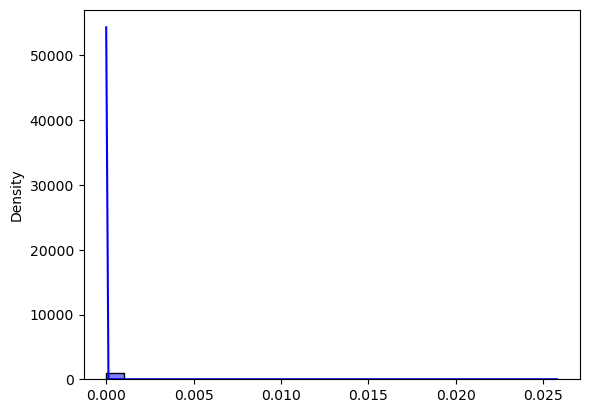

Thr = 0.012415083497762658
Cluster size :  1071
> 0 :  1071 Max :  0.025787057355046272
< 0 :  0 Min :  0.0
Smoothing :  9
0.00625968976318836


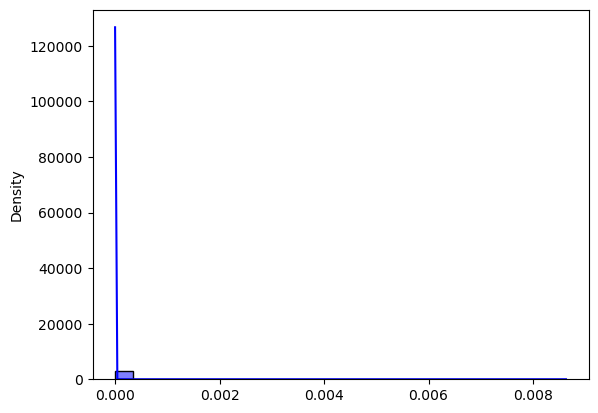

Thr = 0.00625968976318836
Cluster size :  978
> 0 :  978 Max :  0.008630388416349888
< 0 :  0 Min :  0.0
Smoothing :  6
0.008148669809103004


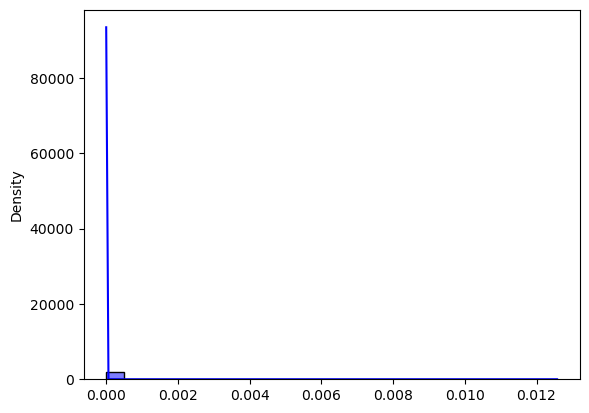

Thr = 0.008148669809103004
Cluster size :  976
> 0 :  976 Max :  0.01257333904504776
< 0 :  0 Min :  0.0
Max consensus :  2.32163463432534e-06
Min consensus :  0.0
Size consensus :  416
[2.34144063]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0004349546480150626. But, you have given threshold=-0.0006367500720709011.
  warnings.warn(


-0.0006367500720709011
[0.03134199]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002672100907529849. But, you have given threshold=-0.0007327899092470151.
  warnings.warn(


-0.0007327899092470151
[0.89552793]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00027937105662584805. But, you have given threshold=-0.0007532731113605742.
  warnings.warn(


-0.0007532731113605742
[0.1154017]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002507893924805999. But, you have given threshold=-0.0007492106075194002.
  warnings.warn(


-0.0007492106075194002
[0.45407336]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002633574188681325. But, you have given threshold=-0.0007366425811318675.
  warnings.warn(


-0.0007366425811318675
Size final cluster :  416


/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


Noise analysis...
[0.29772526]
Smoothing :  3


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0004624343466978158. But, you have given threshold=-0.0005375656533021842.
  warnings.warn(


-0.0005375656533021842


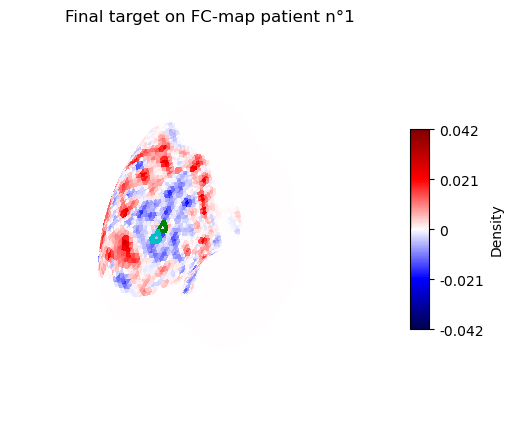

Thr = -0.0005375656533021842
Cluster size :  113564
> 0 :  54419 Max :  0.000462434341898188
< 0 :  59145 Min :  -0.0004485379031393677
Smoothing :  9


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0001516115185715483. But, you have given threshold=-0.0008483884814284517.
  warnings.warn(


-0.0008483884814284517


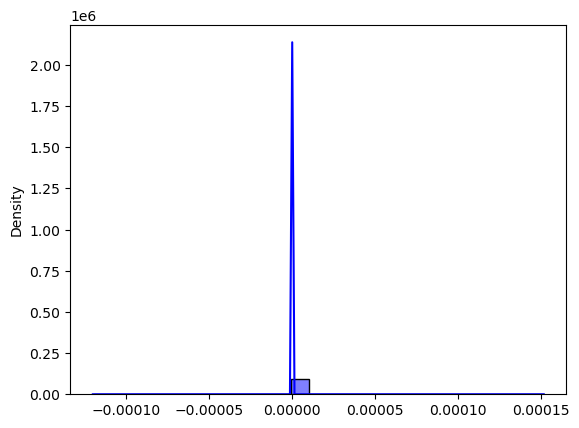

Thr = -0.0008483884814284517
Cluster size :  113564
> 0 :  51299 Max :  0.0001516115153208375
< 0 :  62265 Min :  -0.0001201732738991268
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00025784352558517917. But, you have given threshold=-0.0007421564744148209.
  warnings.warn(


-0.0007421564744148209


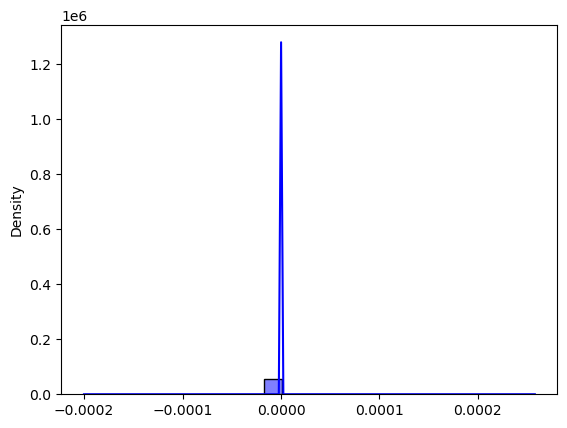

Thr = -0.0007421564744148209
Cluster size :  113564
> 0 :  52631 Max :  0.000257843523286283
< 0 :  60933 Min :  -0.0002002203109441325
Max consensus :  1.6370371297900298e-11
Min consensus :  -7.37366839220261e-12
Size consensus :  113564
[0.3892903]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00025966354468927994. But, you have given threshold=-0.0007403364553107201.
  warnings.warn(


-0.0007403364553107201
[0.18122835]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00026846288222729016. But, you have given threshold=-0.0007315371177727099.
  warnings.warn(


-0.0007315371177727099
[0.10426187]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002949447974565121. But, you have given threshold=-0.0007050552025434878.
  warnings.warn(


-0.0007050552025434878
[0.93015677]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00026354520800263086. But, you have given threshold=-0.0007438260965240986.
  warnings.warn(


-0.0007438260965240986
[0.56020477]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002528014767790392. But, you have given threshold=-0.000781829625887424.
  warnings.warn(


-0.000781829625887424
Size bagging :  113564
Size final cluster :  113564


/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


[0.47234104]
Smoothing :  3
-0.0004993658759919056


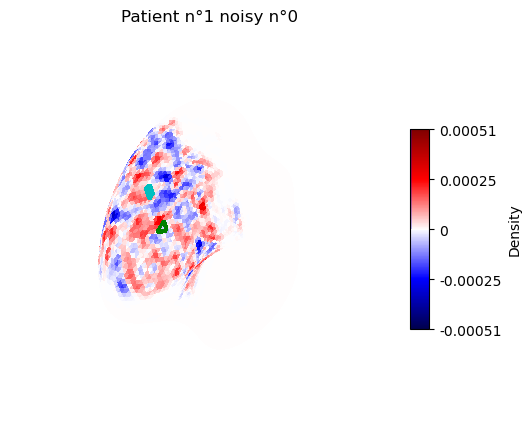

Thr = -0.0004993658759919056
Cluster size :  113563
> 0 :  55506 Max :  0.000500634138006717
< 0 :  58057 Min :  -0.0004924815730191767
Smoothing :  9


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00014902285210410455. But, you have given threshold=-0.0008509771478958954.
  warnings.warn(


-0.0008509771478958954


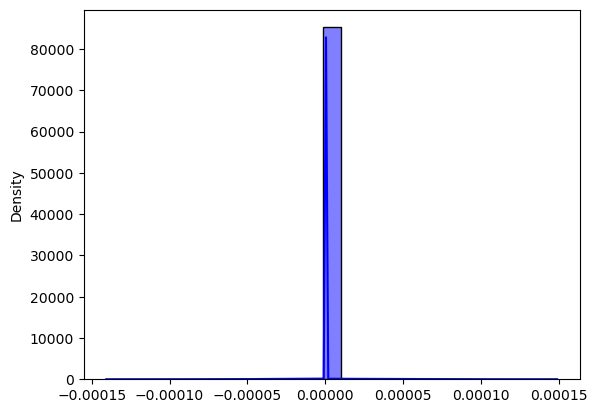

Thr = -0.0008509771478958954
Cluster size :  113564
> 0 :  55797 Max :  0.00014902284601703286
< 0 :  57767 Min :  -0.00014073442434892058
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002717455948070739. But, you have given threshold=-0.000745197968809786.
  warnings.warn(


-0.000745197968809786


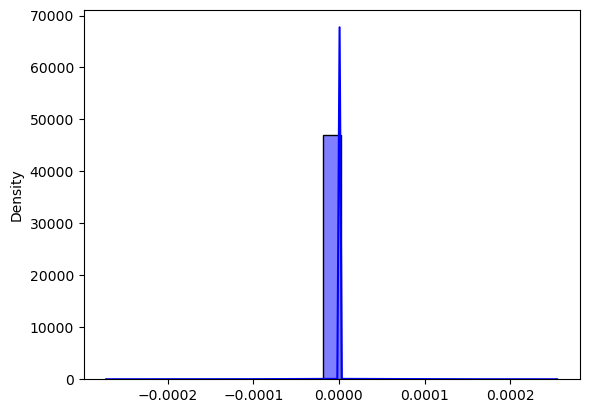

Thr = -0.000745197968809786
Cluster size :  113564
> 0 :  55228 Max :  0.00025480202748440206
< 0 :  58336 Min :  -0.0002717456081882119
Max consensus :  1.675827284503034e-11
Min consensus :  -1.748217095986998e-11
Size consensus :  113563
[0.90380493]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0003535600100272524. But, you have given threshold=-0.0007055135856862626.
  warnings.warn(


-0.0007055135856862626
[1.30162857]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00031078693506799007. But, you have given threshold=-0.00070323587340974.
  warnings.warn(


-0.00070323587340974
[0.05010553]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00025146383567958917. But, you have given threshold=-0.0007832718375923155.
  warnings.warn(


-0.0007832718375923155
[0.36376793]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002464494524431978. But, you have given threshold=-0.0007535505475568022.
  warnings.warn(


-0.0007535505475568022
[1.5717997]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00038893273853879407. But, you have given threshold=-0.000611067261461206.
  warnings.warn(


-0.000611067261461206
Size bagging :  113564
Size final cluster :  113563


/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


[0.3375194]
Smoothing :  3


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0004971800020471798. But, you have given threshold=-0.0005028199979528203.
  warnings.warn(


-0.0005028199979528203


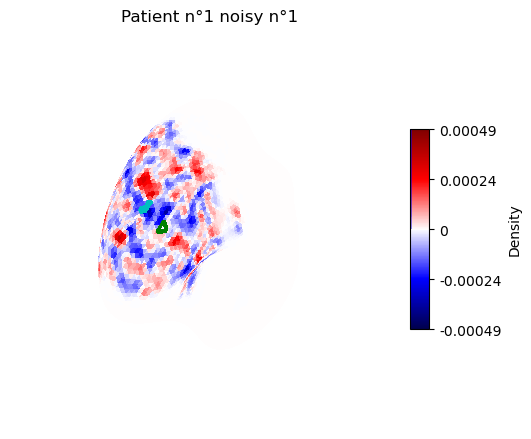

Thr = -0.0005028199979528203
Cluster size :  113564
> 0 :  53212 Max :  0.00049717997899279
< 0 :  60352 Min :  -0.0004506897530518472
Smoothing :  9


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0001249237442459716. But, you have given threshold=-0.0008750762557540284.
  warnings.warn(


-0.0008750762557540284


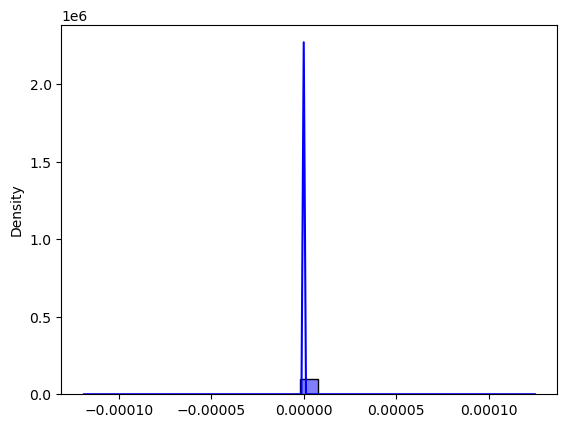

Thr = -0.0008750762557540284
Cluster size :  113564
> 0 :  45159 Max :  0.00012492373934946954
< 0 :  68405 Min :  -0.00011883315164595842
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002312990101640735. But, you have given threshold=-0.0007877909388987865.
  warnings.warn(


-0.0007877909388987865


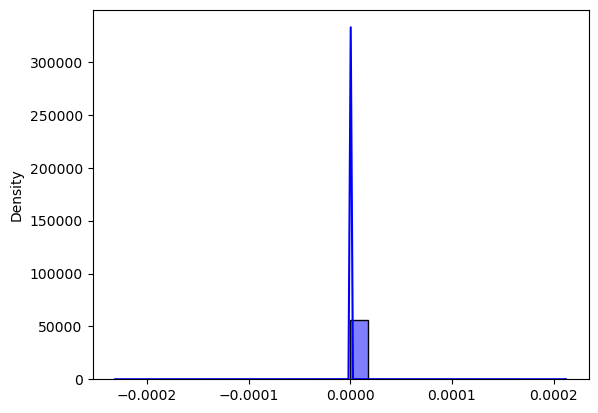

Thr = -0.0007877909388987865
Cluster size :  113564
> 0 :  49910 Max :  0.00021220906637609005
< 0 :  63654 Min :  -0.00023129901092033833
Max consensus :  8.993727283748992e-12
Min consensus :  -1.0102167509210813e-11
Size consensus :  113564
[0.297283]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0. But, you have given threshold=0.0002463277360376067.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002463277360376067. But, you have given threshold=-0.0007536722639623933.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00024381266814485172. But, you have given threshold=-0.0007536722639623933.
  warnings.warn(


-0.0007536722639623933
[0.74256586]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.000274507578843133. But, you have given threshold=-0.0007254924211568671.
  warnings.warn(


-0.0007254924211568671
[0.7793594]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00030658948166619116. But, you have given threshold=-0.0007030240953790918.
  warnings.warn(


-0.0007030240953790918
[0.62080793]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00025120718814501187. But, you have given threshold=-0.0007487928118549882.
  warnings.warn(


-0.0007487928118549882
[0.50063776]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00026805279380210783. But, you have given threshold=-0.0007319472061978922.
  warnings.warn(


-0.0007319472061978922
Size bagging :  113564
Size final cluster :  113564


/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


[0.19792161]
Smoothing :  3
-0.0004864077149691835


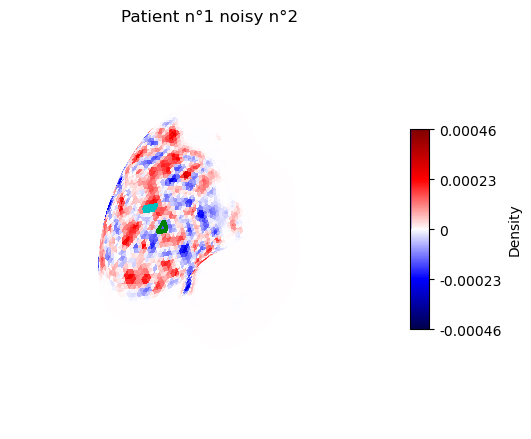

Thr = -0.0004864077149691835
Cluster size :  113564
> 0 :  56518 Max :  0.0005135922692716122
< 0 :  57046 Min :  -0.00044910170254297554
Smoothing :  9


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00015522546247725202. But, you have given threshold=-0.0008447745375227481.
  warnings.warn(


-0.0008447745375227481


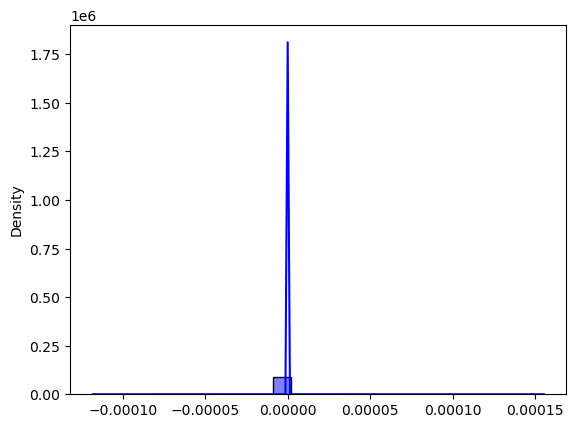

Thr = -0.0008447745375227481
Cluster size :  113564
> 0 :  56876 Max :  0.00015522546891588718
< 0 :  56688 Min :  -0.00011832355812657624
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002691919006357936. But, you have given threshold=-0.0007308080993642064.
  warnings.warn(


-0.0007308080993642064


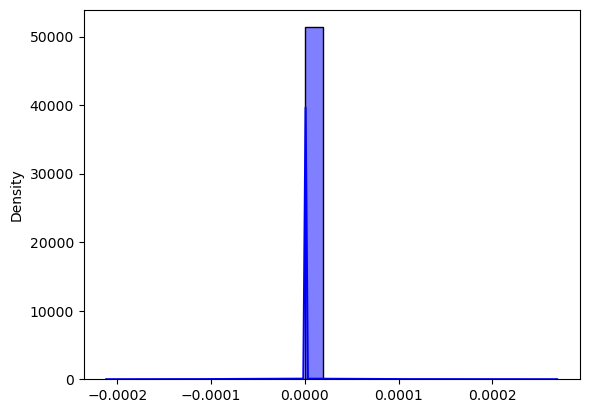

Thr = -0.0007308080993642064
Cluster size :  113564
> 0 :  55951 Max :  0.0002691918925847858
< 0 :  57613 Min :  -0.00021196773741394281
Max consensus :  2.017603974089844e-11
Min consensus :  -9.745304131698232e-12
Size consensus :  113564
[0.52954598]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002591157037003516. But, you have given threshold=-0.0007408842962996485.
  warnings.warn(


-0.0007408842962996485
[1.77452247]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0003490578348712207. But, you have given threshold=-0.0006629060431542358.
  warnings.warn(


-0.0006629060431542358
[1.00683829]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0003390259350585643. But, you have given threshold=-0.0007634662300067434.
  warnings.warn(


-0.0007634662300067434
[0.5075487]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00025448046412229644. But, you have given threshold=-0.0007455195358777036.
  warnings.warn(


-0.0007455195358777036
[1.76519608]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0003652417695450311. But, you have given threshold=-0.0006347582304549689.
  warnings.warn(


-0.0006347582304549689
Size bagging :  113564
Size final cluster :  113564


/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


[1.8128342]
Smoothing :  3
-0.0004667729932688765


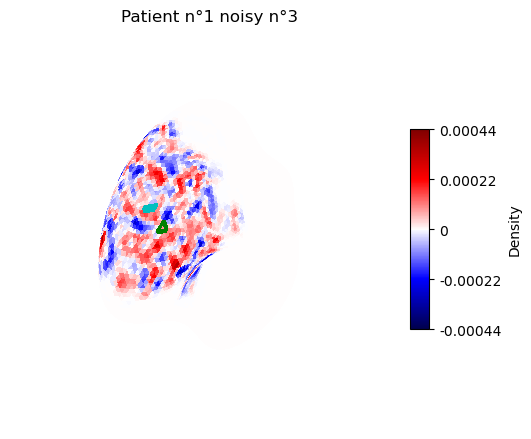

Thr = -0.0004667729932688765
Cluster size :  113108
> 0 :  53413 Max :  0.0005332269938662648
< 0 :  59695 Min :  -0.00046648725401610136
Smoothing :  9


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0003147529698200955. But, you have given threshold=-0.0008089710819417252.
  warnings.warn(


-0.0008089710819417252


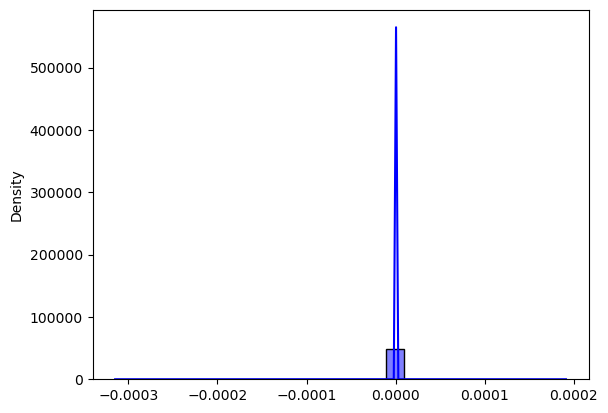

Thr = -0.0008089710819417252
Cluster size :  113564
> 0 :  47653 Max :  0.0001910289138322696
< 0 :  65911 Min :  -0.00031475297873839736
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0004805938632922046. But, you have given threshold=-0.0006904031343160812.
  warnings.warn(


-0.0006904031343160812


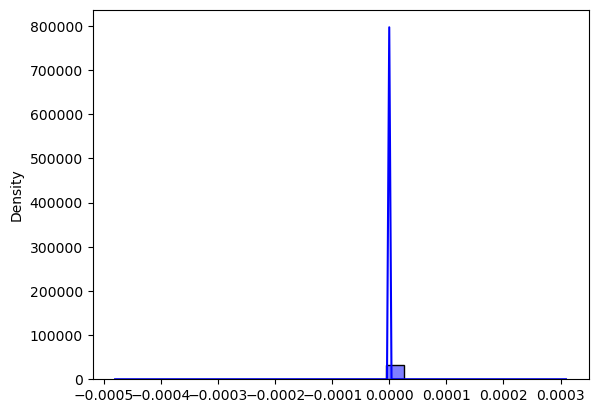

Thr = -0.0006904031343160812
Cluster size :  113564
> 0 :  51096 Max :  0.00030959685682319105
< 0 :  62468 Min :  -0.00048059385153464973
Max consensus :  2.931291749297758e-11
Min consensus :  -5.6435716742246454e-11
Size consensus :  113108
[0.6376162]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002897995775635334. But, you have given threshold=-0.0007694934512975831.
  warnings.warn(


-0.0007694934512975831
[0.80688845]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002586691136221454. But, you have given threshold=-0.0007497374823358713.
  warnings.warn(


-0.0007497374823358713
[0.18928591]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002487415253449503. But, you have given threshold=-0.0007512584746550497.
  warnings.warn(


-0.0007512584746550497
[1.38637787]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0003361122005209588. But, you have given threshold=-0.0007277366892310621.
  warnings.warn(


-0.0007277366892310621
[1.67072333]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0003463409952781496. But, you have given threshold=-0.0006536590047218504.
  warnings.warn(


-0.0006536590047218504
Size bagging :  113564
Size final cluster :  113108


/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


[0.55909922]
Smoothing :  3


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.000544902295705986. But, you have given threshold=-0.0005514933979024594.
  warnings.warn(


-0.0005514933979024594


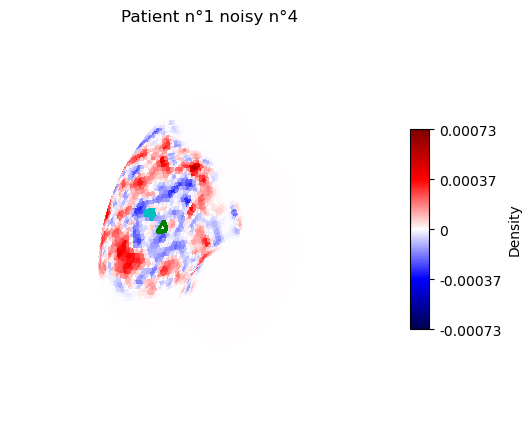

Thr = -0.0005514933979024594
Cluster size :  113564
> 0 :  53718 Max :  0.0004485066165216267
< 0 :  59846 Min :  -0.0005449022864922881
Smoothing :  9


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00014902770142886528. But, you have given threshold=-0.0008587320596290085.
  warnings.warn(


-0.0008587320596290085


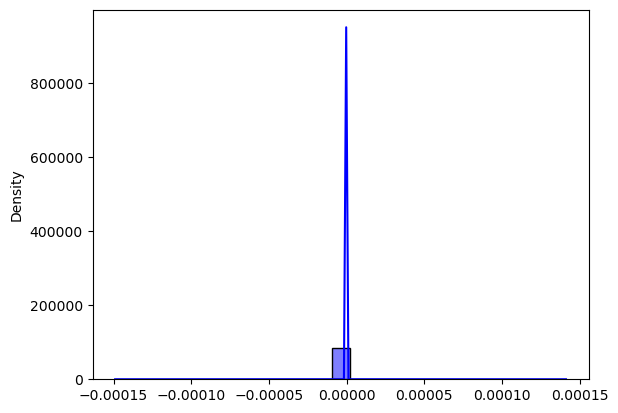

Thr = -0.0008587320596290085
Cluster size :  113564
> 0 :  47362 Max :  0.0001412679412169382
< 0 :  66202 Min :  -0.00014902770635671914
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002747178728457585. But, you have given threshold=-0.0007463162649157141.
  warnings.warn(


-0.0007463162649157141


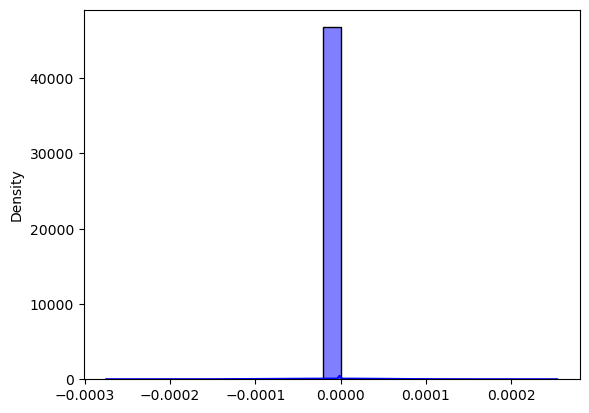

Thr = -0.0007463162649157141
Cluster size :  113564
> 0 :  51089 Max :  0.0002536837419029325
< 0 :  62475 Min :  -0.0002747178659774363
Max consensus :  1.5189036142234628e-11
Min consensus :  -2.0753458045043515e-11
Size consensus :  113564
[0.10515601]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00031328761781984415. But, you have given threshold=-0.0006867123821801559.
  warnings.warn(


-0.0006867123821801559
[0.82962087]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.000266728154653014. But, you have given threshold=-0.000733271845346986.
  warnings.warn(


-0.000733271845346986
[1.40558732]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00034015696622352197. But, you have given threshold=-0.000659843033776478.
  warnings.warn(


-0.000659843033776478
[1.45466471]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0003171017556438496. But, you have given threshold=-0.0006931818278558754.
  warnings.warn(


-0.0006931818278558754
[0.78189622]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0. But, you have given threshold=0.00024655762724966226.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002476041735193507. But, you have given threshold=-0.0007534423727503378.
  warnings.warn(


-0.0007534423727503378
Size bagging :  113564
Size final cluster :  113564


/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


[0.48708199]
Smoothing :  3


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0004917660205582663. But, you have given threshold=-0.0005082339794417337.
  warnings.warn(


-0.0005082339794417337


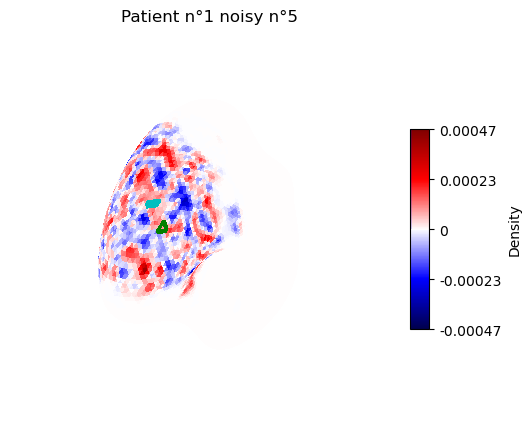

Thr = -0.0005082339794417337
Cluster size :  113564
> 0 :  56673 Max :  0.0004917660262435675
< 0 :  56891 Min :  -0.00044529789010994136
Smoothing :  9


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00018782360365749787. But, you have given threshold=-0.0008121763963425022.
  warnings.warn(


-0.0008121763963425022


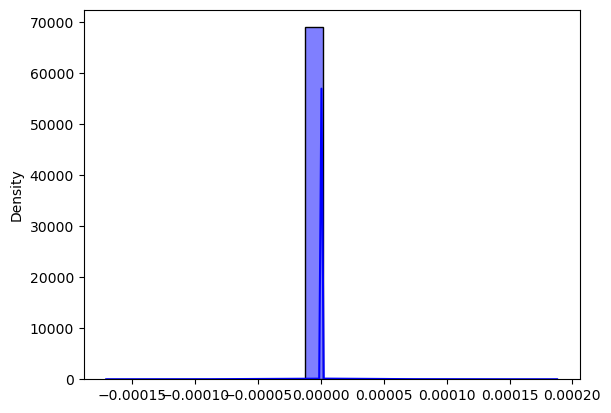

Thr = -0.0008121763963425022
Cluster size :  113564
> 0 :  56001 Max :  0.00018782360712066293
< 0 :  57563 Min :  -0.00017049281450454146
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00029775490275323415. But, you have given threshold=-0.0007022450972467659.
  warnings.warn(


-0.0007022450972467659


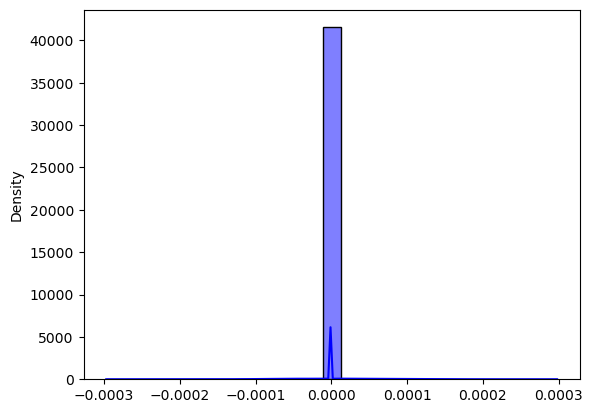

Thr = -0.0007022450972467659
Cluster size :  113564
> 0 :  56359 Max :  0.0002977549156639725
< 0 :  57205 Min :  -0.0002969641354866326
Max consensus :  2.5930418118535967e-11
Min consensus :  -2.091169124487032e-11
Size consensus :  113564
[1.79358312]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00032206482644215614. But, you have given threshold=-0.0007485611822890043.
  warnings.warn(


-0.0007485611822890043
[0.57561356]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00024717122148170594. But, you have given threshold=-0.0007531863836367212.
  warnings.warn(


-0.0007531863836367212
[0.19203157]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00025265245471469815. But, you have given threshold=-0.0007473475452853019.
  warnings.warn(


-0.0007473475452853019
[1.01857627]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.000269961488809624. But, you have given threshold=-0.0007658591773380806.
  warnings.warn(


-0.0007658591773380806
[0.74823337]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002871340654725796. But, you have given threshold=-0.0007128659345274204.
  warnings.warn(


-0.0007128659345274204
Size bagging :  113564
Size final cluster :  113564


/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


[2.05839357]
Smoothing :  3
-0.00033575188910877957


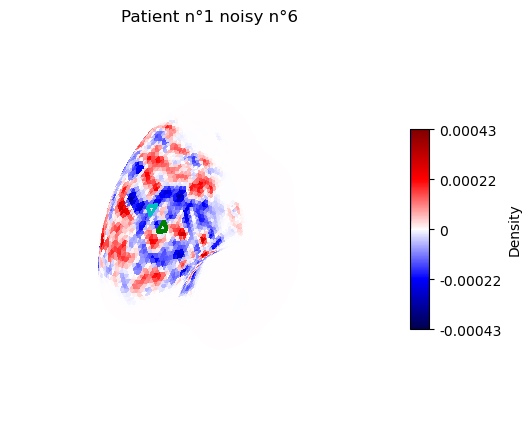

Thr = -0.00033575188910877957
Cluster size :  109046
> 0 :  51825 Max :  0.0006642481312155724
< 0 :  57221 Min :  -0.0003357297391630709
Smoothing :  9


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0003019127973647323. But, you have given threshold=-0.0007658325248384088.
  warnings.warn(


-0.0007658325248384088


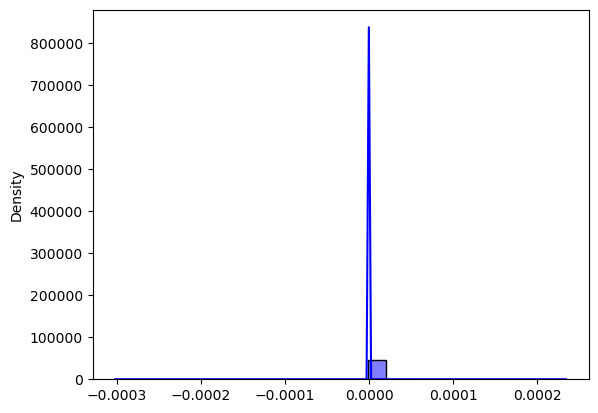

Thr = -0.0007658325248384088
Cluster size :  113564
> 0 :  47684 Max :  0.00023416746989823878
< 0 :  65880 Min :  -0.0003019128052983433
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00043998883076792943. But, you have given threshold=-0.0006090605874721974.
  warnings.warn(


-0.0006090605874721974


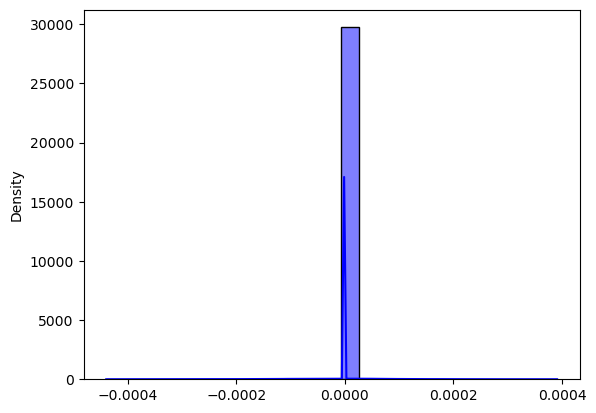

Thr = -0.0006090605874721974
Cluster size :  113564
> 0 :  50818 Max :  0.0003909394145011902
< 0 :  62746 Min :  -0.0004399888275656849
Max consensus :  5.652576503733225e-11
Min consensus :  -2.6085807002121483e-11
Size consensus :  109046
[0.62007886]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0003146869341820773. But, you have given threshold=-0.0006853130658179227.
  warnings.warn(


-0.0006853130658179227
[1.72021713]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0004135193853410319. But, you have given threshold=-0.0005864806146589682.
  warnings.warn(


-0.0005864806146589682
[0.1711191]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002457231935168189. But, you have given threshold=-0.0007891623407005042.
  warnings.warn(


-0.0007891623407005042
[0.22970828]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002945176376205553. But, you have given threshold=-0.0007054823623794447.
  warnings.warn(


-0.0007054823623794447
[0.53233813]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00029124826044260664. But, you have given threshold=-0.0007087517395573934.
  warnings.warn(


-0.0007087517395573934
Size bagging :  113564
Size final cluster :  109046


/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


[1.45163571]
Smoothing :  3
-0.00044174620907997775


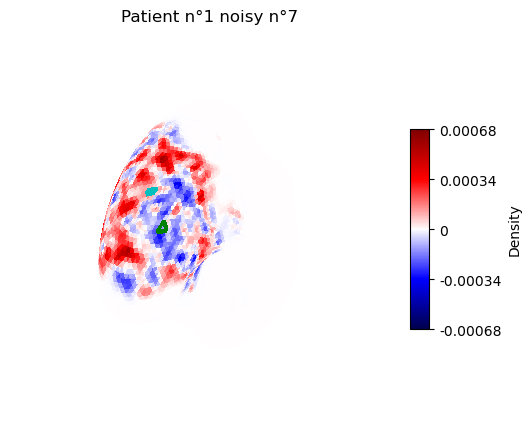

Thr = -0.00044174620907997775
Cluster size :  113384
> 0 :  51630 Max :  0.0005582537851296365
< 0 :  61754 Min :  -0.0004417289746925235
Smoothing :  9


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.000211853540279935. But, you have given threshold=-0.0007881464597200651.
  warnings.warn(


-0.0007881464597200651


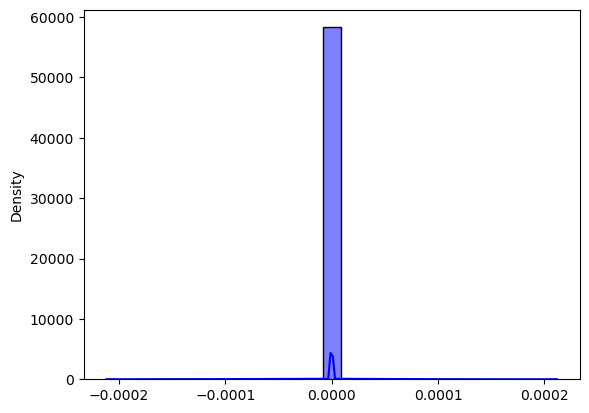

Thr = -0.0007881464597200651
Cluster size :  113564
> 0 :  47506 Max :  0.0002118535339832306
< 0 :  66058 Min :  -0.00021184100478421897
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00034227471828702816. But, you have given threshold=-0.0006577252817129718.
  warnings.warn(


-0.0006577252817129718


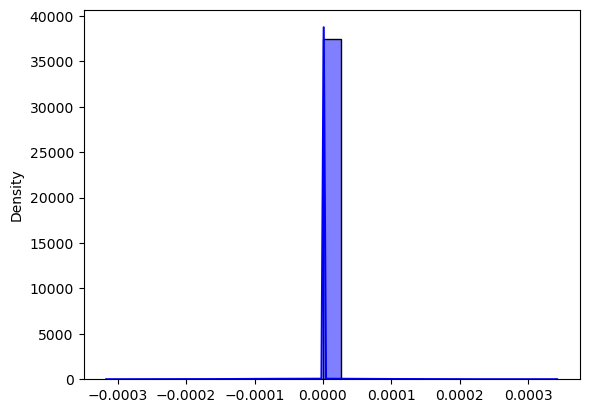

Thr = -0.0006577252817129718
Cluster size :  113564
> 0 :  49779 Max :  0.000342274724971503
< 0 :  63785 Min :  -0.00031687587033957243
Max consensus :  3.891192714351945e-11
Min consensus :  -2.886053453789276e-11
Size consensus :  113384
[1.02650978]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002773549186717992. But, you have given threshold=-0.000752280914075045.
  warnings.warn(


-0.000752280914075045
[0.4142602]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00022841551584065528. But, you have given threshold=-0.0007715844841593447.
  warnings.warn(


-0.0007715844841593447
[0.73596821]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00028191479296529615. But, you have given threshold=-0.0007254675757223537.
  warnings.warn(


-0.0007254675757223537
[0.1401325]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00025126711138268563. But, you have given threshold=-0.0007589986869971014.
  warnings.warn(


-0.0007589986869971014
[0.07280859]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002849603863208551. But, you have given threshold=-0.0007150396136791449.
  warnings.warn(


-0.0007150396136791449
Size bagging :  113564
Size final cluster :  113384


/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


[0.27046818]
Smoothing :  3


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0004939541696549845. But, you have given threshold=-0.0005060458303450155.
  warnings.warn(


-0.0005060458303450155


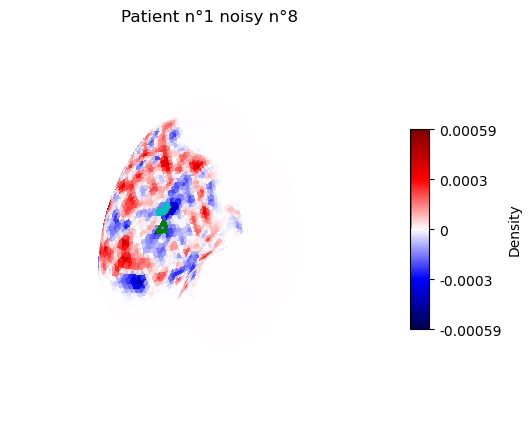

Thr = -0.0005060458303450155
Cluster size :  113564
> 0 :  56502 Max :  0.0004939541686326265
< 0 :  57062 Min :  -0.0004843497008550912
Smoothing :  9


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0001643435135111352. But, you have given threshold=-0.000881211716991167.
  warnings.warn(


-0.000881211716991167


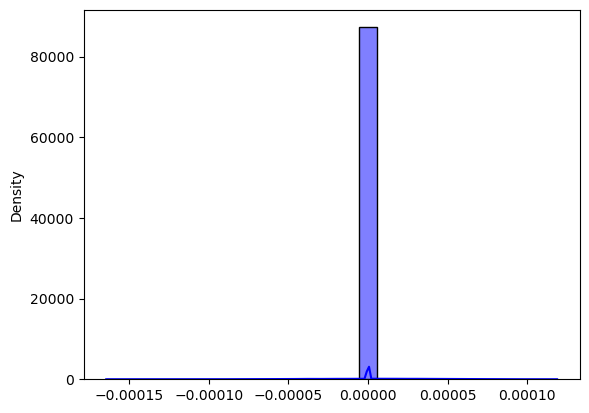

Thr = -0.000881211716991167
Cluster size :  113564
> 0 :  57762 Max :  0.00011878828081535175
< 0 :  55802 Min :  -0.00016434350982308388
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00027164152734922704. But, you have given threshold=-0.0007891538333634821.
  warnings.warn(


-0.0007891538333634821


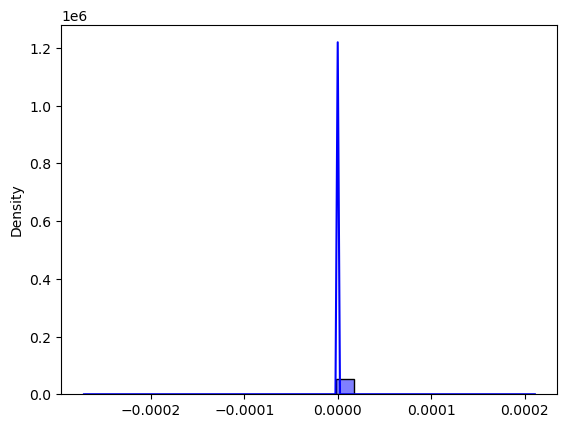

Thr = -0.0007891538333634821
Cluster size :  113564
> 0 :  57265 Max :  0.00021084616309963167
< 0 :  56299 Min :  -0.00027164153289049864
Max consensus :  9.246126375386317e-12
Min consensus :  -2.031234381139787e-11
Size consensus :  113564
[0.37483116]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00023610751922106588. But, you have given threshold=-0.0007638924807789342.
  warnings.warn(


-0.0007638924807789342
[0.27841598]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002539540929117978. But, you have given threshold=-0.0008035934428400533.
  warnings.warn(


-0.0008035934428400533
[1.51317173]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0003011006724118488. But, you have given threshold=-0.000730131153029734.
  warnings.warn(


-0.000730131153029734
[0.31765952]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002651928336982564. But, you have given threshold=-0.0007348071663017436.
  warnings.warn(


-0.0007348071663017436
[0.89179996]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00029070383632015745. But, you have given threshold=-0.0007092961636798426.
  warnings.warn(


-0.0007092961636798426
Size bagging :  113564
Size final cluster :  113564


/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


[0.15690342]
Smoothing :  3
-0.0004531983363885764


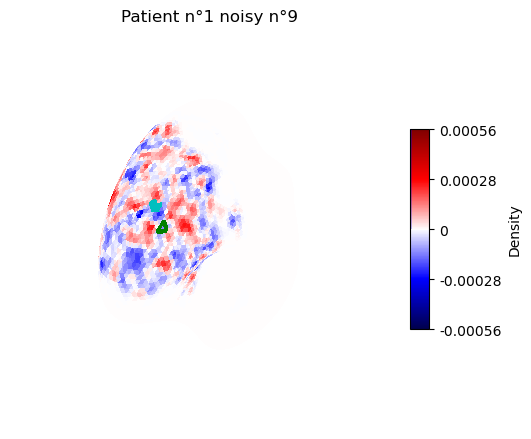

Thr = -0.0004531983363885764
Cluster size :  113564
> 0 :  53903 Max :  0.0005468016606755555
< 0 :  59661 Min :  -0.00041882271762005985
Smoothing :  9


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00013863350137311093. But, you have given threshold=-0.000861366498626889.
  warnings.warn(


-0.000861366498626889


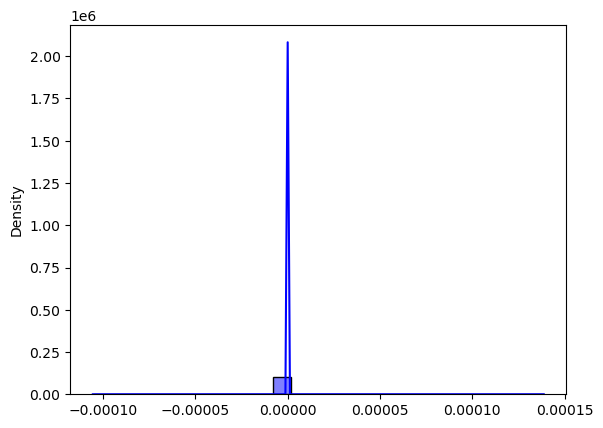

Thr = -0.000861366498626889
Cluster size :  113564
> 0 :  47592 Max :  0.00013863350613974035
< 0 :  65972 Min :  -0.00010547617421252653
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002895916509481634. But, you have given threshold=-0.0007104083490518366.
  warnings.warn(


-0.0007104083490518366


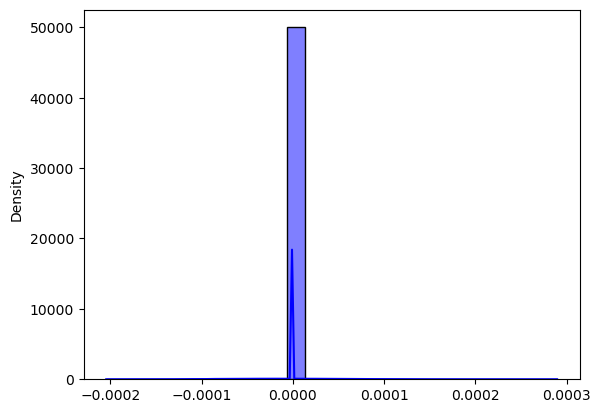

Thr = -0.0007104083490518366
Cluster size :  113564
> 0 :  51463 Max :  0.0002895916404668242
< 0 :  62101 Min :  -0.00020449334988370538
Max consensus :  2.166549524850899e-11
Min consensus :  -7.80537952354453e-12
Size consensus :  113564
[0.79470597]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.000281975568644479. But, you have given threshold=-0.000718024431355521.
  warnings.warn(


-0.000718024431355521
[1.74054827]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00037706699498457. But, you have given threshold=-0.0006959351648025806.
  warnings.warn(


-0.0006959351648025806
[0.15395507]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002262259619475784. But, you have given threshold=-0.0007894150938662374.
  warnings.warn(


-0.0007894150938662374
[1.0246066]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00030742246392005955. But, you have given threshold=-0.0006925775360799404.
  warnings.warn(


-0.0006925775360799404
[0.10479024]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002272692441982232. But, you have given threshold=-0.0007786496943792475.
  warnings.warn(


-0.0007786496943792475
Size bagging :  113564
Size final cluster :  113564


/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


[1.25687664]
Smoothing :  3


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0004986501574104014. But, you have given threshold=-0.0005013498425895986.
  warnings.warn(


-0.0005013498425895986


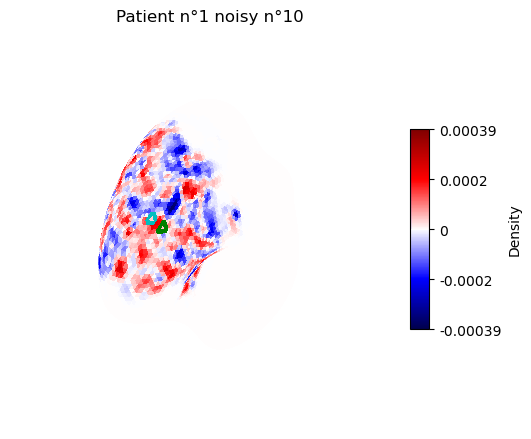

Thr = -0.0005013498425895986
Cluster size :  113559
> 0 :  53139 Max :  0.0004986501298844814
< 0 :  60420 Min :  -0.0004982742830179632
Smoothing :  9


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00020081590405851422. But, you have given threshold=-0.0007991840959414858.
  warnings.warn(


-0.0007991840959414858


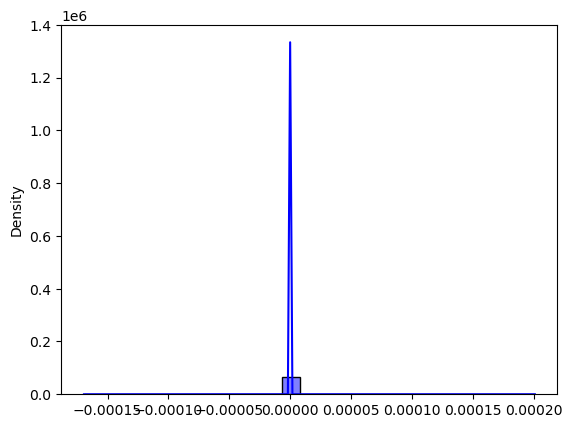

Thr = -0.0007991840959414858
Cluster size :  113564
> 0 :  51112 Max :  0.00020081590628251433
< 0 :  62452 Min :  -0.00016937415057327598
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00029834904590839964. But, you have given threshold=-0.0007016509540916004.
  warnings.warn(


-0.0007016509540916004


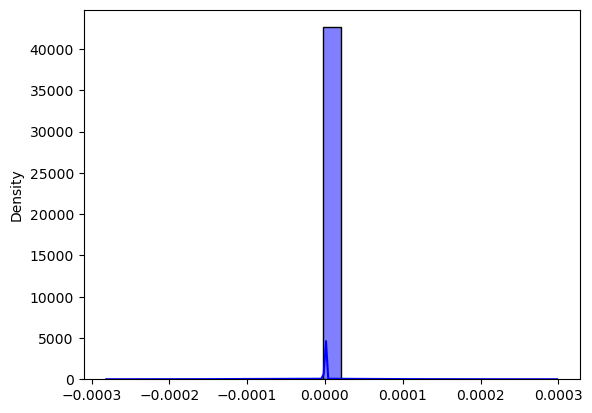

Thr = -0.0007016509540916004
Cluster size :  113564
> 0 :  51674 Max :  0.00029834904125891626
< 0 :  61890 Min :  -0.0002811141894198954
Max consensus :  2.4952668127614876e-11
Min consensus :  -2.162393273358164e-11
Size consensus :  113559
[0.89941045]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00027414589957073024. But, you have given threshold=-0.0007440378941359789.
  warnings.warn(


-0.0007440378941359789
[1.62599092]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0003554211163598542. But, you have given threshold=-0.0006445788836401459.
  warnings.warn(


-0.0006445788836401459
[0.24151642]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00028610819056432385. But, you have given threshold=-0.0007575093118354476.
  warnings.warn(


-0.0007575093118354476
[0.91522451]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00029131616977491945. But, you have given threshold=-0.0007413461103189434.
  warnings.warn(


-0.0007413461103189434
[0.96597821]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002523948009022415. But, you have given threshold=-0.0007539655407392677.
  warnings.warn(


-0.0007539655407392677
Size bagging :  113564
Size final cluster :  113559


/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


[2.17379123]
Smoothing :  3
-0.0002570271677251406


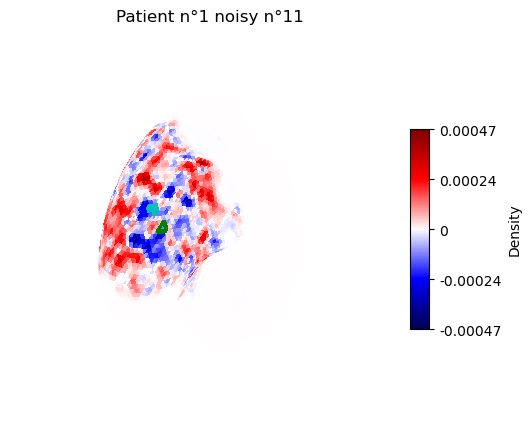

Thr = -0.0002570271677251406
Cluster size :  104787
> 0 :  54322 Max :  0.0007429728284478188
< 0 :  50465 Min :  -0.0002570231445133686
Smoothing :  9


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00030097628316982044. But, you have given threshold=-0.0007252427059359491.
  warnings.warn(


-0.0007252427059359491


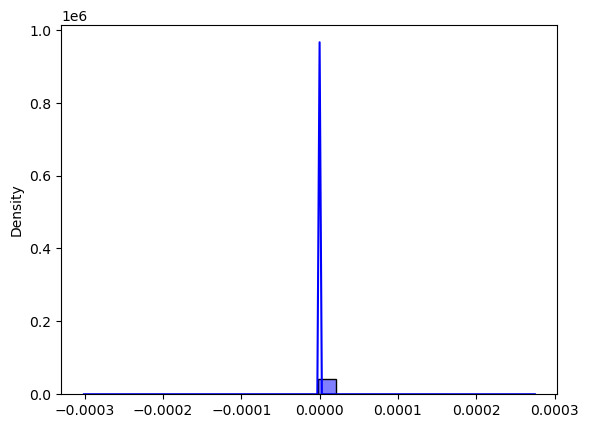

Thr = -0.0007252427059359491
Cluster size :  113564
> 0 :  48885 Max :  0.0002747573016677052
< 0 :  64679 Min :  -0.00030097627313807607
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00044433162945073195. But, you have given threshold=-0.0005556683705492681.
  warnings.warn(


-0.0005556683705492681


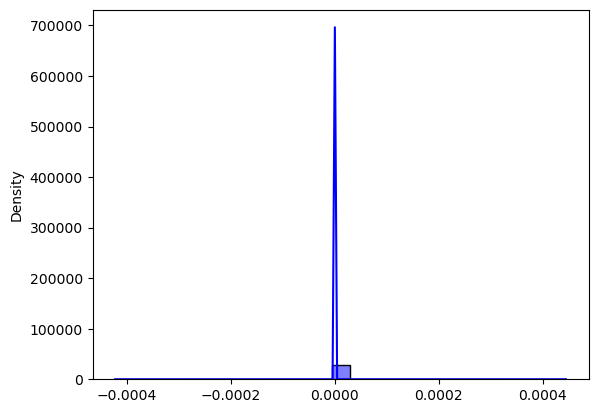

Thr = -0.0005556683705492681
Cluster size :  113564
> 0 :  52483 Max :  0.0004443316429387778
< 0 :  61081 Min :  -0.00042282664799131453
Max consensus :  8.957223297599783e-11
Min consensus :  -2.0553167753027802e-11
Size consensus :  104787
[0.0394078]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002970040421395758. But, you have given threshold=-0.0007470723683771304.
  warnings.warn(


-0.0007470723683771304
[0.0857286]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002610329052068054. But, you have given threshold=-0.0007389670947931947.
  warnings.warn(


-0.0007389670947931947
[0.21562545]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002749869873518401. But, you have given threshold=-0.0007950795858360086.
  warnings.warn(


-0.0007950795858360086
[0.86856769]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00029787646902001595. But, you have given threshold=-0.0007224408678082603.
  warnings.warn(


-0.0007224408678082603
[0.28930776]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002804504562775517. But, you have given threshold=-0.0007757472222120335.
  warnings.warn(


-0.0007757472222120335
Size bagging :  113564
Size final cluster :  104787


/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


[0.877642]
Smoothing :  3


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.000507344765149902. But, you have given threshold=-0.0005157052566919279.
  warnings.warn(


-0.0005157052566919279


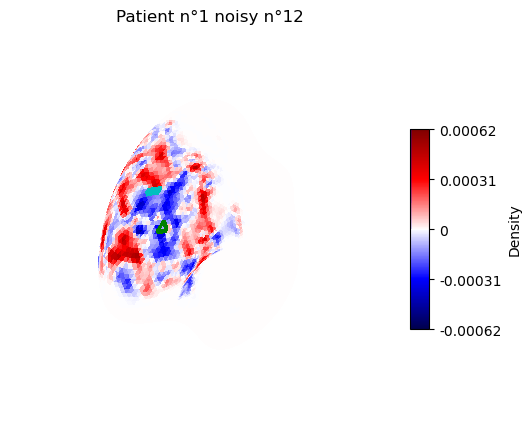

Thr = -0.0005157052566919279
Cluster size :  113564
> 0 :  55493 Max :  0.0004842947528231889
< 0 :  58071 Min :  -0.0005073447828181088
Smoothing :  9


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00018286947827368173. But, you have given threshold=-0.0008682274378413249.
  warnings.warn(


-0.0008682274378413249


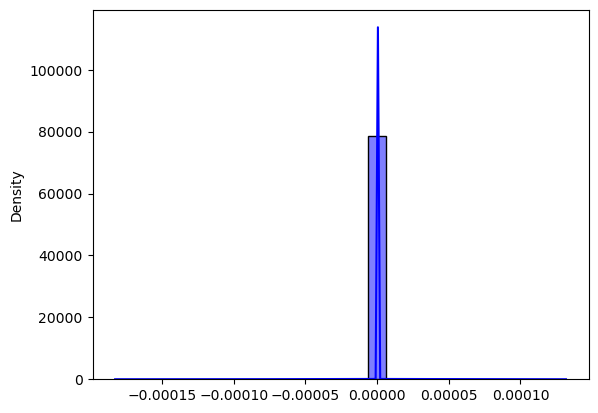

Thr = -0.0008682274378413249
Cluster size :  113564
> 0 :  52137 Max :  0.00013177256914786994
< 0 :  61427 Min :  -0.00018286948034074157
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0003028269822369373. But, you have given threshold=-0.0007682481274336882.
  warnings.warn(


-0.0007682481274336882


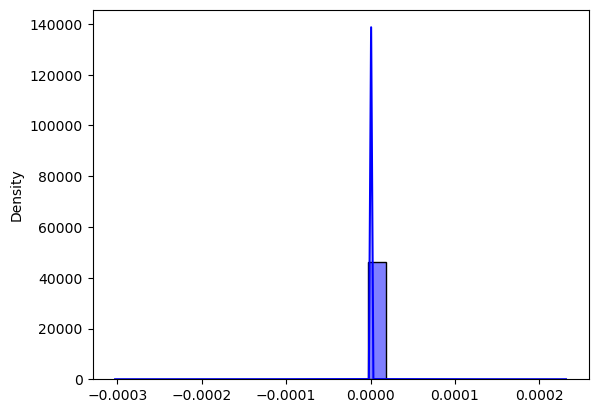

Thr = -0.0007682481274336882
Cluster size :  113564
> 0 :  54008 Max :  0.0002317518665222451
< 0 :  59556 Min :  -0.00030282698571681976
Max consensus :  1.2759128217942876e-11
Min consensus :  -2.6229308605656524e-11
Size consensus :  113564
[1.42039705]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00034769853345195174. But, you have given threshold=-0.0007345498677892364.
  warnings.warn(


-0.0007345498677892364
[0.52146839]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00023262737203068312. But, you have given threshold=-0.0007868719403441912.
  warnings.warn(


-0.0007868719403441912
[1.40181021]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0003044180304681812. But, you have given threshold=-0.0007034527486060906.
  warnings.warn(


-0.0007034527486060906
[0.84144556]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002769482138950596. But, you have given threshold=-0.0007230517861049404.
  warnings.warn(


-0.0007230517861049404
[0.48505817]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00027256842584745815. But, you have given threshold=-0.0007944526705084812.
  warnings.warn(


-0.0007944526705084812
Size bagging :  113564
Size final cluster :  113564


/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


[0.71185985]
Smoothing :  3


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.000482682524001625. But, you have given threshold=-0.0005480209306267753.
  warnings.warn(


-0.0005480209306267753


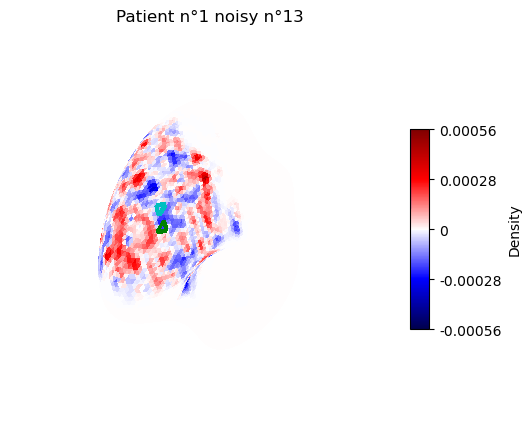

Thr = -0.0005480209306267753
Cluster size :  113564
> 0 :  54494 Max :  0.000451979081844911
< 0 :  59070 Min :  -0.0004826825170312077
Smoothing :  9


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0001937521510748183. But, you have given threshold=-0.0008062478489251817.
  warnings.warn(


-0.0008062478489251817


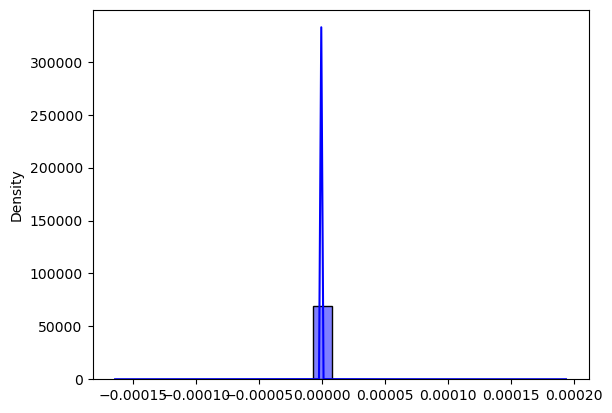

Thr = -0.0008062478489251817
Cluster size :  113564
> 0 :  53532 Max :  0.00019375214469619095
< 0 :  60032 Min :  -0.0001640237751416862
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002922003795329221. But, you have given threshold=-0.000707799620467078.
  warnings.warn(


-0.000707799620467078


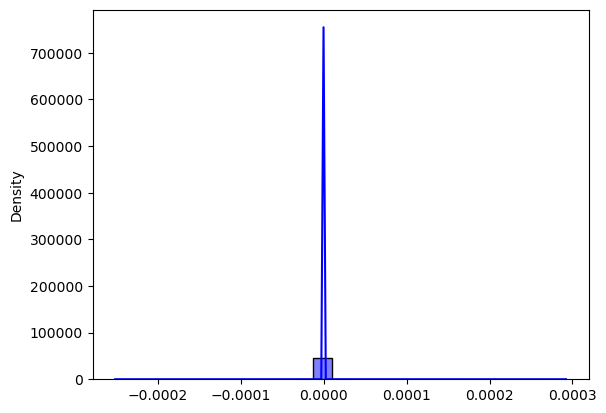

Thr = -0.000707799620467078
Cluster size :  113564
> 0 :  53986 Max :  0.00029220039141364396
< 0 :  59578 Min :  -0.000251821125857532
Max consensus :  2.4482340370801412e-11
Min consensus :  -1.5581774959838562e-11
Size consensus :  113564
[0.06101357]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002557315594926799. But, you have given threshold=-0.0007942607960056472.
  warnings.warn(


-0.0007942607960056472
[1.42853055]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0003415440905581673. But, you have given threshold=-0.0007220790449710473.
  warnings.warn(


-0.0007220790449710473
[0.79772082]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002509723996000141. But, you have given threshold=-0.0007490276003999859.
  warnings.warn(


-0.0007490276003999859
[1.57107127]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00038134090408793725. But, you have given threshold=-0.0006186590959120627.
  warnings.warn(


-0.0006186590959120627
[0.60847836]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00024140690520354266. But, you have given threshold=-0.0007728799189418059.
  warnings.warn(


-0.0007728799189418059
Size bagging :  113564
Size final cluster :  113564


/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


[0.15781786]
Smoothing :  3


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0005061148420711457. But, you have given threshold=-0.00054912152820087.
  warnings.warn(


-0.00054912152820087


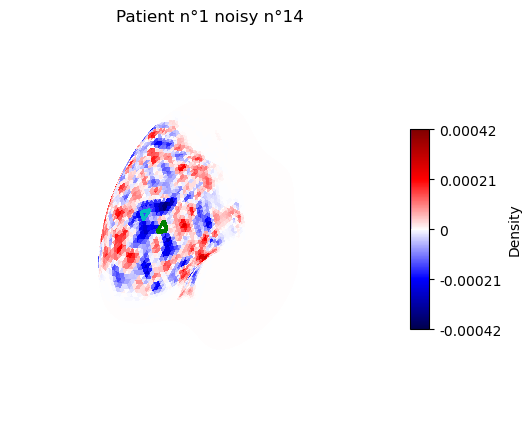

Thr = -0.00054912152820087
Cluster size :  113564
> 0 :  57487 Max :  0.0004508784622885287
< 0 :  56077 Min :  -0.0005061148549430072
Smoothing :  9


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0001457784637108154. But, you have given threshold=-0.0008542215362891846.
  warnings.warn(


-0.0008542215362891846


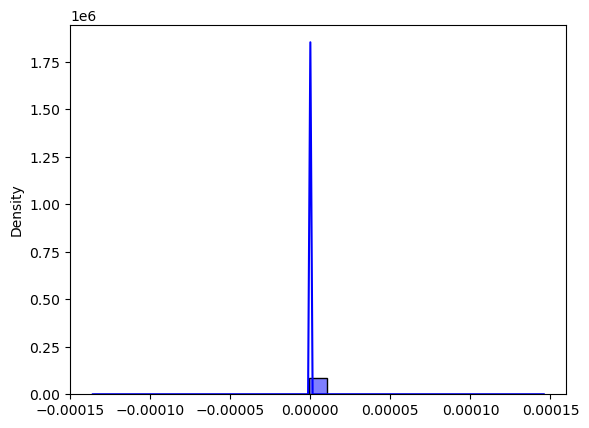

Thr = -0.0008542215362891846
Cluster size :  113564
> 0 :  59171 Max :  0.00014577846741303802
< 0 :  54393 Min :  -0.00013593985931947827
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002435034294184608. But, you have given threshold=-0.0007564965705815392.
  warnings.warn(


-0.0007564965705815392


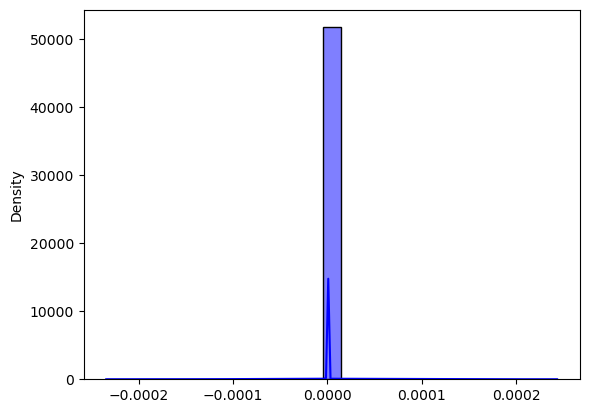

Thr = -0.0007564965705815392
Cluster size :  113564
> 0 :  58140 Max :  0.00024350342573598027
< 0 :  55424 Min :  -0.00023434832110069692
Max consensus :  1.2515376161005671e-11
Min consensus :  -1.1600411264568541e-11
Size consensus :  113564
[0.26261806]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002050023613545198. But, you have given threshold=-0.0007949976386454802.
  warnings.warn(


-0.0007949976386454802
[0.22327372]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00027500190151878. But, you have given threshold=-0.0007940130220212467.
  warnings.warn(


-0.0007940130220212467
[1.99128506]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00037446452671862284. But, you have given threshold=-0.0006626345390149047.
  warnings.warn(


-0.0006626345390149047
[0.62214837]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00024677176268899054. But, you have given threshold=-0.0007957724512881715.
  warnings.warn(


-0.0007957724512881715
[0.66359199]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00028275830714928634. But, you have given threshold=-0.0007172416928507136.
  warnings.warn(


-0.0007172416928507136
Size bagging :  113564
Size final cluster :  113564


/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


[1.26947154]
Smoothing :  3
-0.0004877012837206015


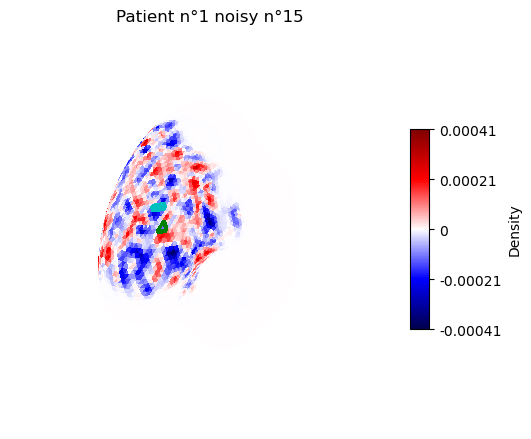

Thr = -0.0004877012837206015
Cluster size :  113541
> 0 :  48665 Max :  0.0005122987204231322
< 0 :  64876 Min :  -0.0004863096110057086
Smoothing :  9


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0001893672238909885. But, you have given threshold=-0.000840586852227906.
  warnings.warn(


-0.000840586852227906


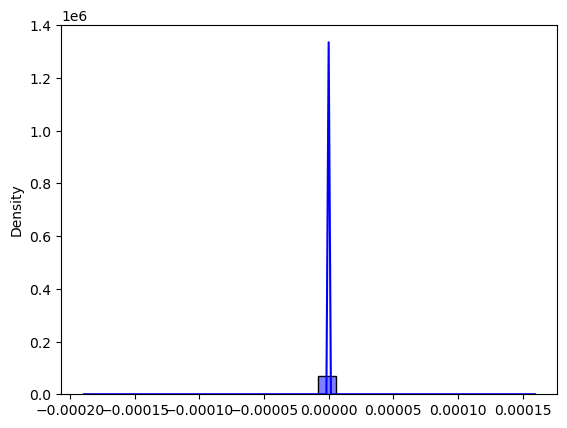

Thr = -0.000840586852227906
Cluster size :  113564
> 0 :  38519 Max :  0.00015941314632073045
< 0 :  75045 Min :  -0.0001893672306323424
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0003193917358069931. But, you have given threshold=-0.000712848586176413.
  warnings.warn(


-0.000712848586176413


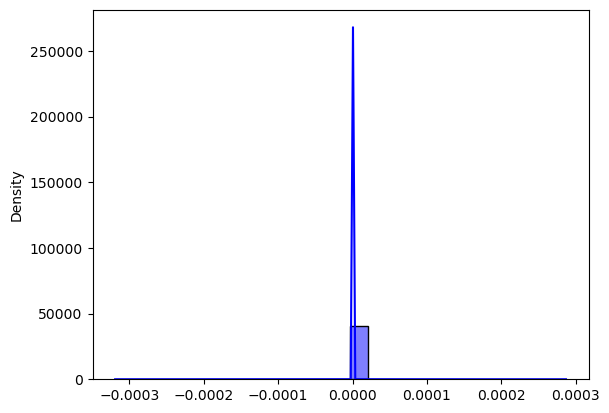

Thr = -0.000712848586176413
Cluster size :  113564
> 0 :  44072 Max :  0.0002871514006983489
< 0 :  69492 Min :  -0.0003193917218595743
Max consensus :  2.3228933883463107e-11
Min consensus :  -2.5964841061553433e-11
Size consensus :  113541
[0.77826649]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00028351800480464005. But, you have given threshold=-0.00071648199519536.
  warnings.warn(


-0.00071648199519536
[0.22392396]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00023562331847023994. But, you have given threshold=-0.0007838545259052847.
  warnings.warn(


-0.0007838545259052847
[0.14221034]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00028926125665263997. But, you have given threshold=-0.00071073874334736.
  warnings.warn(


-0.00071073874334736
[0.81749165]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002620578313288091. But, you have given threshold=-0.0007379421686711908.
  warnings.warn(


-0.0007379421686711908
[0.15556962]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00023283467465537932. But, you have given threshold=-0.0007671653253446207.
  warnings.warn(


-0.0007671653253446207
Size bagging :  113564
Size final cluster :  113541


/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


[1.44935396]
Smoothing :  3


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0005175813146730537. But, you have given threshold=-0.0005182321444793966.
  warnings.warn(


-0.0005182321444793966


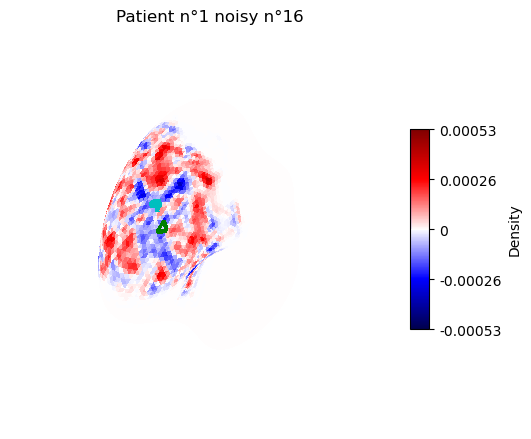

Thr = -0.0005182321444793966
Cluster size :  113468
> 0 :  49986 Max :  0.00048176784184761345
< 0 :  63482 Min :  -0.000517581298481673
Smoothing :  9


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00023744504758257587. But, you have given threshold=-0.000810475997606686.
  warnings.warn(


-0.000810475997606686


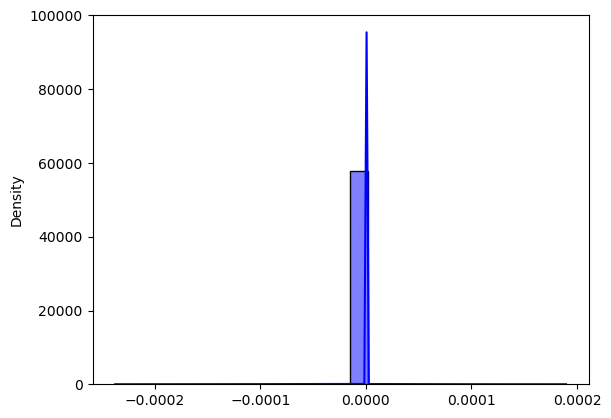

Thr = -0.000810475997606686
Cluster size :  113564
> 0 :  43027 Max :  0.0001895239984150976
< 0 :  70537 Min :  -0.00023744504142086953
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00038543594627145155. But, you have given threshold=-0.0006796204590152405.
  warnings.warn(


-0.0006796204590152405


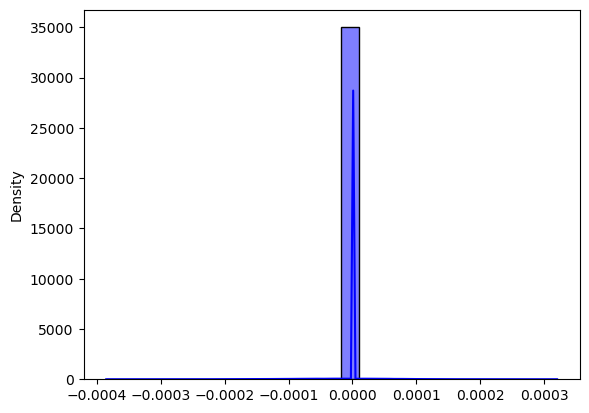

Thr = -0.0006796204590152405
Cluster size :  113564
> 0 :  46529 Max :  0.0003203795349691063
< 0 :  67035 Min :  -0.00038543593836948276
Max consensus :  2.7816137656623525e-11
Min consensus :  -4.109136958656494e-11
Size consensus :  113468
[0.54306076]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00026175821587940236. But, you have given threshold=-0.0007382417841205976.
  warnings.warn(


-0.0007382417841205976
[0.31826331]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00024320295070930098. But, you have given threshold=-0.000756797049290699.
  warnings.warn(


-0.000756797049290699
[1.45191866]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.000315858920797804. But, you have given threshold=-0.0007366298570047501.
  warnings.warn(


-0.0007366298570047501
[0.65062112]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002436880313534125. But, you have given threshold=-0.0007563119686465875.
  warnings.warn(


-0.0007563119686465875
[1.69251481]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0004268680841239595. But, you have given threshold=-0.0005731319158760405.
  warnings.warn(


-0.0005731319158760405
Size bagging :  113564
Size final cluster :  113468


/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


[0.14754617]
Smoothing :  3


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0004757260968129335. But, you have given threshold=-0.0005242739031870666.
  warnings.warn(


-0.0005242739031870666


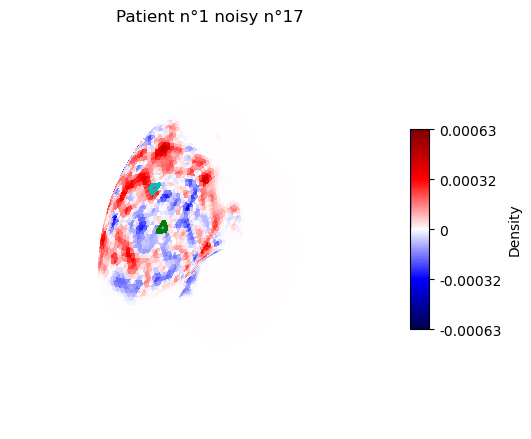

Thr = -0.0005242739031870666
Cluster size :  113564
> 0 :  56647 Max :  0.00047572609037160873
< 0 :  56917 Min :  -0.00041294822585769
Smoothing :  9


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.000155656595123437. But, you have given threshold=-0.000844343404876563.
  warnings.warn(


-0.000844343404876563


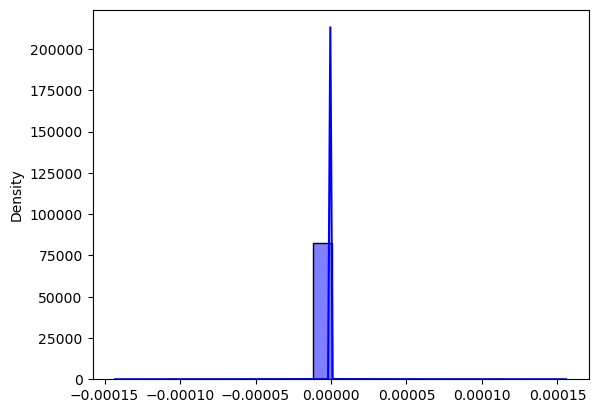

Thr = -0.000844343404876563
Cluster size :  113564
> 0 :  55815 Max :  0.000155656598508358
< 0 :  57749 Min :  -0.00014304040814749897
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002637934538317375. But, you have given threshold=-0.0007362065461682625.
  warnings.warn(


-0.0007362065461682625


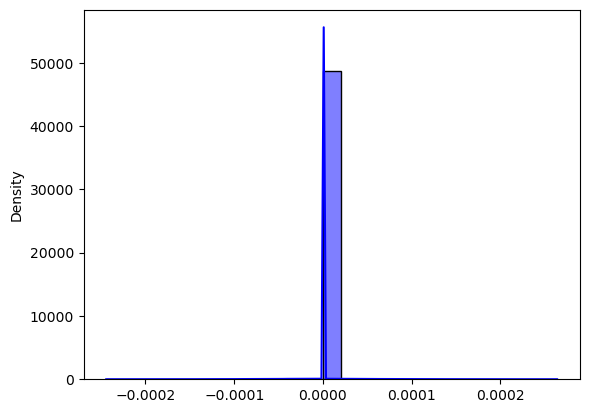

Thr = -0.0007362065461682625
Cluster size :  113564
> 0 :  56180 Max :  0.00026379345217719674
< 0 :  57384 Min :  -0.0002442508121021092
Max consensus :  1.6350951971202683e-11
Min consensus :  -1.4009095927318592e-11
Size consensus :  113564
[2.86851508]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.000594877656646598. But, you have given threshold=-0.0006091035512971403.
  warnings.warn(


-0.0006091035512971403
[1.3467251]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.000351792045444546. But, you have given threshold=-0.0007102008943856169.
  warnings.warn(


-0.0007102008943856169
[1.92740413]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0003611207527461352. But, you have given threshold=-0.0006896866729139607.
  warnings.warn(


-0.0006896866729139607
[0.56562534]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00028694094598549573. But, you have given threshold=-0.000730369300717474.
  warnings.warn(


-0.000730369300717474
[0.01581396]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00024332081169261017. But, you have given threshold=-0.0008006427748875186.
  warnings.warn(


-0.0008006427748875186
Size bagging :  113564
Size final cluster :  113564


/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


[0.31059522]
Smoothing :  3


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0005232716271120856. But, you have given threshold=-0.0005233426188985253.
  warnings.warn(


-0.0005233426188985253


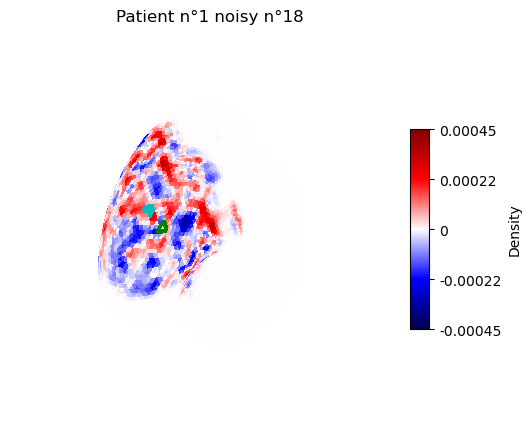

Thr = -0.0005233426188985253
Cluster size :  113548
> 0 :  53567 Max :  0.00047665738384239376
< 0 :  59981 Min :  -0.0005232716212049127
Smoothing :  9


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00014917983823513467. But, you have given threshold=-0.0008511767775482312.
  warnings.warn(


-0.0008511767775482312


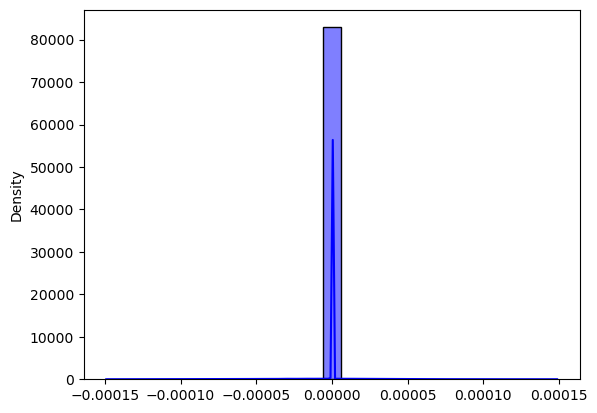

Thr = -0.0008511767775482312
Cluster size :  113564
> 0 :  48819 Max :  0.00014882322284393013
< 0 :  64745 Min :  -0.00014917983207851648
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00029583155726344853. But, you have given threshold=-0.000744640779750044.
  warnings.warn(


-0.000744640779750044


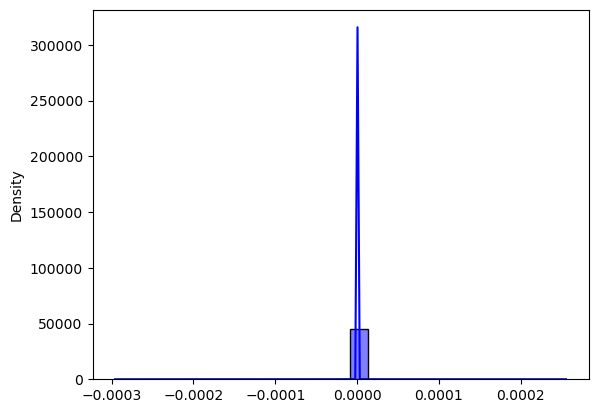

Thr = -0.000744640779750044
Cluster size :  113564
> 0 :  51438 Max :  0.00025535922031849623
< 0 :  62126 Min :  -0.0002958315599244088
Max consensus :  1.6149758251907958e-11
Min consensus :  -2.0552350301799485e-11
Size consensus :  113548
[1.42604148]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0004023969607824995. But, you have given threshold=-0.0006813292208928039.
  warnings.warn(


-0.0006813292208928039
[1.59976549]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0003553481645946426. But, you have given threshold=-0.0006446518354053574.
  warnings.warn(


-0.0006446518354053574
[0.03994309]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002634919425671907. But, you have given threshold=-0.0007365080574328092.
  warnings.warn(


-0.0007365080574328092
[2.09136631]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00034662145039754963. But, you have given threshold=-0.0006884949030920887.
  warnings.warn(


-0.0006884949030920887
[1.366081]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0003945421884240512. But, you have given threshold=-0.0006054578115759488.
  warnings.warn(


-0.0006054578115759488
Size bagging :  113564
Size final cluster :  113548


/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


[0.85626351]
Smoothing :  3
-0.0004845650918734654


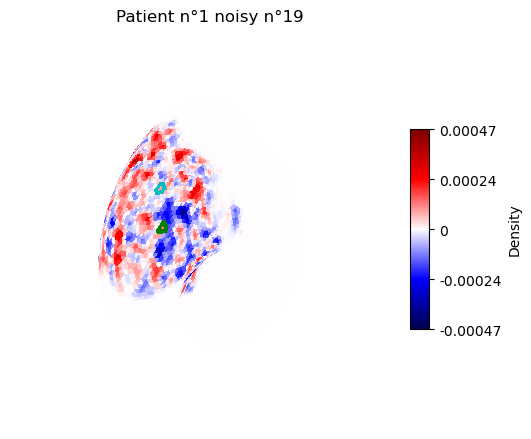

Thr = -0.0004845650918734654
Cluster size :  113559
> 0 :  51758 Max :  0.0005154348909854889
< 0 :  61801 Min :  -0.0004803306073881686
Smoothing :  9


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00018345204478816148. But, you have given threshold=-0.0008165479552118386.
  warnings.warn(


-0.0008165479552118386


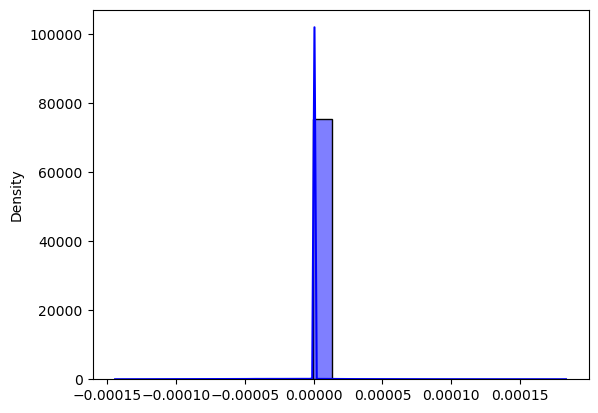

Thr = -0.0008165479552118386
Cluster size :  113564
> 0 :  44354 Max :  0.000183452051714994
< 0 :  69210 Min :  -0.0001444036461180076
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.000278530532393759. But, you have given threshold=-0.000721469467606241.
  warnings.warn(


-0.000721469467606241


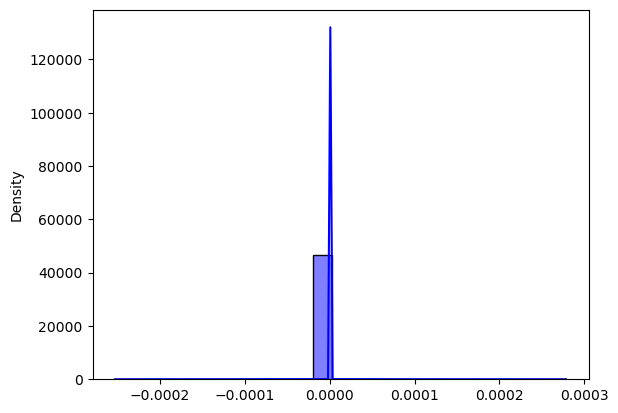

Thr = -0.000721469467606241
Cluster size :  113564
> 0 :  48582 Max :  0.00027853052597492933
< 0 :  64982 Min :  -0.00025300608831457794
Max consensus :  2.184984406371654e-11
Min consensus :  -1.5407916265708627e-11
Size consensus :  113559
[0.50535139]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002607033860360944. But, you have given threshold=-0.0008134481616368999.
  warnings.warn(


-0.0008134481616368999
[0.55399867]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00024444781236087514. But, you have given threshold=-0.0007555521876391249.
  warnings.warn(


-0.0007555521876391249
[0.1587266]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00025675249046212286. But, you have given threshold=-0.0007432475095378772.
  warnings.warn(


-0.0007432475095378772
[0.5079088]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0003117363499655073. But, you have given threshold=-0.0006882636500344928.
  warnings.warn(


-0.0006882636500344928
[0.1555131]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00025826266920924015. But, you have given threshold=-0.0007636337354866407.
  warnings.warn(


-0.0007636337354866407
Size bagging :  113564
Size final cluster :  113559


/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


[0.91657539]
Smoothing :  3


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00047031714665042264. But, you have given threshold=-0.0005317296679023405.
  warnings.warn(


-0.0005317296679023405


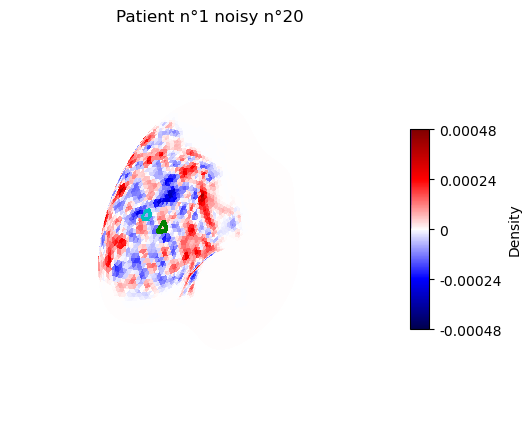

Thr = -0.0005317296679023405
Cluster size :  113564
> 0 :  50013 Max :  0.0004682703292928636
< 0 :  63551 Min :  -0.0004703171434812248
Smoothing :  9


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00015978999118406278. But, you have given threshold=-0.0008736556573212554.
  warnings.warn(


-0.0008736556573212554


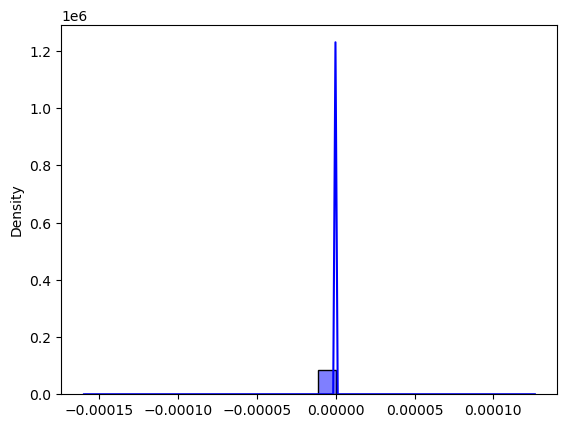

Thr = -0.0008736556573212554
Cluster size :  113564
> 0 :  41372 Max :  0.0001263443409698084
< 0 :  72192 Min :  -0.00015978999726939946
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002659332592759092. But, you have given threshold=-0.0007587737923461945.
  warnings.warn(


-0.0007587737923461945


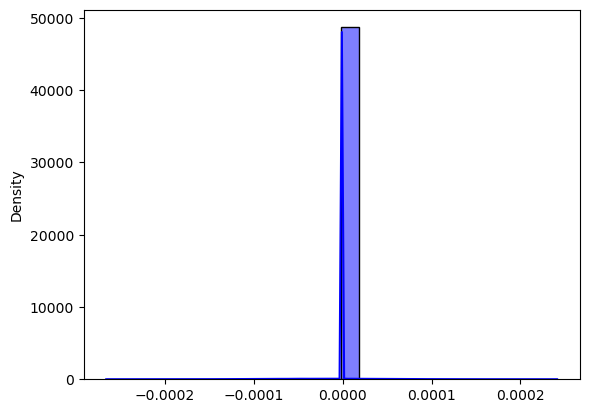

Thr = -0.0007587737923461945
Cluster size :  113564
> 0 :  45670 Max :  0.00024122621107380837
< 0 :  67894 Min :  -0.0002659332531038672
Max consensus :  1.2132963171432585e-11
Min consensus :  -1.796568914929825e-11
Size consensus :  113564
[1.76285847]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00037537789836031293. But, you have given threshold=-0.0006911209557130453.
  warnings.warn(


-0.0006911209557130453
[0.52073217]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.000270008366773522. But, you have given threshold=-0.000729991633226478.
  warnings.warn(


-0.000729991633226478
[1.09479437]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00031361485952646664. But, you have given threshold=-0.0007490928479527138.
  warnings.warn(


-0.0007490928479527138
[1.05542375]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00029372560599787146. But, you have given threshold=-0.0007431402078206713.
  warnings.warn(


-0.0007431402078206713
[0.05999527]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00026683420367028563. But, you have given threshold=-0.0007338210248098678.
  warnings.warn(


-0.0007338210248098678
Size bagging :  113564
Size final cluster :  113564


/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


[0.0332395]
Smoothing :  3


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0004719574237213427. But, you have given threshold=-0.0005280425762786573.
  warnings.warn(


-0.0005280425762786573


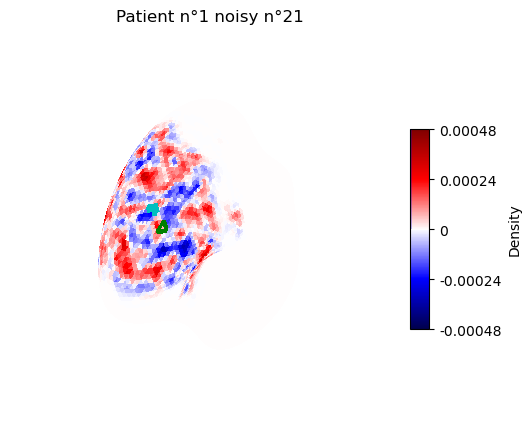

Thr = -0.0005280425762786573
Cluster size :  113564
> 0 :  59457 Max :  0.0004719574353657663
< 0 :  54107 Min :  -0.0003932019753847271
Smoothing :  9


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00015769250017901775. But, you have given threshold=-0.0008457623944264342.
  warnings.warn(


-0.0008457623944264342


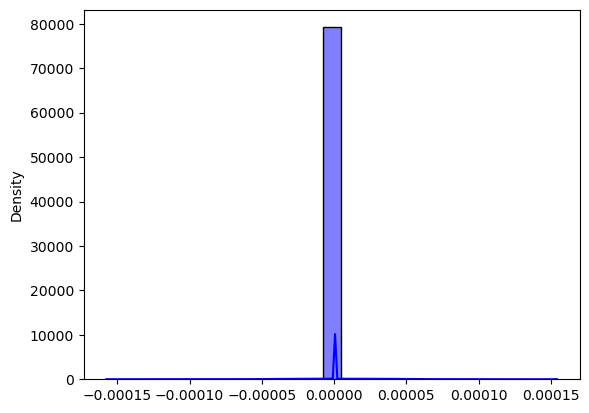

Thr = -0.0008457623944264342
Cluster size :  113564
> 0 :  63001 Max :  0.0001542376121506095
< 0 :  50563 Min :  -0.0001576924987602979
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002535224076856814. But, you have given threshold=-0.0007672035645633766.
  warnings.warn(


-0.0007672035645633766


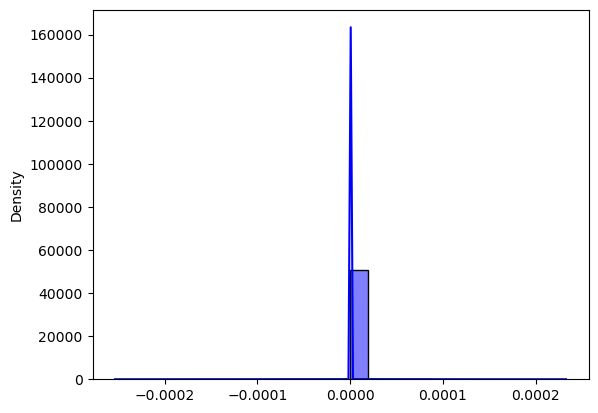

Thr = -0.0007672035645633766
Cluster size :  113564
> 0 :  61405 Max :  0.00023279643210116774
< 0 :  52159 Min :  -0.00025352241937071085
Max consensus :  1.290452363827613e-11
Min consensus :  -1.4835666263727503e-11
Size consensus :  113564
[0.42453154]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002404232558708754. But, you have given threshold=-0.0007643823265231107.
  warnings.warn(


-0.0007643823265231107
[0.779005]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002549158739424542. But, you have given threshold=-0.0007450841260575458.
  warnings.warn(


-0.0007450841260575458
[0.35111214]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.000256215602612427. But, you have given threshold=-0.0007886759853870371.
  warnings.warn(


-0.0007886759853870371
[0.11528816]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002785684399447133. But, you have given threshold=-0.0007214315600552867.
  warnings.warn(


-0.0007214315600552867
[0.46857693]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002631487096881232. But, you have given threshold=-0.0007368512903118768.
  warnings.warn(


-0.0007368512903118768
Size bagging :  113564
Size final cluster :  113564


/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


[1.77740006]
Smoothing :  3
-0.00020116811114383702


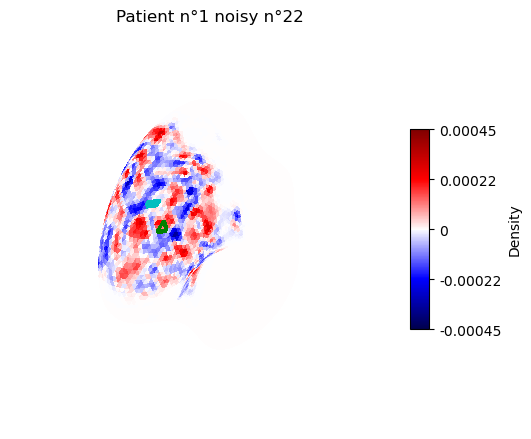

Thr = -0.00020116811114383702
Cluster size :  102663
> 0 :  55052 Max :  0.0007988318684510887
< 0 :  47611 Min :  -0.00020116643281653523
Smoothing :  9


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00023295493114776017. But, you have given threshold=-0.0007710452104409155.
  warnings.warn(


-0.0007710452104409155


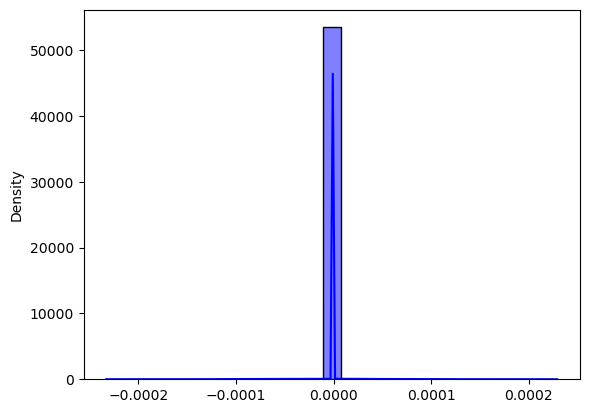

Thr = -0.0007710452104409155
Cluster size :  113564
> 0 :  51745 Max :  0.0002289547846885398
< 0 :  61819 Min :  -0.0002329549315618351
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00042475309151277386. But, you have given threshold=-0.0005752469084872262.
  warnings.warn(


-0.0005752469084872262


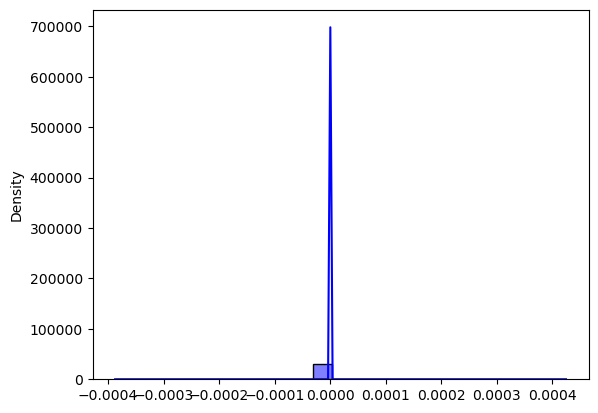

Thr = -0.0005752469084872262
Cluster size :  113564
> 0 :  53583 Max :  0.00042475308873690665
< 0 :  59981 Min :  -0.0003874485846608877
Max consensus :  7.66872894736564e-11
Min consensus :  -7.780922602451371e-12
Size consensus :  102663
[1.48595133]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00040192993603632417. But, you have given threshold=-0.0006706692955539092.
  warnings.warn(


-0.0006706692955539092
[1.12752932]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00033865187545698407. But, you have given threshold=-0.0007462501715377267.
  warnings.warn(


-0.0007462501715377267
[0.50629854]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002691949825109173. But, you have given threshold=-0.000737144688120508.
  warnings.warn(


-0.000737144688120508
[0.85303641]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00028257138677418816. But, you have given threshold=-0.0007174286132258119.
  warnings.warn(


-0.0007174286132258119
[1.20833823]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002807954216482202. But, you have given threshold=-0.0007336205619016753.
  warnings.warn(


-0.0007336205619016753
Size bagging :  113564
Size final cluster :  102663


/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


[1.44374653]
Smoothing :  3
-0.00044338122951787504


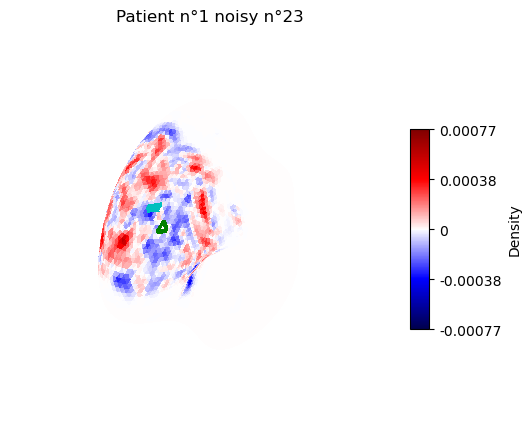

Thr = -0.00044338122951787504
Cluster size :  113310
> 0 :  49636 Max :  0.0005566187901422381
< 0 :  63674 Min :  -0.00044337575673125684
Smoothing :  9


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00021026461348541426. But, you have given threshold=-0.0008319378903190629.
  warnings.warn(


-0.0008319378903190629


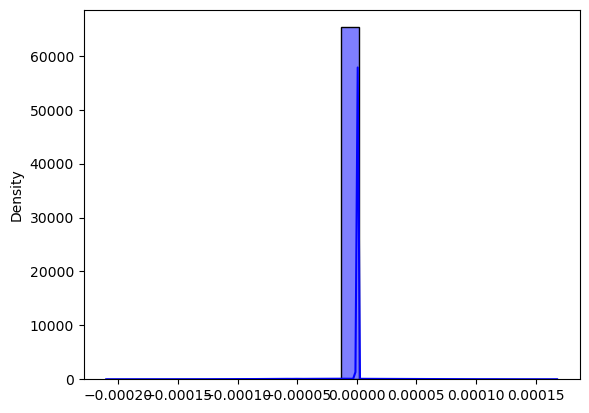

Thr = -0.0008319378903190629
Cluster size :  113564
> 0 :  40182 Max :  0.00016806210624054074
< 0 :  73382 Min :  -0.00021026461035944521
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00032246332666792003. But, you have given threshold=-0.000712131639129951.
  warnings.warn(


-0.000712131639129951


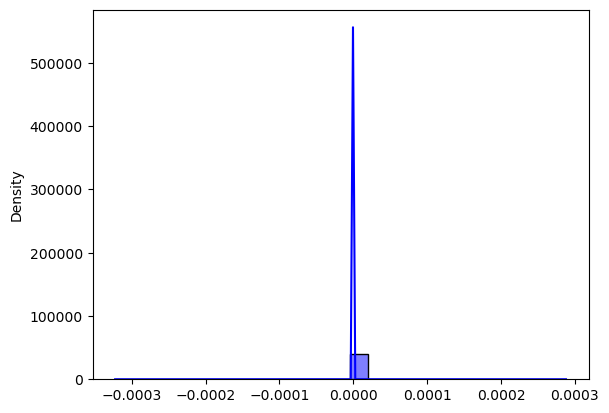

Thr = -0.000712131639129951
Cluster size :  113564
> 0 :  45226 Max :  0.0002878683735616505
< 0 :  68338 Min :  -0.000322463340125978
Max consensus :  2.5614194403609865e-11
Min consensus :  -2.8682734853356452e-11
Size consensus :  113310
[0.16670983]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002518451573259379. But, you have given threshold=-0.0007701710495547683.
  warnings.warn(


-0.0007701710495547683
[1.34879148]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002875154972967497. But, you have given threshold=-0.0007124845027032503.
  warnings.warn(


-0.0007124845027032503
[0.22913133]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00025723871009151675. But, you have given threshold=-0.0007498858054778908.
  warnings.warn(


-0.0007498858054778908
[0.12970218]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002717392650107026. But, you have given threshold=-0.0007282607349892974.
  warnings.warn(


-0.0007282607349892974
[0.46353397]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00020781346314461993. But, you have given threshold=-0.0008089328795860015.
  warnings.warn(


-0.0008089328795860015
Size bagging :  113564
Size final cluster :  113310


/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


[1.14648888]
Smoothing :  3
-0.0004995758808196966


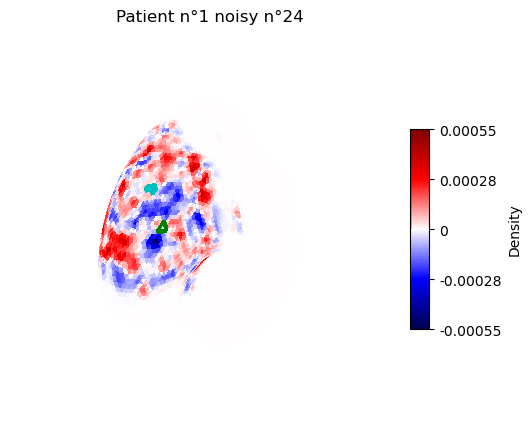

Thr = -0.0004995758808196966
Cluster size :  113502
> 0 :  49737 Max :  0.0005004241247661412
< 0 :  63765 Min :  -0.0004984373808838427
Smoothing :  9


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00020013504623482605. But, you have given threshold=-0.0008501686220416703.
  warnings.warn(


-0.0008501686220416703


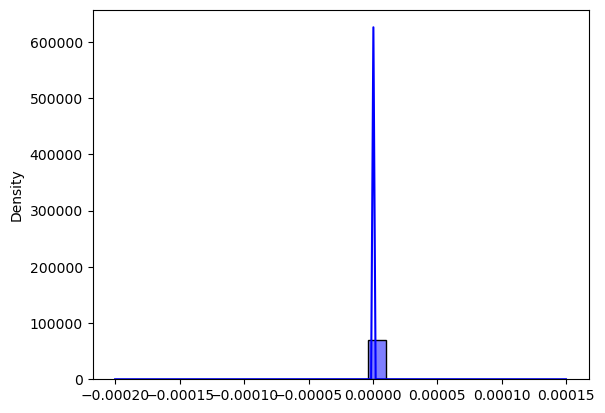

Thr = -0.0008501686220416703
Cluster size :  113564
> 0 :  42392 Max :  0.00014983137953095138
< 0 :  71172 Min :  -0.0002001350512728095
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00033988790989995826. But, you have given threshold=-0.0007392777156180917.
  warnings.warn(


-0.0007392777156180917


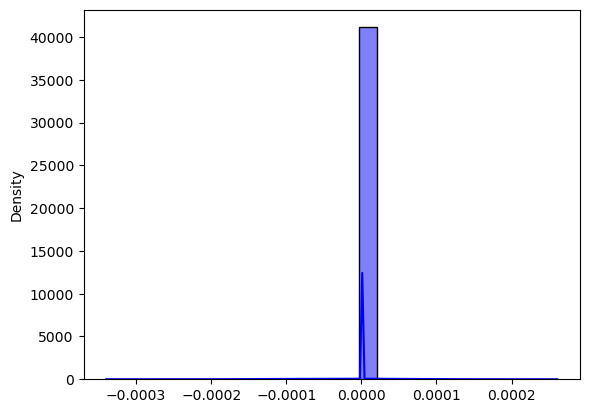

Thr = -0.0007392777156180917
Cluster size :  113564
> 0 :  46812 Max :  0.0002607222704682499
< 0 :  66752 Min :  -0.0003398879198357463
Max consensus :  1.5776465360090117e-11
Min consensus :  -3.136112180917182e-11
Size consensus :  113502
[0.00116595]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00022931684876545622. But, you have given threshold=-0.0007902389820456117.
  warnings.warn(


-0.0007902389820456117
[1.01605848]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00031275733564100857. But, you have given threshold=-0.0006872426643589914.
  warnings.warn(


-0.0006872426643589914
[0.43655089]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00023746943180785935. But, you have given threshold=-0.0007949035685362461.
  warnings.warn(


-0.0007949035685362461
[0.40990348]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002710891890086003. But, you have given threshold=-0.0007289108109913997.
  warnings.warn(


-0.0007289108109913997
[0.79919407]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002856000362584506. But, you have given threshold=-0.0007143999637415493.
  warnings.warn(


-0.0007143999637415493
Size bagging :  113564
Size final cluster :  113502


/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


[0.34404332]
Smoothing :  3


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.000471835402865011. But, you have given threshold=-0.000557564762549425.
  warnings.warn(


-0.000557564762549425


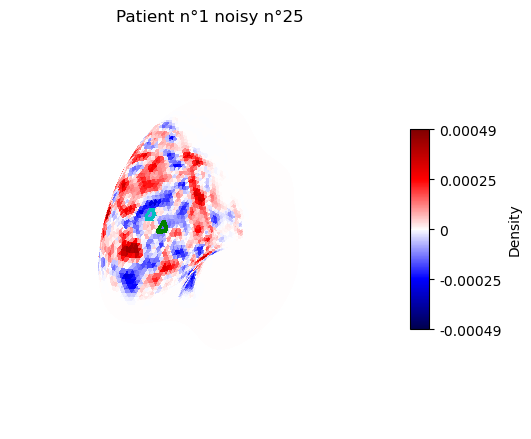

Thr = -0.000557564762549425
Cluster size :  113564
> 0 :  57318 Max :  0.00044243523734621704
< 0 :  56246 Min :  -0.0004718354030046612
Smoothing :  9


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00017568266044323057. But, you have given threshold=-0.0008243173395567694.
  warnings.warn(


-0.0008243173395567694


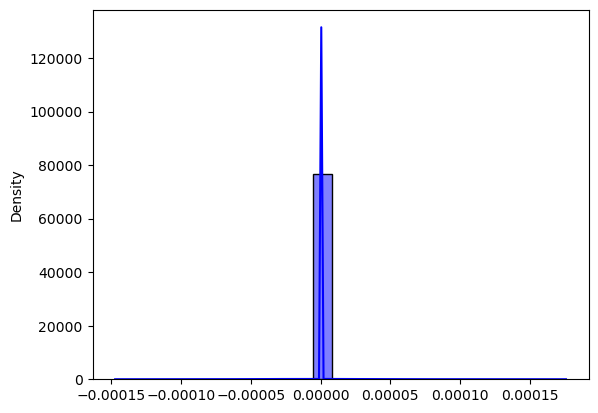

Thr = -0.0008243173395567694
Cluster size :  113564
> 0 :  57572 Max :  0.0001756826532073319
< 0 :  55992 Min :  -0.0001471243886044249
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00026946809949950133. But, you have given threshold=-0.0007305319005004987.
  warnings.warn(


-0.0007305319005004987


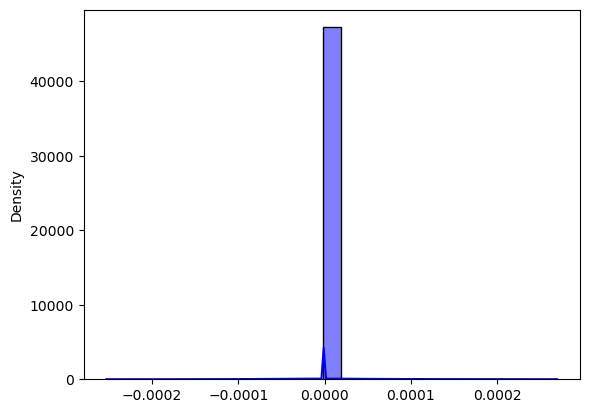

Thr = -0.0007305319005004987
Cluster size :  113564
> 0 :  56869 Max :  0.0002694680879358202
< 0 :  56695 Min :  -0.00025329255731776357
Max consensus :  1.7891381652929725e-11
Min consensus :  -1.6408828284838545e-11
Size consensus :  113564
[0.95299282]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00025681478345721643. But, you have given threshold=-0.0007431852165427836.
  warnings.warn(


-0.0007431852165427836
[1.37721335]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002763702741890333. But, you have given threshold=-0.0007405411939601121.
  warnings.warn(


-0.0007405411939601121
[1.92211529]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0003829525100059278. But, you have given threshold=-0.0006591259736043827.
  warnings.warn(


-0.0006591259736043827
[0.30519941]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002563891843301063. But, you have given threshold=-0.0007436108156698937.
  warnings.warn(


-0.0007436108156698937
[0.31288829]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00023916050388290015. But, you have given threshold=-0.0007608394961170999.
  warnings.warn(


-0.0007608394961170999
Size bagging :  113564
Size final cluster :  113564


/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


[0.33647891]
Smoothing :  3


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00047040831591848296. But, you have given threshold=-0.0005727085528858943.
  warnings.warn(


-0.0005727085528858943


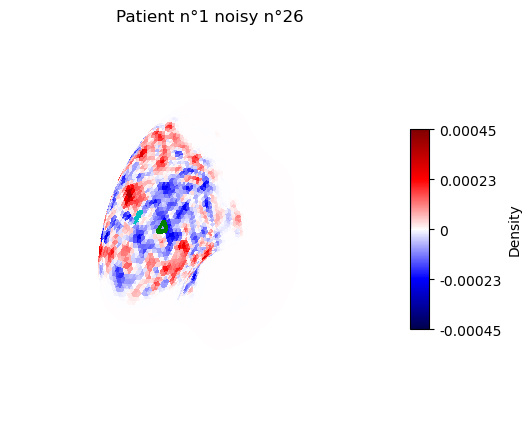

Thr = -0.0005727085528858943
Cluster size :  113564
> 0 :  57754 Max :  0.0004272914375178516
< 0 :  55810 Min :  -0.0004704083257820457
Smoothing :  9


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00012738373328352148. But, you have given threshold=-0.0008837497724783176.
  warnings.warn(


-0.0008837497724783176


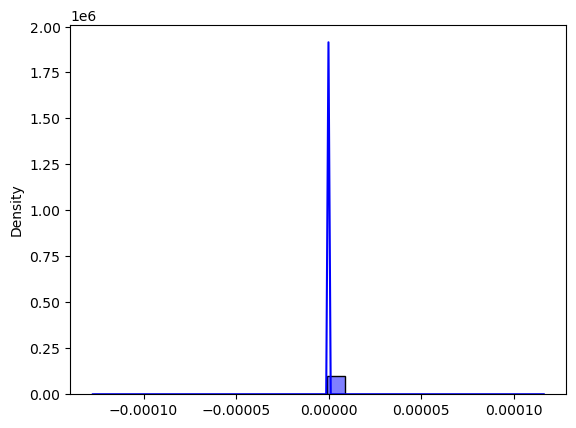

Thr = -0.0008837497724783176
Cluster size :  113564
> 0 :  56472 Max :  0.00011625023034866899
< 0 :  57092 Min :  -0.00012738372606690973
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00025909459627588644. But, you have given threshold=-0.0007670244194783162.
  warnings.warn(


-0.0007670244194783162


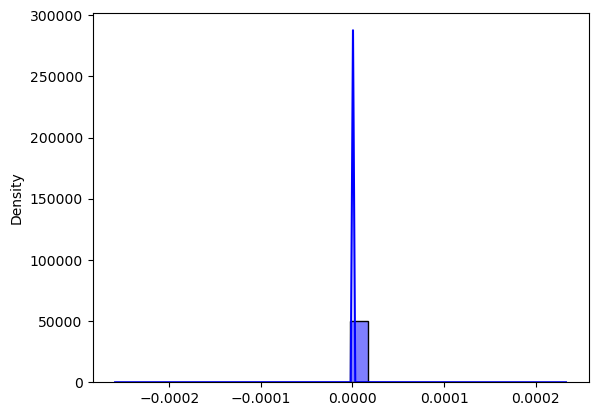

Thr = -0.0007670244194783162
Cluster size :  113564
> 0 :  57175 Max :  0.00023297558072954416
< 0 :  56389 Min :  -0.00025909460964612663
Max consensus :  1.1022964885258264e-11
Min consensus :  -1.4172449612094959e-11
Size consensus :  113564
[0.65591815]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00024991280904396244. But, you have given threshold=-0.0007659090663961813.
  warnings.warn(


-0.0007659090663961813
[0.77069137]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00026331872189854774. But, you have given threshold=-0.0007366812781014523.
  warnings.warn(


-0.0007366812781014523
[0.04293683]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00025427813522140903. But, you have given threshold=-0.0007457218647785909.
  warnings.warn(


-0.0007457218647785909
[0.42908279]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002621893284465184. But, you have given threshold=-0.0007378106715534816.
  warnings.warn(


-0.0007378106715534816
[0.67517831]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002998512616704909. But, you have given threshold=-0.0007584131192776707.
  warnings.warn(


-0.0007584131192776707
Size bagging :  113564
Size final cluster :  113564


/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


[0.90267078]
Smoothing :  3


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0005088109498457937. But, you have given threshold=-0.000514359720318535.
  warnings.warn(


-0.000514359720318535


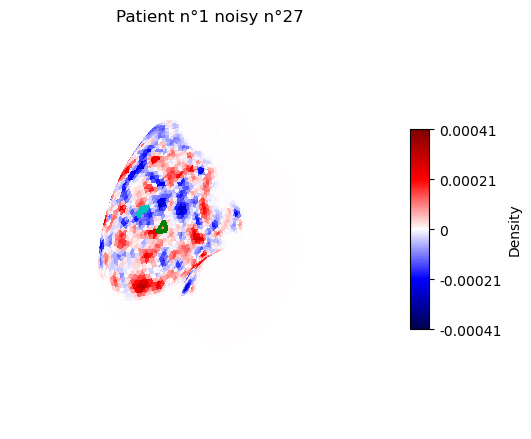

Thr = -0.000514359720318535
Cluster size :  113564
> 0 :  54586 Max :  0.0004856402811128646
< 0 :  58978 Min :  -0.0005088109755888581
Smoothing :  9


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00018327096268487238. But, you have given threshold=-0.0008167290373151276.
  warnings.warn(


-0.0008167290373151276


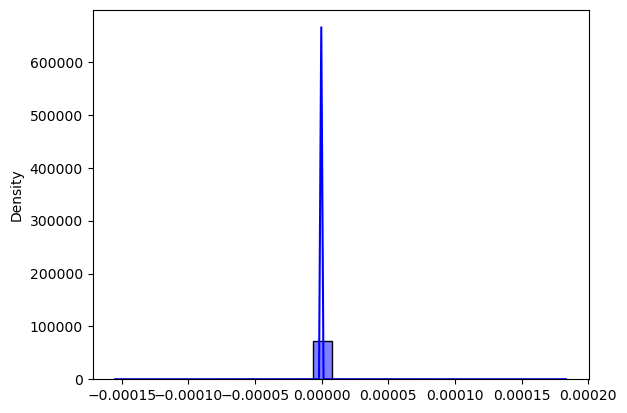

Thr = -0.0008167290373151276
Cluster size :  113564
> 0 :  55099 Max :  0.00018327096768189222
< 0 :  58465 Min :  -0.00015503857866860926
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0003077273266231369. But, you have given threshold=-0.0006922726733768631.
  warnings.warn(


-0.0006922726733768631


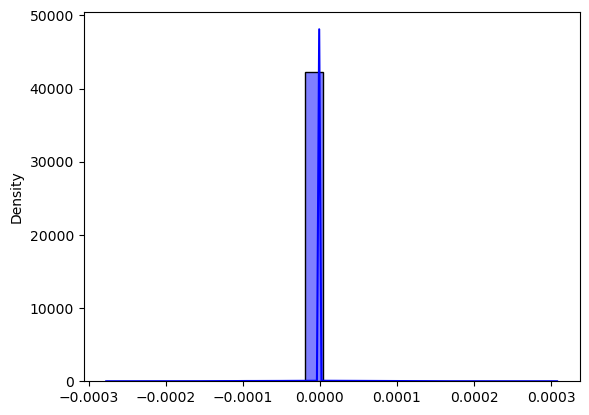

Thr = -0.0006922726733768631
Cluster size :  113564
> 0 :  54637 Max :  0.00030772731406614184
< 0 :  58927 Min :  -0.0002772683510556817
Max consensus :  2.707856504579733e-11
Min consensus :  -2.140628342803285e-11
Size consensus :  113564
[1.65573385]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0003092377423713053. But, you have given threshold=-0.0007441559803667502.
  warnings.warn(


-0.0007441559803667502
[1.17278554]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00035139791012787664. But, you have given threshold=-0.0006486020898721234.
  warnings.warn(


-0.0006486020898721234
[0.66268383]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00033648833480822245. But, you have given threshold=-0.0007473434627651117.
  warnings.warn(


-0.0007473434627651117
[0.10181736]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002607751288218977. But, you have given threshold=-0.0007392248711781023.
  warnings.warn(


-0.0007392248711781023
[1.14052198]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0003119286085697515. But, you have given threshold=-0.0006880713914302485.
  warnings.warn(


-0.0006880713914302485
Size bagging :  113564
Size final cluster :  113564


/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


[0.74813216]
Smoothing :  3


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0005652683334785778. But, you have given threshold=-0.000568076175695788.
  warnings.warn(


-0.000568076175695788


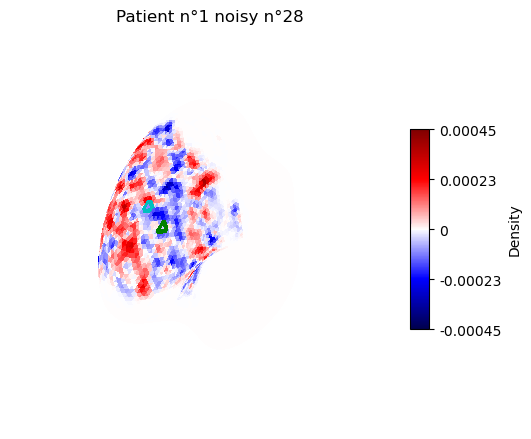

Thr = -0.000568076175695788
Cluster size :  113564
> 0 :  56052 Max :  0.000431923836003989
< 0 :  57512 Min :  -0.0005652683321386576
Smoothing :  9


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00015555700332340946. But, you have given threshold=-0.0008510364802333074.
  warnings.warn(


-0.0008510364802333074


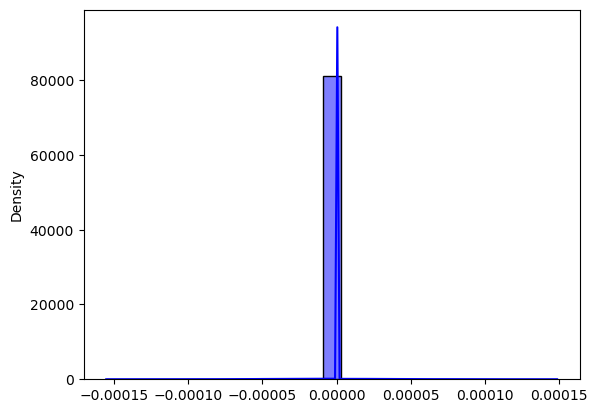

Thr = -0.0008510364802333074
Cluster size :  113564
> 0 :  55243 Max :  0.0001489635178586468
< 0 :  58321 Min :  -0.00015555700520053506
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00029493626101966246. But, you have given threshold=-0.0007632724035024426.
  warnings.warn(


-0.0007632724035024426


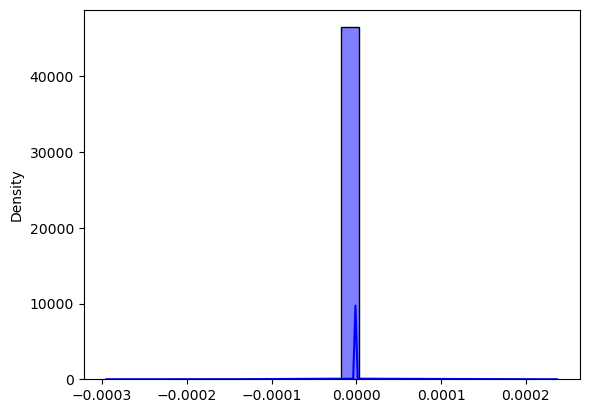

Thr = -0.0007632724035024426
Cluster size :  113564
> 0 :  55297 Max :  0.0002367276028962806
< 0 :  58267 Min :  -0.00029493626789189875
Max consensus :  1.3101008789552862e-11
Min consensus :  -2.5932829321898107e-11
Size consensus :  113564
[2.66598613]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.000494560662372766. But, you have given threshold=-0.0006010911373518603.
  warnings.warn(


-0.0006010911373518603
[0.53091299]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00028115488937274037. But, you have given threshold=-0.0007285918614570892.
  warnings.warn(


-0.0007285918614570892
[1.38565677]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00029775478326797024. But, you have given threshold=-0.0007136997798933445.
  warnings.warn(


-0.0007136997798933445
[1.23392711]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002842126699610679. But, you have given threshold=-0.0007175827071489714.
  warnings.warn(


-0.0007175827071489714
[0.56523298]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002609630541064599. But, you have given threshold=-0.0007548421482014893.
  warnings.warn(


-0.0007548421482014893
Size bagging :  113564
Size final cluster :  113564


/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


[0.49810211]
Smoothing :  3


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0004882336503587769. But, you have given threshold=-0.0005117663496412232.
  warnings.warn(


-0.0005117663496412232


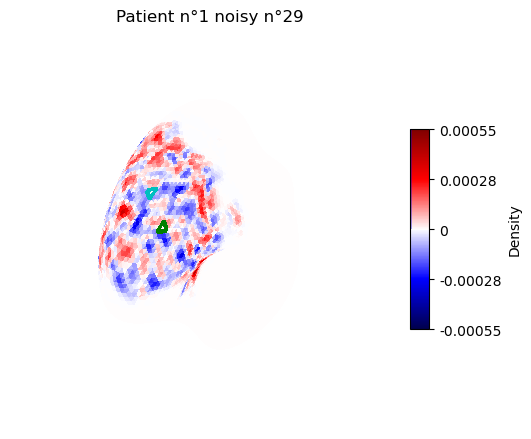

Thr = -0.0005117663496412232
Cluster size :  113564
> 0 :  51097 Max :  0.0004882336361333728
< 0 :  62467 Min :  -0.0004313835524953902
Smoothing :  9


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00016117818290185975. But, you have given threshold=-0.0008609969835036496.
  warnings.warn(


-0.0008609969835036496


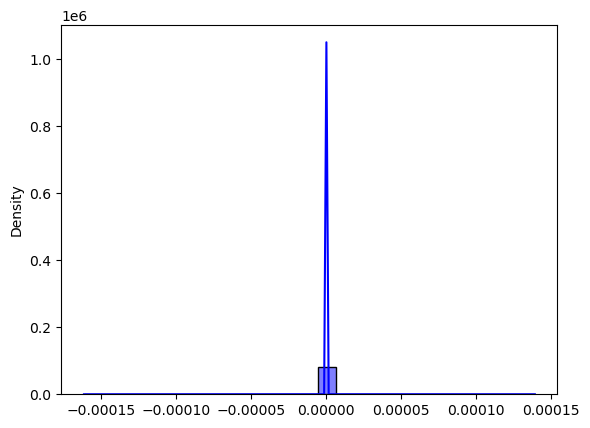

Thr = -0.0008609969835036496
Cluster size :  113564
> 0 :  41696 Max :  0.00013900302292313427
< 0 :  71868 Min :  -0.00016117817722260952
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.000256259666251602. But, you have given threshold=-0.0007674799194851724.
  warnings.warn(


-0.0007674799194851724


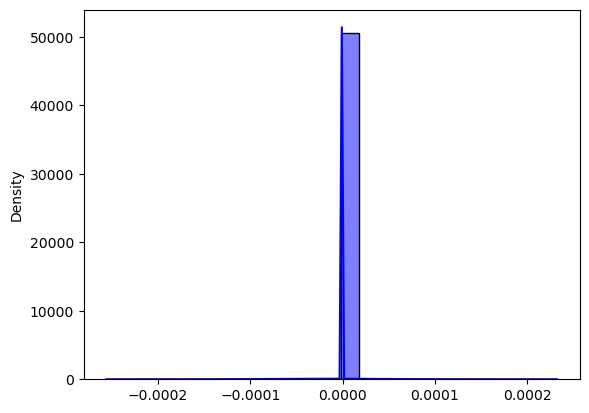

Thr = -0.0007674799194851724
Cluster size :  113564
> 0 :  46936 Max :  0.00023252007667906582
< 0 :  66628 Min :  -0.0002562596637289971
Max consensus :  1.21745248733005e-11
Min consensus :  -1.6123013659367327e-11
Size consensus :  113564
[0.02649139]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002708163595178659. But, you have given threshold=-0.0007291836404821341.
  warnings.warn(


-0.0007291836404821341
[1.57257308]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.000396026208130069. But, you have given threshold=-0.000628621249083752.
  warnings.warn(


-0.000628621249083752
[0.15692854]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00027858691711153384. But, you have given threshold=-0.0007214130828884662.
  warnings.warn(


-0.0007214130828884662
[1.00373191]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002734525777890077. But, you have given threshold=-0.0007265474222109923.
  warnings.warn(


-0.0007265474222109923
[0.44787945]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00023325081590801425. But, you have given threshold=-0.0007842827788202684.
  warnings.warn(


-0.0007842827788202684
Size bagging :  113564
Size final cluster :  113564


/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


[1.70515095]
Smoothing :  3
-0.00041294426347225285


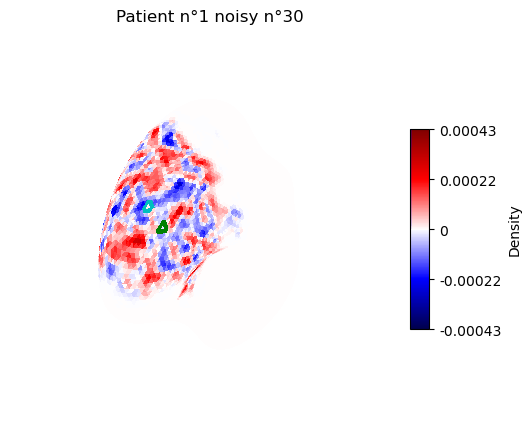

Thr = -0.00041294426347225285
Cluster size :  113025
> 0 :  51609 Max :  0.000587055750656873
< 0 :  61416 Min :  -0.00041272255475632846
Smoothing :  9


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00022080302541637383. But, you have given threshold=-0.0007791969745836262.
  warnings.warn(


-0.0007791969745836262


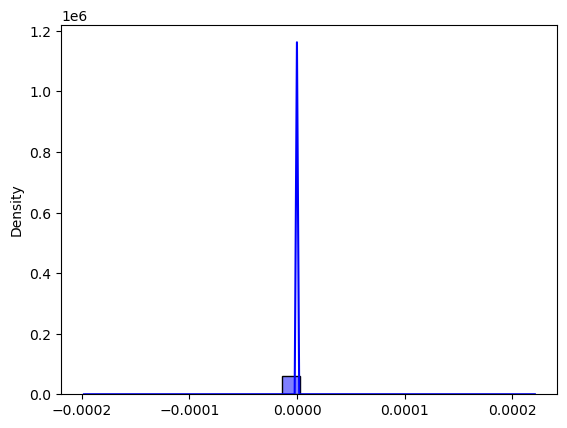

Thr = -0.0007791969745836262
Cluster size :  113564
> 0 :  43616 Max :  0.00022080302005633712
< 0 :  69948 Min :  -0.00019780862203333527
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00036310960515501065. But, you have given threshold=-0.0006368903948449894.
  warnings.warn(


-0.0006368903948449894


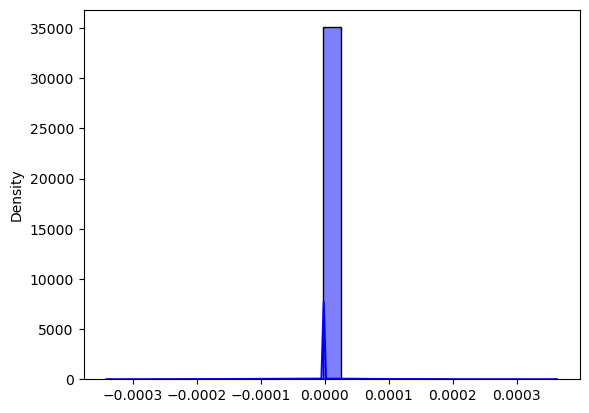

Thr = -0.0006368903948449894
Cluster size :  113564
> 0 :  48835 Max :  0.0003631096042227
< 0 :  64729 Min :  -0.0003411782381590456
Max consensus :  4.258097372714674e-11
Min consensus :  -2.2029387845820167e-11
Size consensus :  113025
[0.42331646]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00028097561785230836. But, you have given threshold=-0.0007935857767256733.
  warnings.warn(


-0.0007935857767256733
[0.47172831]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00025332912667403774. But, you have given threshold=-0.0008013386513385563.
  warnings.warn(


-0.0008013386513385563
[0.09251812]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002821644884316745. But, you have given threshold=-0.0007178355115683255.
  warnings.warn(


-0.0007178355115683255
[0.00742811]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002968063969084144. But, you have given threshold=-0.000759112809641334.
  warnings.warn(


-0.000759112809641334
[0.04203799]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00027167619622361645. But, you have given threshold=-0.0007436942357111814.
  warnings.warn(


-0.0007436942357111814
Size bagging :  113564
Size final cluster :  113025


/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


[0.02435597]
Smoothing :  3


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00044883868116971483. But, you have given threshold=-0.0005511613188302852.
  warnings.warn(


-0.0005511613188302852


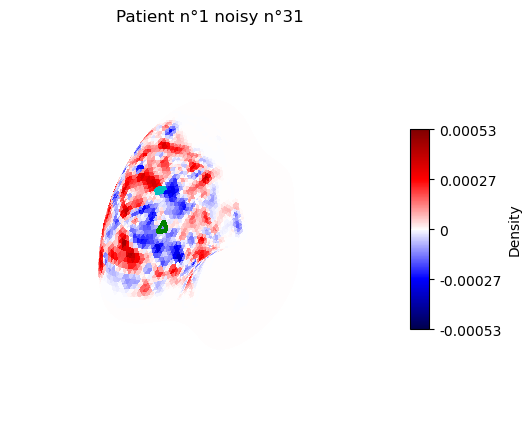

Thr = -0.0005511613188302852
Cluster size :  113564
> 0 :  57050 Max :  0.00044883869122713804
< 0 :  56514 Min :  -0.000439281779108569
Smoothing :  9


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00013522183467121527. But, you have given threshold=-0.0008648872317824892.
  warnings.warn(


-0.0008648872317824892


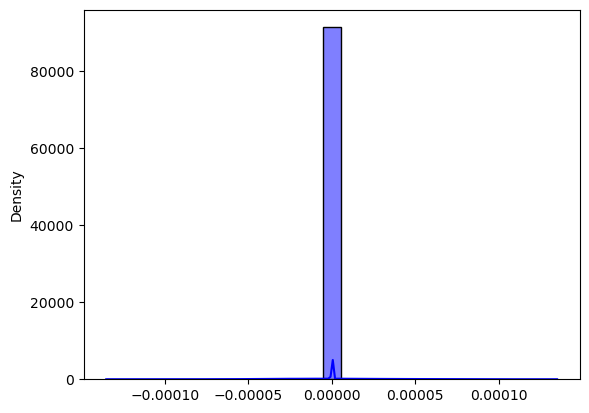

Thr = -0.0008648872317824892
Cluster size :  113564
> 0 :  54394 Max :  0.0001351127721136436
< 0 :  59170 Min :  -0.0001352218387182802
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00023943940633882878. But, you have given threshold=-0.0007673373521278952.
  warnings.warn(


-0.0007673373521278952


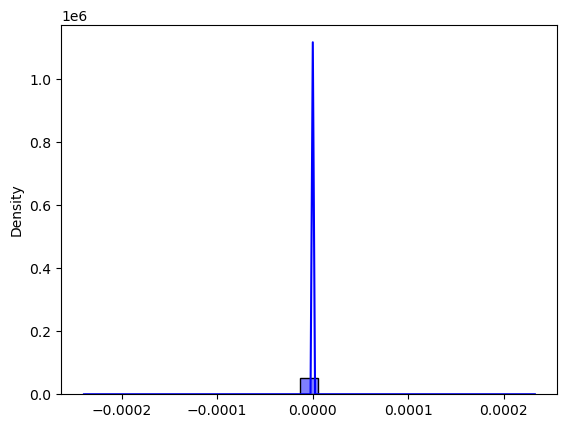

Thr = -0.0007673373521278952
Cluster size :  113564
> 0 :  55608 Max :  0.00023266264179255813
< 0 :  57956 Min :  -0.00023943941050674766
Max consensus :  1.2970258112545986e-11
Min consensus :  -1.2508209528185933e-11
Size consensus :  113564
[0.23149332]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002765120139942852. But, you have given threshold=-0.0007746596025516474.
  warnings.warn(


-0.0007746596025516474
[0.701623]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00026843763726635834. But, you have given threshold=-0.0007315623627336417.
  warnings.warn(


-0.0007315623627336417
[0.32915696]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00023053480642720492. But, you have given threshold=-0.0007874231882616612.
  warnings.warn(


-0.0007874231882616612
[1.26469]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00030699491651432905. But, you have given threshold=-0.0007126117565059932.
  warnings.warn(


-0.0007126117565059932
[0.29902592]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00024450288020046315. But, you have given threshold=-0.0007705643738750102.
  warnings.warn(


-0.0007705643738750102
Size bagging :  113564
Size final cluster :  113564


/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


[0.97608466]
Smoothing :  3
-0.00047023094491684906


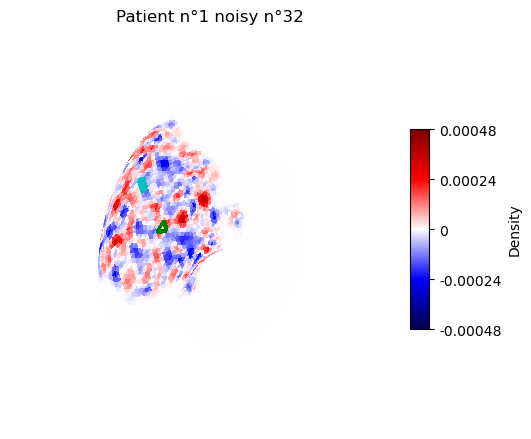

Thr = -0.00047023094491684906
Cluster size :  113563
> 0 :  56206 Max :  0.0005297690513543785
< 0 :  57357 Min :  -0.0004666781169362366
Smoothing :  9


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00016090633145094934. But, you have given threshold=-0.0008390936685490507.
  warnings.warn(


-0.0008390936685490507


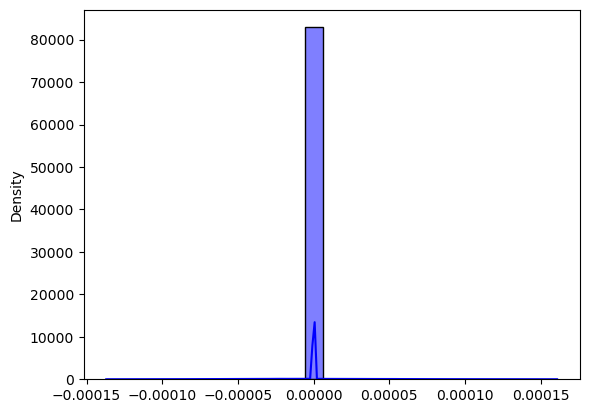

Thr = -0.0008390936685490507
Cluster size :  113564
> 0 :  53838 Max :  0.0001609063328942284
< 0 :  59726 Min :  -0.0001369934034300968
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002706219423971234. But, you have given threshold=-0.0007293780576028766.
  warnings.warn(


-0.0007293780576028766


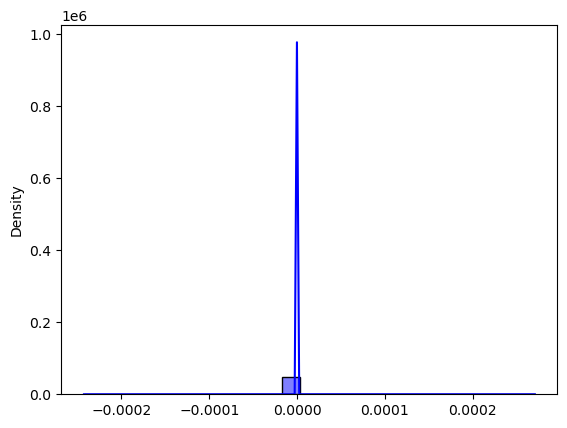

Thr = -0.0007293780576028766
Cluster size :  113564
> 0 :  55117 Max :  0.0002706219383981079
< 0 :  58447 Min :  -0.00024258102348539978
Max consensus :  2.1519170690337315e-11
Min consensus :  -1.3013699128578368e-11
Size consensus :  113563
[1.35125039]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0003547081723354792. But, you have given threshold=-0.0007068176129457064.
  warnings.warn(


-0.0007068176129457064
[0.56006334]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002889482788888792. But, you have given threshold=-0.0007110517211111208.
  warnings.warn(


-0.0007110517211111208
[0.0251933]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00027291464903414557. But, you have given threshold=-0.000801746714433833.
  warnings.warn(


-0.000801746714433833
[0.62137918]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002877711419951852. But, you have given threshold=-0.0007122288580048148.
  warnings.warn(


-0.0007122288580048148
[0.66985509]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00023323423543574758. But, you have given threshold=-0.0007667657645642524.
  warnings.warn(


-0.0007667657645642524
Size bagging :  113564
Size final cluster :  113563


/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


[0.45876746]
Smoothing :  3


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0004905848370883798. But, you have given threshold=-0.0005503319292818156.
  warnings.warn(


-0.0005503319292818156


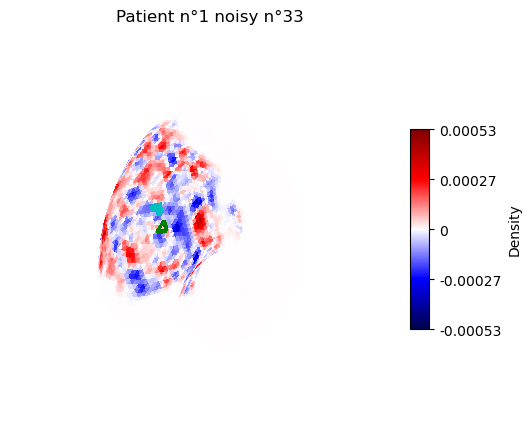

Thr = -0.0005503319292818156
Cluster size :  113564
> 0 :  52025 Max :  0.0004496680630836636
< 0 :  61539 Min :  -0.0004905848181806505
Smoothing :  9


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00013183753618247151. But, you have given threshold=-0.0009026967681676089.
  warnings.warn(


-0.0009026967681676089


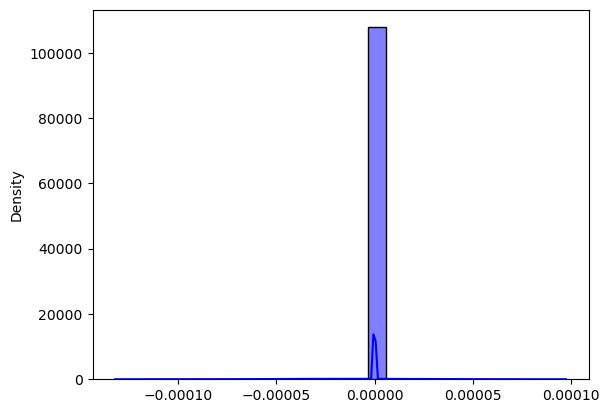

Thr = -0.0009026967681676089
Cluster size :  113564
> 0 :  43484 Max :  9.730322926770896e-05
< 0 :  70080 Min :  -0.0001318375434493646
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00024644710132476434. But, you have given threshold=-0.0007805679977916655.
  warnings.warn(


-0.0007805679977916655


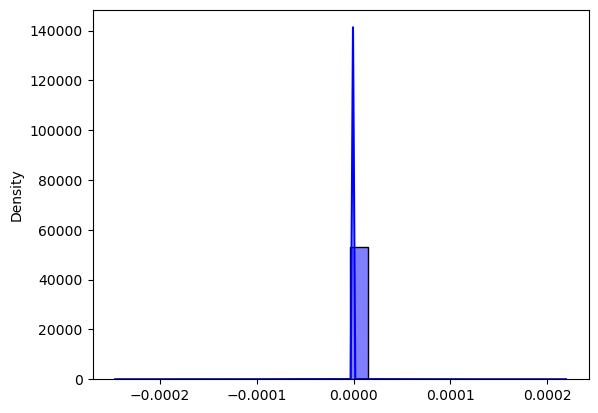

Thr = -0.0007805679977916655
Cluster size :  113564
> 0 :  48567 Max :  0.0002194319968111813
< 0 :  64997 Min :  -0.00024644710356369615
Max consensus :  8.290907270851225e-12
Min consensus :  -1.4156668555899443e-11
Size consensus :  113564
[0.80043768]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00029973263951569304. But, you have given threshold=-0.0007582511303063227.
  warnings.warn(


-0.0007582511303063227
[0.01126304]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00023229665178136965. But, you have given threshold=-0.0007677033482186304.
  warnings.warn(


-0.0007677033482186304
[0.15242493]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002548442634675533. But, you have given threshold=-0.0007884767620732155.
  warnings.warn(


-0.0007884767620732155
[1.08832007]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00028443580131154347. But, you have given threshold=-0.0007155641986884566.
  warnings.warn(


-0.0007155641986884566
[1.34629954]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00032045324940348756. But, you have given threshold=-0.0006795467505965125.
  warnings.warn(


-0.0006795467505965125
Size bagging :  113564
Size final cluster :  113564


/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


[1.04365723]
Smoothing :  3
-0.0003848427970500963


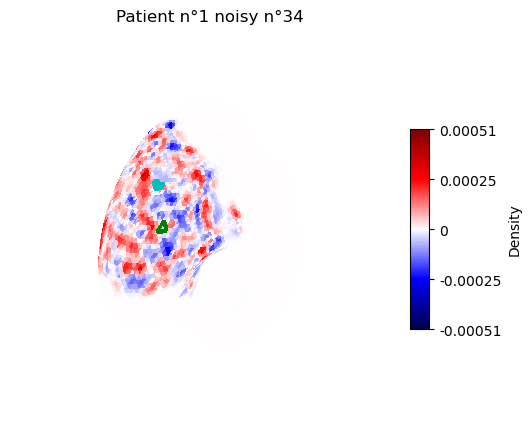

Thr = -0.0003848427970500963
Cluster size :  113354
> 0 :  50376 Max :  0.0006151571869850159
< 0 :  62978 Min :  -0.00038464664248749614
Smoothing :  9


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00018252433341049964. But, you have given threshold=-0.0008174756665895004.
  warnings.warn(


-0.0008174756665895004


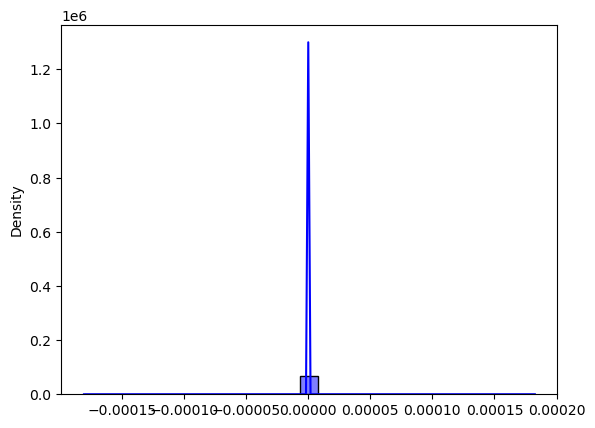

Thr = -0.0008174756665895004
Cluster size :  113564
> 0 :  44307 Max :  0.00018252433801535517
< 0 :  69257 Min :  -0.00018040399299934506
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00033895771459114675. But, you have given threshold=-0.0006610422854088533.
  warnings.warn(


-0.0006610422854088533


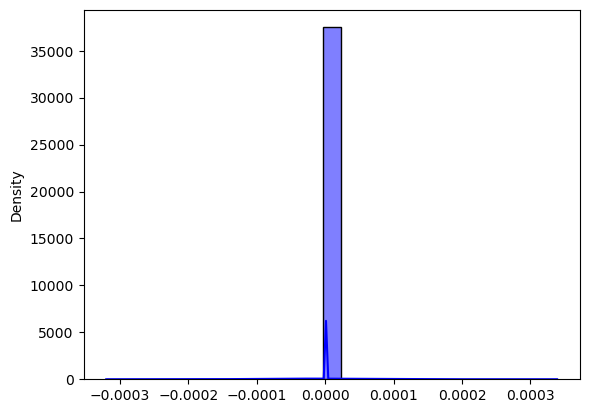

Thr = -0.0006610422854088533
Cluster size :  113564
> 0 :  47029 Max :  0.00033895770320668817
< 0 :  66535 Min :  -0.0003200046194251627
Max consensus :  3.8058563540865026e-11
Min consensus :  -1.720143617045451e-11
Size consensus :  113354
[0.35074312]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00028051819618141313. But, you have given threshold=-0.0007749233664562428.
  warnings.warn(


-0.0007749233664562428
[0.12556147]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002513302850119972. But, you have given threshold=-0.0007789160731728254.
  warnings.warn(


-0.0007789160731728254
[1.0996631]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0003210804388711249. But, you have given threshold=-0.0006789195611288752.
  warnings.warn(


-0.0006789195611288752
[0.72087642]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00023728649976056178. But, you have given threshold=-0.0007627135002394382.
  warnings.warn(


-0.0007627135002394382
[0.28023943]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00023603804150361938. But, you have given threshold=-0.0007639619584963806.
  warnings.warn(


-0.0007639619584963806
Size bagging :  113564
Size final cluster :  113354


/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


[1.03802455]
Smoothing :  3
-0.0004731548270267862


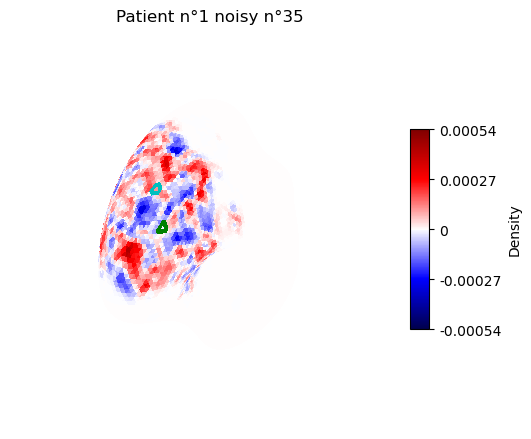

Thr = -0.0004731548270267862
Cluster size :  113443
> 0 :  53877 Max :  0.0005268451641313732
< 0 :  59566 Min :  -0.00047277857083827257
Smoothing :  9


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00023139322451949968. But, you have given threshold=-0.0008463994831544994.
  warnings.warn(


-0.0008463994831544994


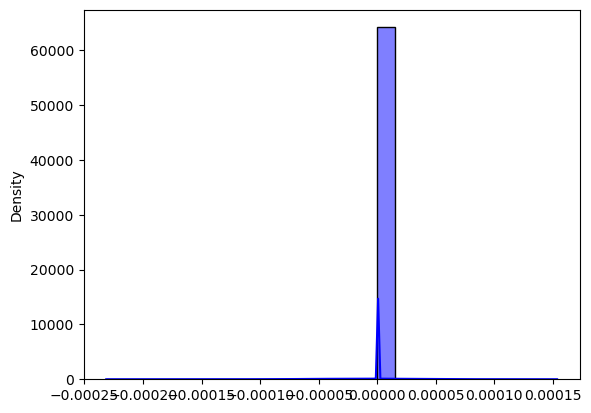

Thr = -0.0008463994831544994
Cluster size :  113564
> 0 :  48242 Max :  0.00015360051474999636
< 0 :  65322 Min :  -0.00023139322001952678
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00033707950259520927. But, you have given threshold=-0.0007149410048849744.
  warnings.warn(


-0.0007149410048849744


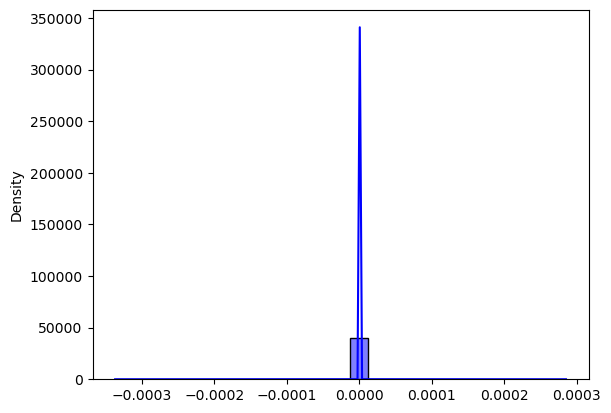

Thr = -0.0007149410048849744
Cluster size :  113564
> 0 :  51697 Max :  0.000285058980807662
< 0 :  61867 Min :  -0.0003370795166119933
Max consensus :  2.2132701375142406e-11
Min consensus :  -3.458990356872452e-11
Size consensus :  113443
[0.8084085]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00029162045265185337. But, you have given threshold=-0.000767349531257918.
  warnings.warn(


-0.000767349531257918
[0.03433029]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00034181610115976014. But, you have given threshold=-0.0007735341083679656.
  warnings.warn(


-0.0007735341083679656
[0.44358381]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00027508520139286305. But, you have given threshold=-0.0007249147986071369.
  warnings.warn(


-0.0007249147986071369
[1.13450439]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00029130798384451354. But, you have given threshold=-0.0007121922789645879.
  warnings.warn(


-0.0007121922789645879
[0.31267487]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002652196546745557. But, you have given threshold=-0.000790884471988625.
  warnings.warn(


-0.000790884471988625
Size bagging :  113564
Size final cluster :  113443


/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


[1.66084507]
Smoothing :  3
-0.0004389735658039081


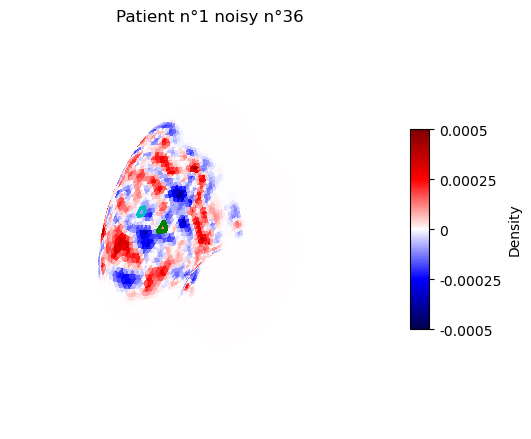

Thr = -0.0004389735658039081
Cluster size :  113385
> 0 :  53419 Max :  0.0005610264488495886
< 0 :  59966 Min :  -0.00043888718937523663
Smoothing :  9


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002440338443933297. But, you have given threshold=-0.0007968057970004787.
  warnings.warn(


-0.0007968057970004787


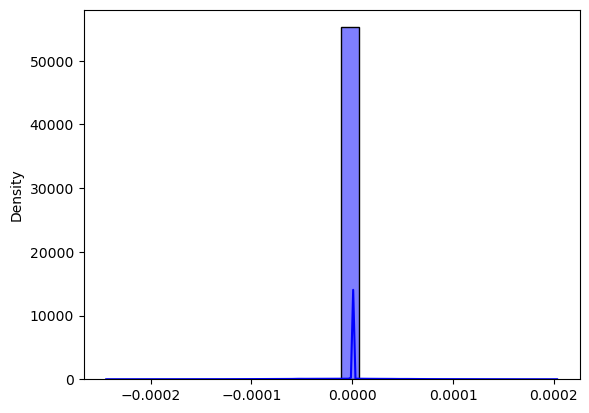

Thr = -0.0007968057970004787
Cluster size :  113564
> 0 :  47704 Max :  0.00020319419854786247
< 0 :  65860 Min :  -0.00024403384304605424
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0003485211715519127. But, you have given threshold=-0.0006630100636370751.
  warnings.warn(


-0.0006630100636370751


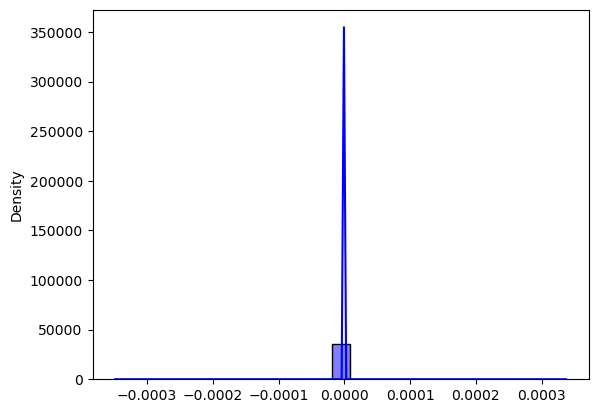

Thr = -0.0006630100636370751
Cluster size :  113564
> 0 :  50678 Max :  0.0003369899350218475
< 0 :  62886 Min :  -0.00034852116368710995
Max consensus :  3.6599023348591694e-11
Min consensus :  -3.723335815584396e-11
Size consensus :  113385
[0.43616536]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002517621997890981. But, you have given threshold=-0.0007850614073572669.
  warnings.warn(


-0.0007850614073572669
[1.11150918]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002761328721820217. But, you have given threshold=-0.0007238671278179783.
  warnings.warn(


-0.0007238671278179783
[0.32562474]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002664273171423726. But, you have given threshold=-0.0007523081364858963.
  warnings.warn(


-0.0007523081364858963
[1.5814182]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0003238904245420654. But, you have given threshold=-0.0006761095754579346.
  warnings.warn(


-0.0006761095754579346
[0.22741748]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00028217360818955. But, you have given threshold=-0.0007574325749870906.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002816898991036115. But, you have given threshold=-0.0007574325749870906.
  warnings.warn(


-0.0007574325749870906
Size bagging :  113564
Size final cluster :  113385


/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


[0.29622001]
Smoothing :  3


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0004657440067645708. But, you have given threshold=-0.0005499867327284677.
  warnings.warn(


-0.0005499867327284677


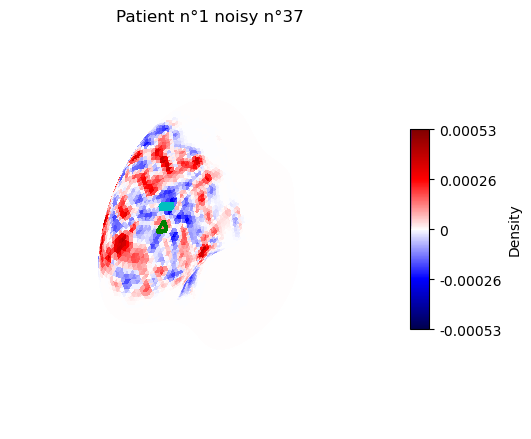

Thr = -0.0005499867327284677
Cluster size :  113564
> 0 :  58628 Max :  0.0004500132636167109
< 0 :  54936 Min :  -0.0004657440003938973
Smoothing :  9


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00012179787545331532. But, you have given threshold=-0.0008924453827153933.
  warnings.warn(


-0.0008924453827153933


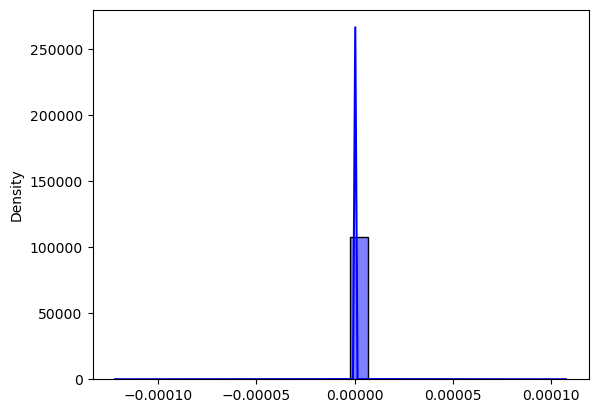

Thr = -0.0008924453827153933
Cluster size :  113564
> 0 :  62679 Max :  0.00010755461698863655
< 0 :  50885 Min :  -0.00012179787881905213
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00022907717794444916. But, you have given threshold=-0.0007950006164509409.
  warnings.warn(


-0.0007950006164509409


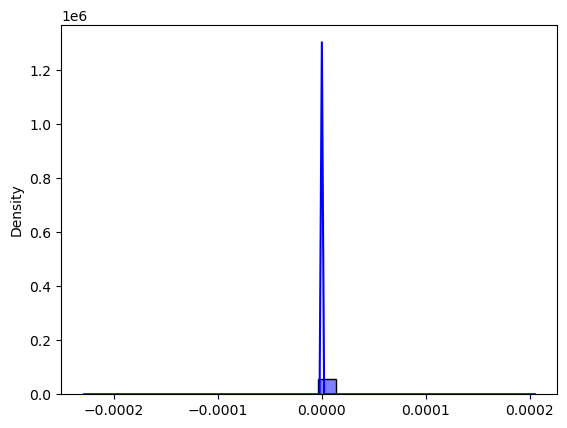

Thr = -0.0007950006164509409
Cluster size :  113564
> 0 :  59765 Max :  0.0002049993781838566
< 0 :  53799 Min :  -0.0002290771808475256
Max consensus :  7.690750481500035e-12
Min consensus :  -1.2177190981568559e-11
Size consensus :  113564
[0.20672928]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002185839463209752. But, you have given threshold=-0.0007814160536790248.
  warnings.warn(


-0.0007814160536790248
[0.5265224]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0003117278698748227. But, you have given threshold=-0.0007069190656269423.
  warnings.warn(


-0.0007069190656269423
[0.67010281]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0003140363445863276. But, you have given threshold=-0.0006859636554136725.
  warnings.warn(


-0.0006859636554136725
[0.50913808]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00027929260056044745. But, you have given threshold=-0.0007207073994395525.
  warnings.warn(


-0.0007207073994395525
[0.12755614]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00023515084646211367. But, you have given threshold=-0.0007712659465865495.
  warnings.warn(


-0.0007712659465865495
Size bagging :  113564
Size final cluster :  113564


/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


[0.5893527]
Smoothing :  3


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00047258290453014093. But, you have given threshold=-0.0005274170954698591.
  warnings.warn(


-0.0005274170954698591


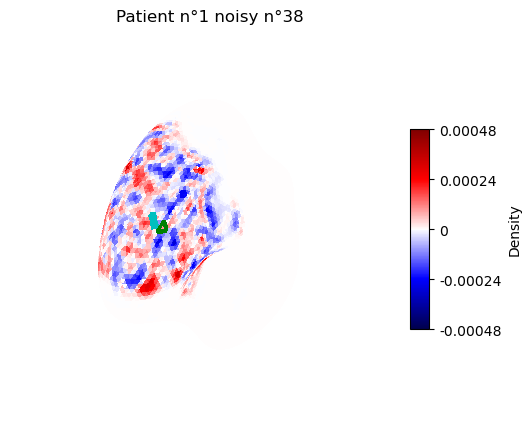

Thr = -0.0005274170954698591
Cluster size :  113564
> 0 :  56136 Max :  0.00047258290578611195
< 0 :  57428 Min :  -0.0004334383993409574
Smoothing :  9


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0001719896114321209. But, you have given threshold=-0.0008375865669383391.
  warnings.warn(


-0.0008375865669383391


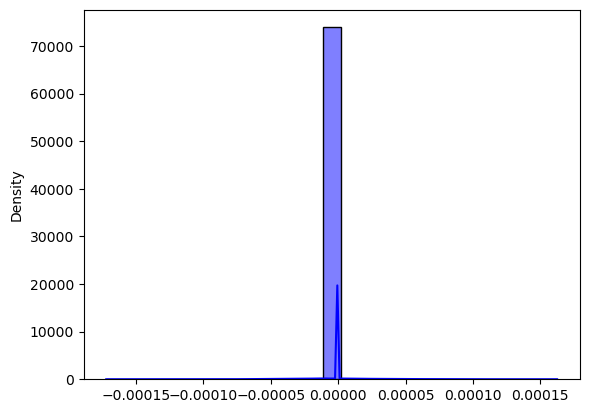

Thr = -0.0008375865669383391
Cluster size :  113564
> 0 :  53629 Max :  0.00016241343109868467
< 0 :  59935 Min :  -0.00017198960995301604
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002853075352556674. But, you have given threshold=-0.0007146924647443326.
  warnings.warn(


-0.0007146924647443326


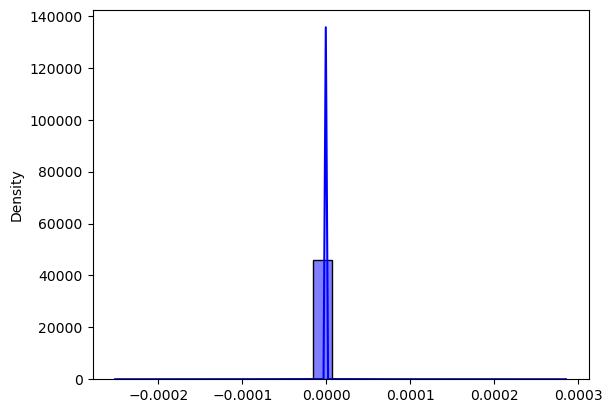

Thr = -0.0007146924647443326
Cluster size :  113564
> 0 :  55060 Max :  0.0002853075275197625
< 0 :  58504 Min :  -0.0002515633241273463
Max consensus :  2.1893675475692817e-11
Min consensus :  -1.5344068539183072e-11
Size consensus :  113564
[1.78185223]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0004208568090454165. But, you have given threshold=-0.0006625110844833478.
  warnings.warn(


-0.0006625110844833478
[0.18895007]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00027835551364189214. But, you have given threshold=-0.0007216444863581079.
  warnings.warn(


-0.0007216444863581079
[0.05693318]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.000249532435216948. But, you have given threshold=-0.0007745219419452107.
  warnings.warn(


-0.0007745219419452107
[0.16570094]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00022205150178477299. But, you have given threshold=-0.000790056431674393.
  warnings.warn(


-0.000790056431674393
[0.26518052]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00022665125617595192. But, you have given threshold=-0.0007798949952559332.
  warnings.warn(


-0.0007798949952559332
Size bagging :  113564
Size final cluster :  113564


/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


[0.88721329]
Smoothing :  3


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0004943100418188434. But, you have given threshold=-0.0005056899581811566.
  warnings.warn(


-0.0005056899581811566


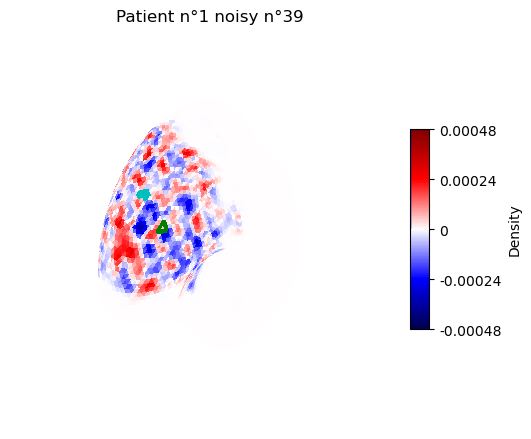

Thr = -0.0005056899581811566
Cluster size :  113564
> 0 :  50807 Max :  0.0004943100502714515
< 0 :  62757 Min :  -0.00046234778710640967
Smoothing :  9


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00015996440270278975. But, you have given threshold=-0.0008400355972972102.
  warnings.warn(


-0.0008400355972972102


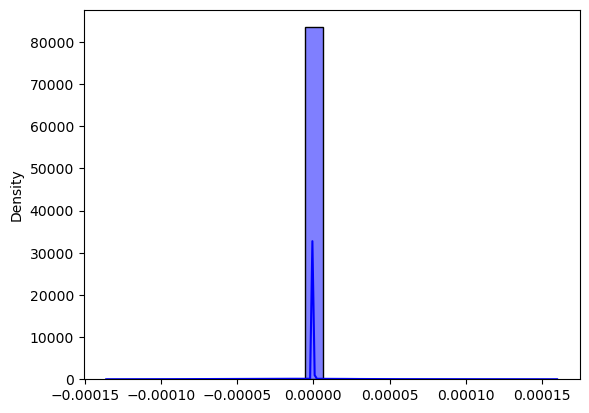

Thr = -0.0008400355972972102
Cluster size :  113564
> 0 :  43725 Max :  0.00015996440197341144
< 0 :  69839 Min :  -0.00013593488256447017
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00027798327532642164. But, you have given threshold=-0.0007220167246735783.
  warnings.warn(


-0.0007220167246735783


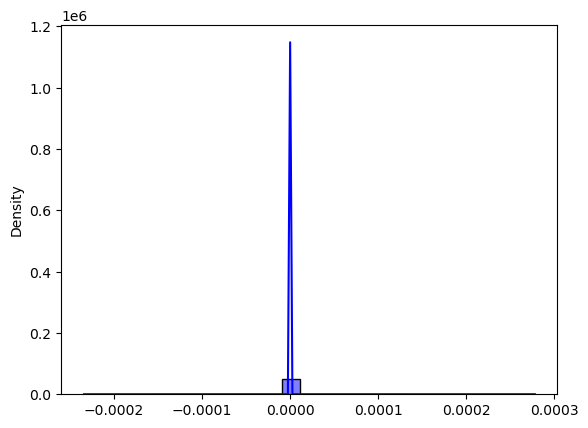

Thr = -0.0007220167246735783
Cluster size :  113564
> 0 :  47364 Max :  0.00027798328665085137
< 0 :  66200 Min :  -0.00023410470748785883
Max consensus :  2.0165567838913394e-11
Min consensus :  -1.321520501141409e-11
Size consensus :  113564
[0.97942103]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0003358416182830537. But, you have given threshold=-0.0006641583817169463.
  warnings.warn(


-0.0006641583817169463
[0.0983768]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00024053486582276603. But, you have given threshold=-0.0007730992591146496.
  warnings.warn(


-0.0007730992591146496
[1.00414287]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00030202158800151496. But, you have given threshold=-0.0006979784119984851.
  warnings.warn(


-0.0006979784119984851
[1.42602356]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00035854830824903734. But, you have given threshold=-0.0006931487392036898.
  warnings.warn(


-0.0006931487392036898
[0.8415952]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002742283154252013. But, you have given threshold=-0.0007402362600781674.
  warnings.warn(


-0.0007402362600781674
Size bagging :  113564
Size final cluster :  113564


/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


[0.91973745]
Smoothing :  3


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0005321888882002839. But, you have given threshold=-0.0005338596542620009.
  warnings.warn(


-0.0005338596542620009


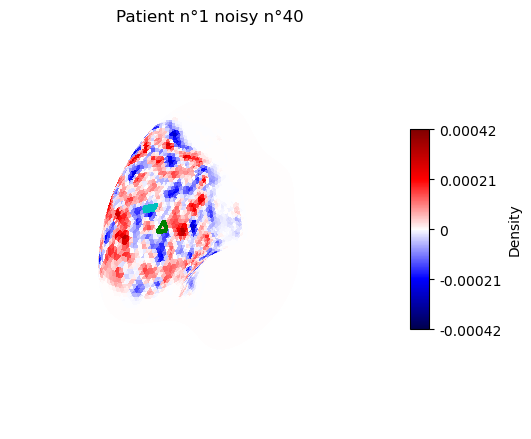

Thr = -0.0005338596542620009
Cluster size :  113564
> 0 :  54676 Max :  0.0004661403363570571
< 0 :  58888 Min :  -0.0005321888602338731
Smoothing :  9


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00017288164022818584. But, you have given threshold=-0.0008534058991566231.
  warnings.warn(


-0.0008534058991566231


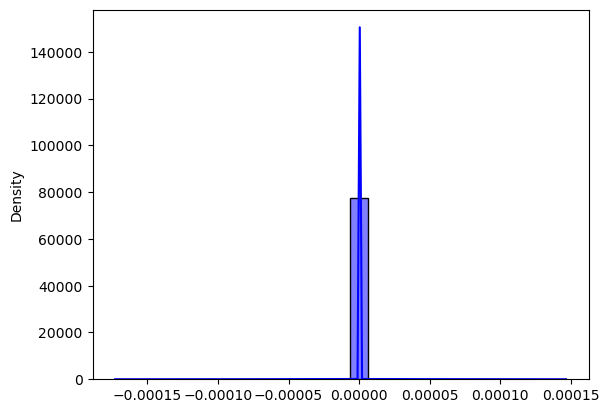

Thr = -0.0008534058991566231
Cluster size :  113564
> 0 :  53068 Max :  0.00014659410226158798
< 0 :  60496 Min :  -0.00017288164235651493
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002973898001796145. But, you have given threshold=-0.0007355237885029442.
  warnings.warn(


-0.0007355237885029442


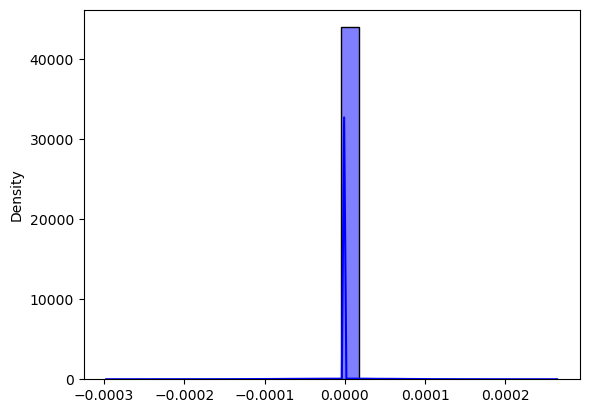

Thr = -0.0007355237885029442
Cluster size :  113564
> 0 :  53937 Max :  0.00026447619893588126
< 0 :  59627 Min :  -0.00029738980811089277
Max consensus :  1.7733677320028408e-11
Min consensus :  -2.489513877848378e-11
Size consensus :  113564
[0.39290354]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00024085888107743737. But, you have given threshold=-0.0007591411189225626.
  warnings.warn(


-0.0007591411189225626
[0.35648255]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00024811472146012923. But, you have given threshold=-0.0007518852785398707.
  warnings.warn(


-0.0007518852785398707
[0.40254428]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.000317225054979851. But, you have given threshold=-0.0007693147062131852.
  warnings.warn(


-0.0007693147062131852
[1.15661067]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002557466636213167. But, you have given threshold=-0.0007556662887879295.
  warnings.warn(


-0.0007556662887879295
[0.50858703]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00029324097780620477. But, you have given threshold=-0.0007569373501111567.
  warnings.warn(


-0.0007569373501111567
Size bagging :  113564
Size final cluster :  113564


/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


[0.48345822]
Smoothing :  3


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0005381798368376479. But, you have given threshold=-0.0005818107722431738.
  warnings.warn(


-0.0005818107722431738


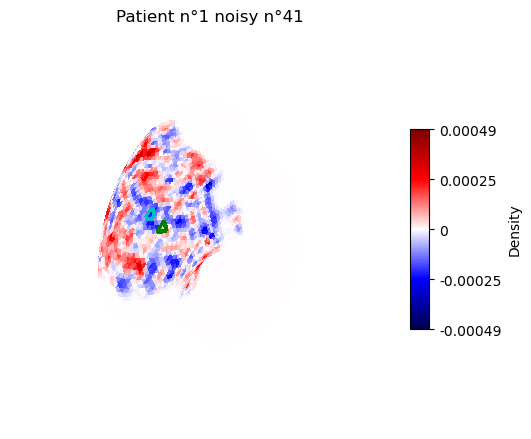

Thr = -0.0005818107722431738
Cluster size :  113564
> 0 :  58453 Max :  0.0004181892145425081
< 0 :  55111 Min :  -0.0005381798255257308
Smoothing :  9


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00013045836665397567. But, you have given threshold=-0.0008836519422161234.
  warnings.warn(


-0.0008836519422161234


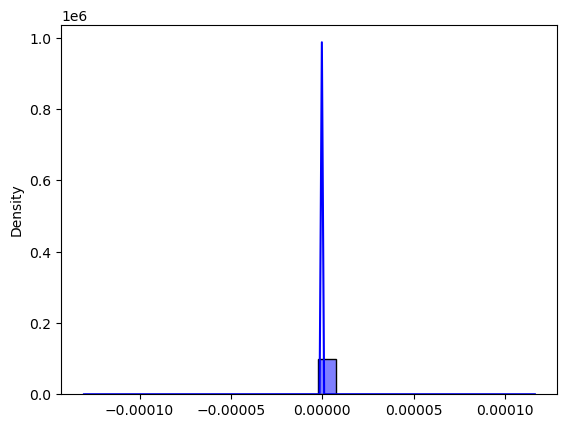

Thr = -0.0008836519422161234
Cluster size :  113564
> 0 :  59106 Max :  0.00011634805559879169
< 0 :  54458 Min :  -0.0001304583711316809
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00026587717096531897. But, you have given threshold=-0.000785388017782489.
  warnings.warn(


-0.000785388017782489


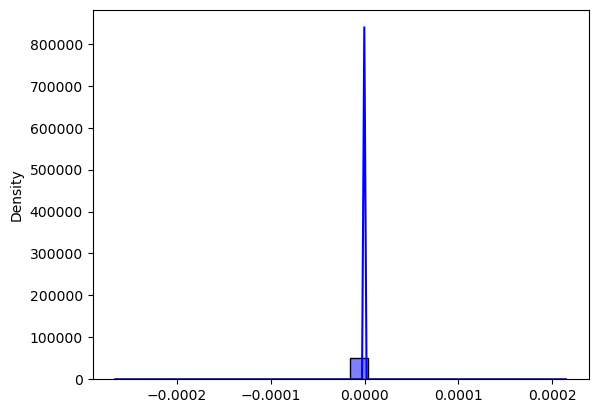

Thr = -0.000785388017782489
Cluster size :  113564
> 0 :  58635 Max :  0.00021461198048200458
< 0 :  54929 Min :  -0.00026587717002257705
Max consensus :  8.84708188478983e-12
Min consensus :  -1.8255040219198225e-11
Size consensus :  113564
[0.26599232]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00025751931539117986. But, you have given threshold=-0.0007424806846088202.
  warnings.warn(


-0.0007424806846088202
[0.29409836]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00024386447877085114. But, you have given threshold=-0.0007561355212291488.
  warnings.warn(


-0.0007561355212291488
[0.47640716]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00026184956783738885. But, you have given threshold=-0.0007523086948482092.
  warnings.warn(


-0.0007523086948482092
[1.55875175]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00036716289919718143. But, you have given threshold=-0.0006328371008028186.
  warnings.warn(


-0.0006328371008028186
[0.25213379]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002514497034434666. But, you have given threshold=-0.0007485502965565334.
  warnings.warn(


-0.0007485502965565334
Size bagging :  113564
Size final cluster :  113564


/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


[0.61702691]
Smoothing :  3


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0005624394809163936. But, you have given threshold=-0.0005637335158896119.
  warnings.warn(


-0.0005637335158896119


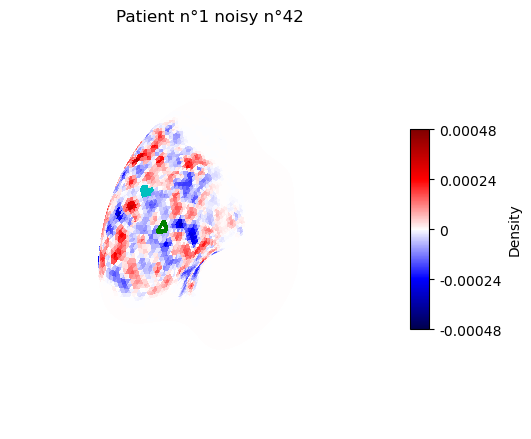

Thr = -0.0005637335158896119
Cluster size :  113562
> 0 :  49857 Max :  0.00043626647675409913
< 0 :  63705 Min :  -0.000562439498025924
Smoothing :  9


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.000150017123633958. But, you have given threshold=-0.000889253312296885.
  warnings.warn(


-0.000889253312296885


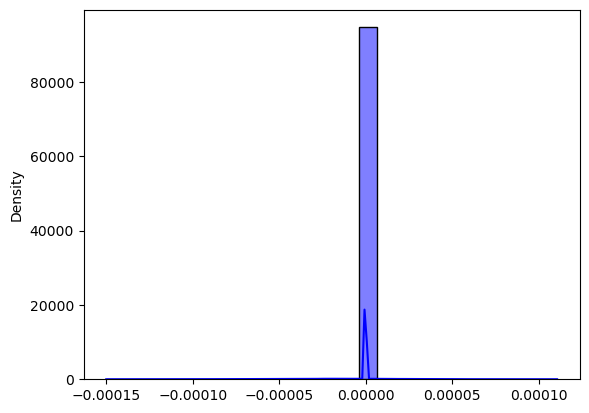

Thr = -0.000889253312296885
Cluster size :  113564
> 0 :  38799 Max :  0.00011074668873334303
< 0 :  74765 Min :  -0.00015001712017692626
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002873447632528568. But, you have given threshold=-0.0007907167793524588.
  warnings.warn(


-0.0007907167793524588


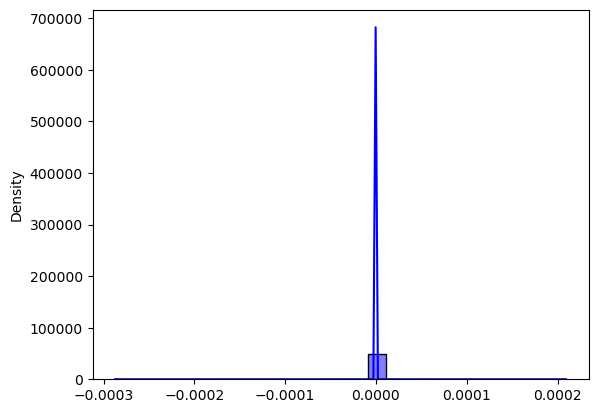

Thr = -0.0007907167793524588
Cluster size :  113564
> 0 :  45338 Max :  0.00020928321464452893
< 0 :  68226 Min :  -0.0002873447665479034
Max consensus :  8.02372287318183e-12
Min consensus :  -2.2862401088342426e-11
Size consensus :  113562
[0.80098452]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002659077741928998. But, you have given threshold=-0.0007477226405001166.
  warnings.warn(


-0.0007477226405001166
[0.09857606]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00024881535582468254. But, you have given threshold=-0.0007511846441753175.
  warnings.warn(


-0.0007511846441753175
[1.40665528]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0003208421872121134. But, you have given threshold=-0.0006791578127878866.
  warnings.warn(


-0.0006791578127878866
[1.12228565]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002905394620308567. But, you have given threshold=-0.0007094605379691433.
  warnings.warn(


-0.0007094605379691433
[0.04703569]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002931652715454526. But, you have given threshold=-0.0007745745629204123.
  warnings.warn(


-0.0007745745629204123
Size bagging :  113564
Size final cluster :  113562


/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


[0.04921686]
Smoothing :  3


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00045249047569589603. But, you have given threshold=-0.0005843291470404541.
  warnings.warn(


-0.0005843291470404541


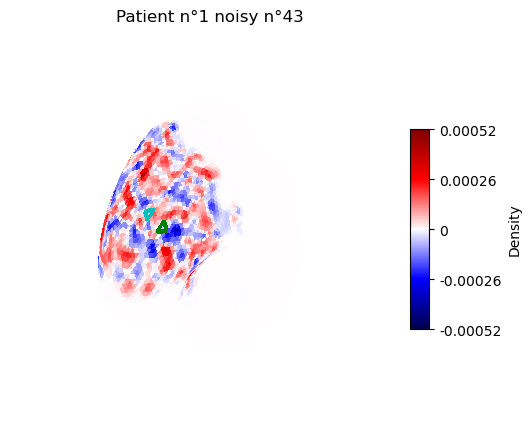

Thr = -0.0005843291470404541
Cluster size :  113564
> 0 :  59461 Max :  0.00041567086009308696
< 0 :  54103 Min :  -0.00045249046524986625
Smoothing :  9


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00013269722864753806. But, you have given threshold=-0.0008783802300491395.
  warnings.warn(


-0.0008783802300491395


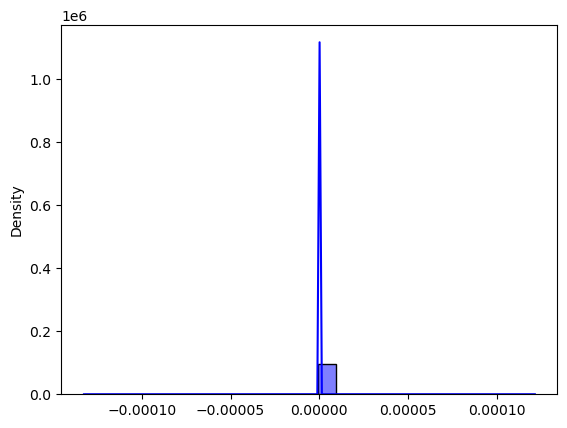

Thr = -0.0008783802300491395
Cluster size :  113564
> 0 :  61598 Max :  0.00012161977065261453
< 0 :  51966 Min :  -0.00013269722694531083
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00023275758134272458. But, you have given threshold=-0.0007738883579224047.
  warnings.warn(


-0.0007738883579224047


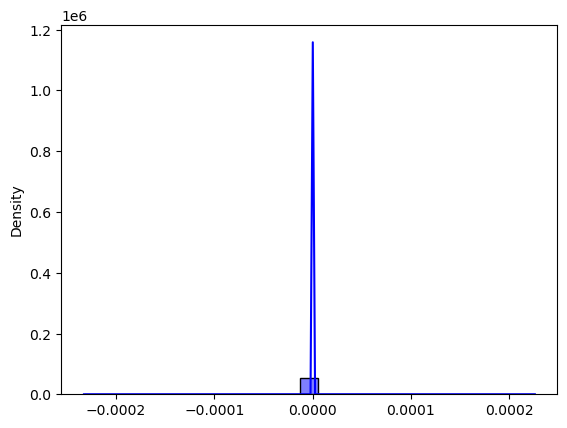

Thr = -0.0007738883579224047
Cluster size :  113564
> 0 :  60130 Max :  0.00022611164604313672
< 0 :  53434 Min :  -0.000232757578487508
Max consensus :  1.104251297994327e-11
Min consensus :  -1.1532748577074224e-11
Size consensus :  113564
[2.71740778]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0004900113975851104. But, you have given threshold=-0.0006274376826581308.
  warnings.warn(


-0.0006274376826581308
[1.81718511]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0003968658026882502. But, you have given threshold=-0.0006031341973117498.
  warnings.warn(


-0.0006031341973117498
[0.20645885]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00024066359983049897. But, you have given threshold=-0.000759336400169501.
  warnings.warn(


-0.000759336400169501
[0.35303587]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002623951457509298. But, you have given threshold=-0.0007463110458556551.
  warnings.warn(


-0.0007463110458556551
[1.69005325]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00036684333334569957. But, you have given threshold=-0.0006721849092387118.
  warnings.warn(


-0.0006721849092387118
Size bagging :  113564
Size final cluster :  113564


/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


[1.31464051]
Smoothing :  3
-0.00044075486907249


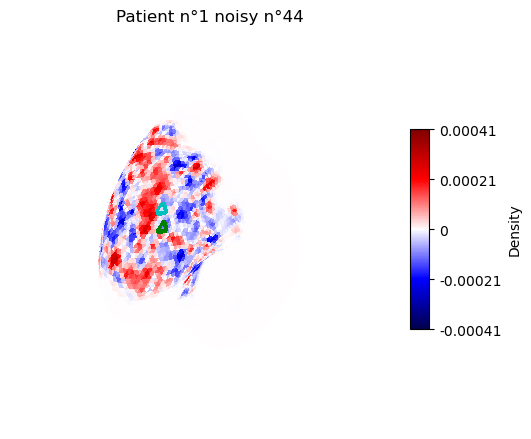

Thr = -0.00044075486907249
Cluster size :  113273
> 0 :  53718 Max :  0.0005592451198026538
< 0 :  59555 Min :  -0.00044047069968655705
Smoothing :  9


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002166577757188408. But, you have given threshold=-0.000802794431989747.
  warnings.warn(


-0.000802794431989747


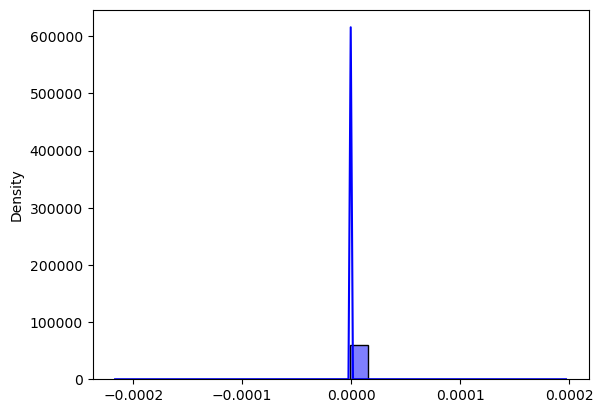

Thr = -0.000802794431989747
Cluster size :  113564
> 0 :  45821 Max :  0.0001972055615624413
< 0 :  67743 Min :  -0.00021665777603629977
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00038854265531523396. But, you have given threshold=-0.0006839526786357206.
  warnings.warn(


-0.0006839526786357206


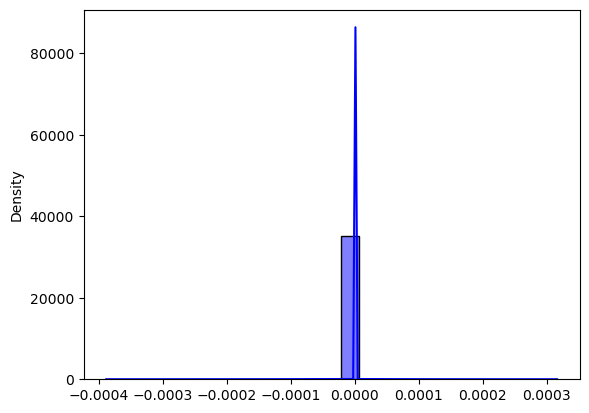

Thr = -0.0006839526786357206
Cluster size :  113564
> 0 :  50208 Max :  0.0003160473133902997
< 0 :  63356 Min :  -0.00038854265585541725
Max consensus :  2.953233520891877e-11
Min consensus :  -2.9277645532670296e-11
Size consensus :  113273
[0.06904772]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00024704603215685954. But, you have given threshold=-0.0007775099482865432.
  warnings.warn(


-0.0007775099482865432
[1.37379103]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00031978354285578953. But, you have given threshold=-0.0007052307192288783.
  warnings.warn(


-0.0007052307192288783
[0.86385298]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.000262309020250741. But, you have given threshold=-0.0007442086375267372.
  warnings.warn(


-0.0007442086375267372
[0.8744016]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002636891889923208. But, you have given threshold=-0.0007538252026042778.
  warnings.warn(


-0.0007538252026042778
[0.17396753]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002246512102566397. But, you have given threshold=-0.0007915844043220159.
  warnings.warn(


-0.0007915844043220159
Size bagging :  113564
Size final cluster :  113273


/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


[1.11120888]
Smoothing :  3


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0005180292289866258. But, you have given threshold=-0.000520372585363155.
  warnings.warn(


-0.000520372585363155


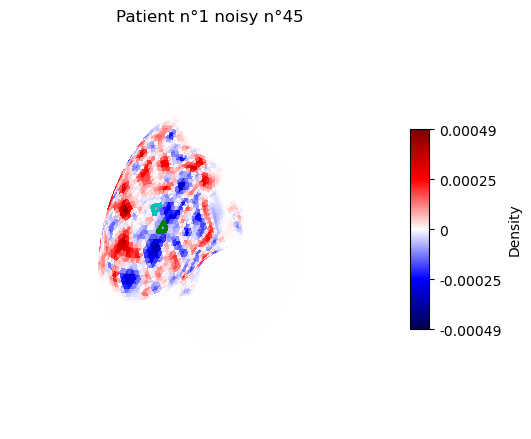

Thr = -0.000520372585363155
Cluster size :  113562
> 0 :  50545 Max :  0.000479627400636673
< 0 :  63017 Min :  -0.0005180292064324021
Smoothing :  9


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00017894022002377144. But, you have given threshold=-0.0008263434318169822.
  warnings.warn(


-0.0008263434318169822


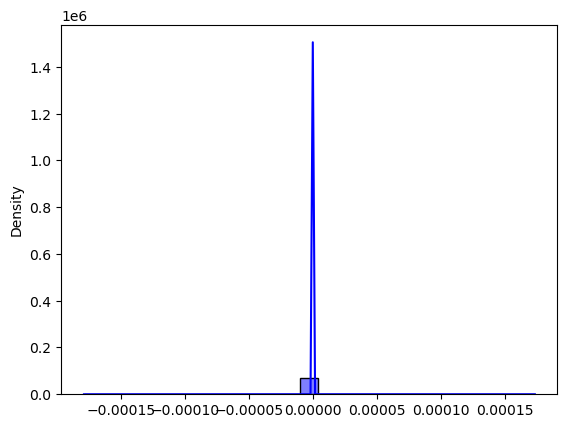

Thr = -0.0008263434318169822
Cluster size :  113564
> 0 :  42432 Max :  0.00017365656094625592
< 0 :  71132 Min :  -0.00017894021584652364
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00028992751977390885. But, you have given threshold=-0.0007190695534569842.
  warnings.warn(


-0.0007190695534569842


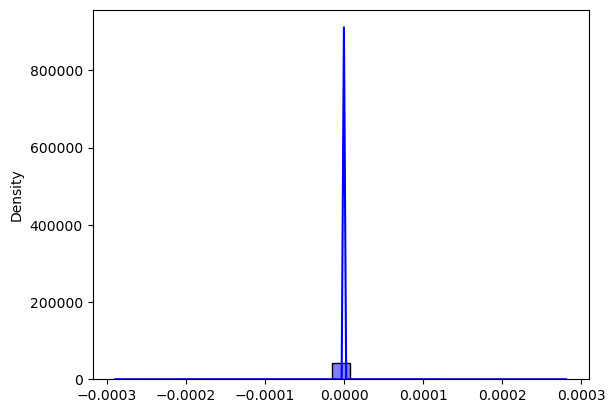

Thr = -0.0007190695534569842
Cluster size :  113564
> 0 :  47243 Max :  0.00028093045693822205
< 0 :  66321 Min :  -0.00028992752777412534
Max consensus :  2.1984245085167365e-11
Min consensus :  -2.32676542302995e-11
Size consensus :  113562
[0.83236217]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0003193698601019426. But, you have given threshold=-0.0007486767533110945.
  warnings.warn(


-0.0007486767533110945
[0.12232015]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00021830417746391282. But, you have given threshold=-0.0007816958225360872.
  warnings.warn(


-0.0007816958225360872
[0.72986854]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00031857034682863223. But, you have given threshold=-0.0006814296531713678.
  warnings.warn(


-0.0006814296531713678
[1.84279078]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0003887718001352174. But, you have given threshold=-0.0006112281998647826.
  warnings.warn(


-0.0006112281998647826
[1.68506902]
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.00038822912036110186. But, you have given threshold=-0.0006117708796388982.
  warnings.warn(


-0.0006117708796388982
Size bagging :  113564
Size final cluster :  113562


/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


[0.46865996]
Smoothing :  3


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0004692011006042548. But, you have given threshold=-0.0005534227452869406.
  warnings.warn(


-0.0005534227452869406


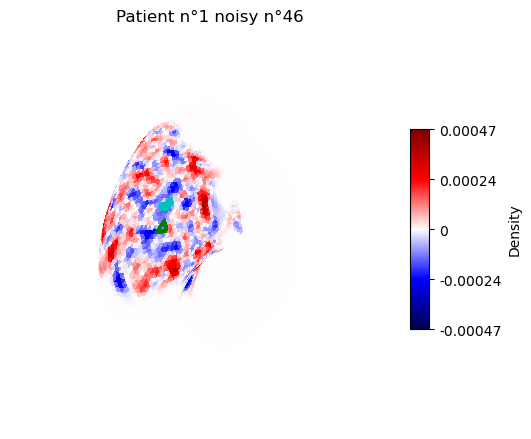

Thr = -0.0005534227452869406
Cluster size :  113564
> 0 :  57333 Max :  0.0004465772653929889
< 0 :  56231 Min :  -0.0004692010988947004
Smoothing :  9


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0001511898970376993. But, you have given threshold=-0.0008654740081083306.
  warnings.warn(


-0.0008654740081083306


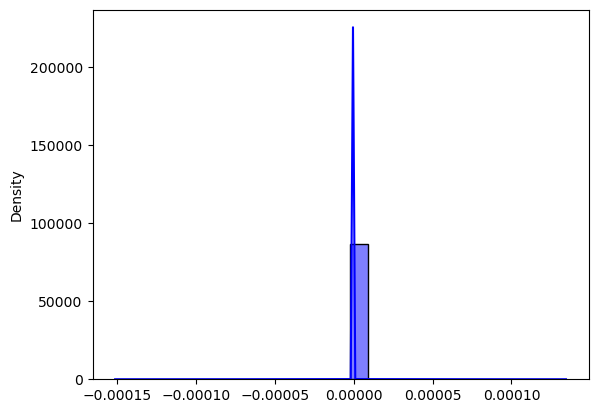

Thr = -0.0008654740081083306
Cluster size :  113564
> 0 :  57585 Max :  0.00013452599523589015
< 0 :  55979 Min :  -0.00015118990268092602
Smoothing :  6


/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0002505468652731391. But, you have given threshold=-0.0007833122888205024.
  warnings.warn(


-0.0007833122888205024


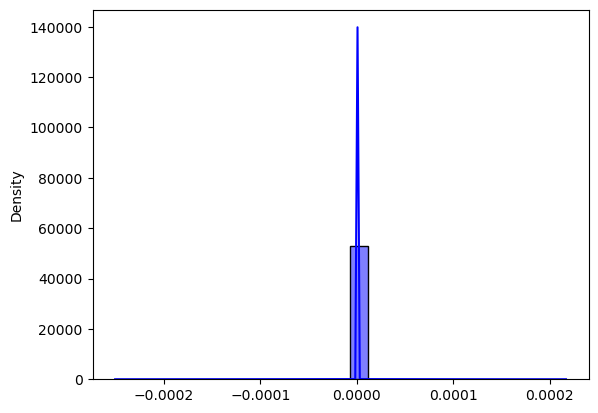

Thr = -0.0007833122888205024
Cluster size :  113564
> 0 :  57880 Max :  0.00021668770932592452
< 0 :  55684 Min :  -0.00025054687284864485
Max consensus :  1.0039599197129878e-11
Min consensus :  -1.764614571467879e-11
Size consensus :  113564
[1.00258192]


In [ ]:
TARGETS = []
DATA = []

DISTANCE = []
DIST_VAR = []
BIC = []
AMI = []
TMS_results_SUCCEED= []

# INITIALIZATION
for i in range(len(Images)):
    print('Patient n°',image_Ids[i])
    SgACC_time_series= seed_masker.fit_transform(Images[i])
    SgACC_time_serie = np.median(SgACC_time_series, axis=1).reshape(-1, 1)
    
    brain_time_series = brain_masker.fit_transform(Images[i])
    if FC_type == 'median':
        correlation_matrix = SgACC_time_serie * brain_time_series
        flatten_fc_map = np.median(correlation_matrix, axis=0).reshape(-1, 1)
    elif FC_type == 'mean':
        flatten_fc_map = (np.dot(brain_time_series.T, SgACC_time_serie) / SgACC_time_serie.shape[0]) # ! renversée
    
    inverted_fc_map = brain_masker.inverse_transform(-flatten_fc_map.T)
    real_fc_map = brain_masker.inverse_transform(flatten_fc_map.T) # not inverted values
    # APPLY PIPELINE ON DATA
    
    expected_target,_,final_cluster = Pipeline(brain_time_series,inverted_fc_map,real_fc_map,False,False)
    if expected_target.size != 0 :
        TARGETS += [expected_target]
        TMS_results_SUCCEED += [TMS_results[i]]
        # Plot
        ClusterFunctions.plot_real_to_cash(real_fc_map,niimg,expected_target,'seismic','Final target on FC-map patient n°'+str(image_Ids[i]))

        # E_FIELD ANALYSIS
        FC_mean = real_fc_map.get_fdata()
        final_cluster_reshape = final_cluster.reshape((193, 229, 193, 1))
        E_field = nib.load('Data/SIMNIBS/sub-100'+image_Str[i]+'_TMS_1-0001_MagStim_D70_scalar_MNI_magnE.nii')
        data = E_field.get_fdata()
        data[data < 0.8*np.max(data)] = 0
        new_E_field = nilearn.image.new_img_like(E_field, data, affine=E_field.affine, copy_header=False)
        new_E_field = nilearn.image.resample_img(new_E_field, target_affine=real_fc_map.affine, target_shape=real_fc_map.get_fdata().shape[:3], interpolation='continuous', copy=True, order='F', clip=True, fill_value=0, force_resample=False)
        E_field_AND_cluster = np.logical_and(new_E_field.get_fdata() != 0, final_cluster_reshape != 0).astype(int)
        E_field_AND_cluster_AND_FC_mean = E_field_AND_cluster * FC_mean
        DATA += [E_field_AND_cluster_AND_FC_mean]
        
        # NOISE ROBUSTNESS
        nTARGETS = []
        Flatten_Clusters = []
        print('Noise analysis...')
        for m in range(n_noisy):
            in_fc_map,n_fc_map,flatten_with_noise = ClusterFunctions.generate_noisy_fc_maps(flatten_fc_map,brain_masker)
            # APPLY STRATEGY ON EACH NOISY DATA
            target,cluster_arr,final_cluster = Pipeline(brain_time_series,in_fc_map,n_fc_map,True,False)
            if target.size != 0 :
                nTARGETS += [target]
                Flatten_Clusters += [cluster_arr]
                try :
                    ClusterFunctions.plot_real_to_cash(n_fc_map,niimg,target,'seismic','Patient n°'+str(image_Ids[i])+' noisy n°'+str(m))
                except :
                    print('Vertices in parcellation do not form region')


        # RATING THE STRATEGY
        dist_to_real = 0.2*np.array([np.linalg.norm(nTARGETS[i] - expected_target) for i in range(len(nTARGETS))])
        mean_distance = np.mean(dist_to_real) 
        std_distance = np.std(dist_to_real)   
        bic,_ = ClusterFunctions.accuracy(Flatten_Clusters[0], Flatten_Clusters[1:])
        AMI_values,_ = ClusterFunctions.reproducibility_image(Flatten_Clusters[0].ravel(),[flatten_cluster.ravel() for flatten_cluster in Flatten_Clusters[1:]])
        mean_AMI = np.mean(AMI_values)
        std_AMI = np.std(AMI_values)

    # CONCLUSION : print the scores
        DISTANCE += [mean_distance]
        DIST_VAR += [std_distance]
        BIC += [bic]
        AMI += [mean_AMI]
        if i % 5 == 0:
            print('Research completed at '+ str(100*((i+1)/(len(Images)+1)))+'%' )
        



In [ ]:
print('Distance : ', np.mean(DISTANCE), 'Dist. Variance : ', np.mean(DIST_VAR), 
      'BIC : '     , np.mean(BIC)     , 'AMI : '           , np.mean(AMI))    ,


In [ ]:
print(len(TMS_results_SUCCEED))

In [ ]:
# full plot around cash
fsaverage = datasets.fetch_surf_fsaverage('fsaverage6')
curv_left = surface.load_surf_data(fsaverage.curv_left)
curv_left_sign = np.sign(curv_left)
texture = surface.vol_to_surf(frontal_mask_img, fsaverage.pial_left)

pial = fsaverage.pial_left
coord = np.array([-41, 43, 27])

mesh_coords = np.array(nib.load(pial).darrays[0].data)

diff = mesh_coords-coord
sq_distance = np.sum(diff**2, 1)
closest = np.argsort(sq_distance)[:3]
parcellation = np.zeros(texture.shape)
parcellation[closest] = 1
fig = plotting.plot_surf_stat_map(surf_mesh = fsaverage.infl_left, stat_map=texture,hemi='left', view=[10.0, 120.0],title='Targets',engine = 'matplotlib', cmap = 'gray')
fig=plotting.plot_surf_contours(fsaverage.infl_left, parcellation, labels=['roi'], levels=[1], figure=fig, legend=False, colors=['g'])

for i in range(len(TARGETS)) : 

    diff = mesh_coords-TARGETS[i]
    sq_distance = np.sum(diff**2, 1)
    closest = np.argsort(sq_distance)[:3]
    parcellation2 = np.zeros(texture.shape)
    parcellation2[closest] = 1


    fig=plotting.plot_surf_contours(fsaverage.infl_left, parcellation2, labels=['roi'], levels=[1], figure=fig, legend=False, colors=['c'])

fig.show()




In [ ]:
print(TARGETS)

In [ ]:
print(len(TARGETS))

# Get correlations and study scores

In [ ]:
import seaborn as sns

In [ ]:
SCORES_mean = [np.mean(data) for data in DATA]
SCORES_mean_N = [np.mean(data[data < 0]) for data in DATA]
#SCORES_meanP = [np.mean(data[data > 0]) for data in DATA]
SCORES_cnt = [np.count_nonzero(data) for data in DATA]
SCORES_cnt_N = [np.count_nonzero(data < 0) for data in DATA]

data_list = [SCORES_mean, SCORES_mean_N, SCORES_cnt, SCORES_cnt_N]
color_list = ['skyblue', 'orange', 'green', 'red']

In [ ]:
print(data_list)

In [ ]:
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # Adjust the size as needed

# List of data and colors for each subplot


# Plot histograms with Gaussian fit for each subplot
for i, (data, color) in enumerate(zip(data_list, color_list)):
    sns.histplot(data, kde=True, color=color, stat='density', ax=axs[i // 2, i % 2])
    # Fit Gaussian distribution to the data
    # Plot a univariate kernel density estimate
    sns.kdeplot(data)
    axs[i // 2, i % 2].set_title(f'Histogram {i + 1}')  # Set title for the subplot

# Add labels and title for the entire figure
plt.xlabel('Value')
plt.ylabel('Density')
plt.suptitle('Subplots of Histograms with Gaussian Fit')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
from scipy.stats import pearsonr, spearmanr

### Pearson correlation

In [ ]:
print('FC-mean')
pearson_corr, pearson_p_value = pearsonr(SCORES_mean, TMS_results_SUCCEED)
print("        Pearson correlation coefficient:", pearson_corr)
print("        Pearson p-value:", pearson_p_value)

print('FC-mean for voxels < 0')
pearson_corr, pearson_p_value = pearsonr(SCORES_mean_N, TMS_results_SUCCEED)
print("        Pearson correlation coefficient:", pearson_corr)
print("        Pearson p-value:", pearson_p_value)

print('Count')
pearson_corr, pearson_p_value = pearsonr(SCORES_cnt, TMS_results_SUCCEED)
print("        Pearson correlation coefficient:", pearson_corr)
print("        Pearson p-value:", pearson_p_value)

print('Count for voxels < 0')
pearson_corr, pearson_p_value = pearsonr(SCORES_cnt_N, TMS_results_SUCCEED)
print("        Pearson correlation coefficient:", pearson_corr)
print("        Pearson p-value:", pearson_p_value)

### Spearman correlation

In [ ]:
print('FC-mean')
spearman_corr, spearman_p_value = spearmanr(SCORES_mean, TMS_results_SUCCEED)
print("        Spearman correlation coefficient:", spearman_corr)
print("        Spearman p-value:", spearman_p_value)

print('FC-mean for voxels < 0')
spearman_corr, spearman_p_value = spearmanr(SCORES_mean_N, TMS_results_SUCCEED)
print("        Spearman correlation coefficient:", spearman_corr)
print("        Spearman p-value:", spearman_p_value)

print('Count')
spearman_corr, spearman_p_value = spearmanr(SCORES_cnt, TMS_results_SUCCEED)
print("        Spearman correlation coefficient:", spearman_corr)
print("        Spearman p-value:", spearman_p_value)

print('Count for voxels < 0')
spearman_corr, spearman_p_value = spearmanr(SCORES_cnt_N, TMS_results_SUCCEED)
print("        Spearman correlation coefficient:", spearman_corr)
print("        Spearman p-value:", spearman_p_value)

### Linear regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [ ]:
# PLOT PREDICTIVE POWER
SCORES = [SCORES_mean,SCORES_mean_N,SCORES_cnt,SCORES_cnt_N]
for SCORE in SCORES :
    # Fit linear regression model
    model = LinearRegression()
    x_reshaped = np.array(SCORE).reshape(-1, 1) 
    model.fit(x_reshaped, TMS_results_SUCCEED)

    # Predict y values using the fitted model
    y_pred = model.predict(x_reshaped)

    # Calculate R-squared
    r_squared = r2_score(TMS_results_SUCCEED, y_pred)

    # Plot scatter plot of the data points
    plt.scatter(SCORE, TMS_results_SUCCEED, color='blue', label='Data Points')

    # Plot the linear regression line
    plt.plot(SCORE, y_pred, color='red', label='Linear Regression')

    # Add labels and legend
    plt.xlabel('score')
    plt.ylabel('MADRS delta')
    plt.title(f'Scatter Plot with Linear Regression (R-squared: {r_squared:.2f}), a = '+str(np.round(model.coef_[0],2)))
    plt.legend()

    # Show plot
    plt.grid(True)
    plt.show()



# sgACC spearman corr.

In [ ]:
'''
for i in range(len(Images)):
    print('Patient n°',image_Ids[i])
    SgACC_time_series= seed_masker.fit_transform(Images[i])
    SgACC_time_serie = np.median(SgACC_time_series, axis=1).reshape(-1, 1)

    #dataset = datasets.fetch_development_fmri(n_subjects=1)
    #func_filename = dataset.func[0]
    pcc_coords = [(0, -52, 18)]
    #mask_img = compute_epi_mask(func_filename)

    sphere_masker = NiftiSpheresMasker(
        pcc_coords,
        radius=8,
        mask_img=bin_niimg
    )
    Sphere_time_series = sphere_masker.fit_transform(Images[i])
    #print(Sphere_time_series)
    Sphere_time_serie = np.median(Sphere_time_series, axis=1)
    #print(print(Sphere_time_serie))
    #sphere_mask = sphere_masker.inverse_transform(100 * seed_time_series[0])
    spearman_corr, spearman_p_value = spearmanr(SgACC_time_serie, Sphere_time_serie)
    print("        Spearman correlation coefficient:", spearman_corr)
    print("        Spearman p-value:", spearman_p_value)
'''